In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2021-08-03 12:03.


In [2]:
def adata_louvain_name_convert(inputAdata, orderDf, louvainNewOrdered, louvainOldOrdered):
    inputAdata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(inputAdata.obs['louvain'], inputAdata.obs['cell_type']))]
    inputAdata.obs["celltype_general"] = [x[0] for x in inputAdata.obs['cell_type']]
    
    #--- Match old & new louvain levels
    inputAdata.obs['louvain_old'] = inputAdata.obs['louvain']
    inputAdata.uns['louvain_old_colors'] = inputAdata.uns['louvain_colors']
    inputAdata.obs['louvain'] = [ louvainNewOrdered[louvainOldOrdered.index(int(x))] for x in inputAdata.obs['louvain'] ]
    category_order = orderDf.sort_values('louvain')['louvain_new_label'].tolist()
    category_order = [x for x in category_order if x in np.unique(inputAdata.obs['louvain'])]
    inputAdata.obs['louvain'] = pd.Categorical(inputAdata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

    inputAdata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in inputAdata.obs['cell_type']]
    inputAdata.obs['cell_id'] = inputAdata.obs.index.tolist()

In [3]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [4]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s/scVelo"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [5]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()

In [6]:
resampled_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampledNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
adata = scv.read(resampled_h5ad)
adata_louvain_name_convert(adata, order_df, louvain_new_ordered, louvain_old_ordered)

adata_subset_arm = adata[[True if 'C' not in x else False for x in adata.obs['cell_type']]]
adata_subset_cl13 = adata[[True if 'A' not in x else False for x in adata.obs['cell_type']]]

if False:
    act_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/1_scVelo_out_ACTonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_act = scv.read(act_h5ad)

    act_arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_actARMonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_act_arm = scv.read(act_arm_h5ad)

    act_cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_actCL13onlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_act_cl13 = scv.read(act_cl13_h5ad)

    arm_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/2_scVelo_out_ARMonlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_arm = scv.read(arm_h5ad)

    cl13_h5ad = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/3_scVelo_out_CL13onlyNoDyn/0_Acute-Chronic_scVelo_postPT.h5ad'
    adata_cl13 = scv.read(cl13_h5ad)


    adata_louvain_name_convert(adata_act, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_act_arm, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_act_cl13, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_arm, order_df, louvain_new_ordered, louvain_old_ordered)
    adata_louvain_name_convert(adata_cl13, order_df, louvain_new_ordered, louvain_old_ordered)

    adata_act.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act.obs.index.tolist()]
    adata_act_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_arm.obs.index.tolist()]
    adata_act_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_act_cl13.obs.index.tolist()]
    adata_arm.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_arm.obs.index.tolist()]
    adata_cl13.obs['velocity_pseudotime'] = adata.obs['velocity_pseudotime'][adata_cl13.obs.index.tolist()]

In [7]:
paga_xmax, paga_ymax = np.amax(adata.obsm['paga'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['paga'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.15, paga_xmin - paga_dx*0.15
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.15, paga_ymin - paga_dy*0.15

def subplot_lims(adata_use):
    x_max_i, y_max_i = np.amax(adata_use.obsm['paga'], axis=0)
    x_min_i, y_min_i = np.amin(adata_use.obsm['paga'], axis=0)
    dx_i, dy_i = x_max_i - x_min_i, y_max_i - y_min_i
    x_ratio, y_ratio = ((x_max_i - x_min_i) / paga_dx), ((y_max_i - y_min_i) / paga_dy)
    use_ratio = max(x_ratio, y_ratio)
    y_max_i, y_min_i = (y_max_i + y_min_i) / 2 + paga_dy*use_ratio / 2, (y_max_i + y_min_i) / 2 - paga_dy*use_ratio / 2
    x_max_i, x_min_i = (x_max_i + x_min_i) / 2 + paga_dx*use_ratio / 2, (x_max_i + x_min_i) / 2 - paga_dx*use_ratio / 2
    return(x_min_i, x_max_i, y_min_i, y_max_i)

## All cell velocity plot

In [8]:
if False:
    for i in louvain_new_ordered:
        save_name = '%s_sc_velocity'%i
        adata_use = adata[adata.obs['louvain']==i]

        ### Plot
        rcParams['figure.figsize'] = 30,30
        scv.pl.velocity_embedding(adata_use, basis='paga', arrow_length=20, arrow_size=2, size=1500, alpha=0.2,
                                  title='', xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax),linewidth=0.5,
                                  save = "%s.png"%save_name)

## Velocity embedding stream -- All

In [11]:
likelihood_genes_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/scVelo/likelihood_genes'
likelihood_genes_files = glob.glob("%s/*likelihood_genes.csv"%likelihood_genes_dir)
likelihood_genes = []
for i in likelihood_genes_files:
    i_df = pd.read_csv(i, index_col=0)
    likelihood_genes += i_df.index.tolist()
likelihood_genes = set(likelihood_genes)
print(len(likelihood_genes))

774


In [17]:
likelihood_genes = ['Etv3']

In [19]:
%matplotlib agg
if True:
    rcParams['figure.figsize'] = 5,5
    
    layer_color_dict = {'Ms': 'viridis_r', 'Mu':'viridis_r', 'velocity': 'coolwarm'}
    
    for layer_use in ['velocity', 'Ms', 'Mu']: # 'Ms','Mu', 
        
        for gene_i in likelihood_genes:
            gene_i_idx = adata.var.index.get_loc(gene_i)
            gene_i_max = adata.layers[layer_use][:,gene_i_idx].max()
            if layer_use == 'velocity':
                gene_i_min = adata.layers[layer_use][:,gene_i_idx].min()
                gene_i_max = max(abs(gene_i_min), gene_i_max) * 0.6
                gene_i_min = - gene_i_max
            else:
                gene_i_max = gene_i_max * 0.6
                gene_i_min = 0
            
            # All
            save_name = 'Likelihood-gene_%s_%s_scatter'%(gene_i, layer_use)
            scv.pl.velocity_embedding_stream(adata, basis='paga', frameon=False, title="", color=gene_i, 
                                             cmap=layer_color_dict[layer_use], layer=layer_use, vmin = gene_i_min, vmax = gene_i_max, 
                                             xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), save = "%s.png"%save_name)

            # Arm
            adata_use = adata[[True if 'C' not in x else False for x in adata.obs['cell_type']]]
            save_name = 'Likelihood-gene_Arm_%s_%s_scatter'%(gene_i, layer_use)
            scv.pl.velocity_embedding_stream(adata_use, basis='paga', frameon=False, title="", color=gene_i, 
                                             cmap=layer_color_dict[layer_use], layer=layer_use, vmin = gene_i_min, vmax = gene_i_max, 
                                             xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), save = "%s.png"%save_name)

            # Cl13
            adata_use = adata[[True if 'A' not in x else False for x in adata.obs['cell_type']]]
            save_name = 'Likelihood-gene_Cl13_%s_%s_scatter'%(gene_i, layer_use)
            scv.pl.velocity_embedding_stream(adata_use, basis='paga', frameon=False, title="", color=gene_i, 
                                             cmap=layer_color_dict[layer_use], layer=layer_use, vmin = gene_i_min, vmax = gene_i_max, 
                                             xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), save = "%s.png"%save_name)
            

saving figure to file ./figures/scvelo_Likelihood-gene_Etv3_velocity_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Arm_Etv3_velocity_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Cl13_Etv3_velocity_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Etv3_Ms_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Arm_Etv3_Ms_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Cl13_Etv3_Ms_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Etv3_Mu_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Arm_Etv3_Mu_scatter.png
saving figure to file ./figures/scvelo_Likelihood-gene_Cl13_Etv3_Mu_scatter.png


## Plot key genes in stream plot

In [8]:
import math

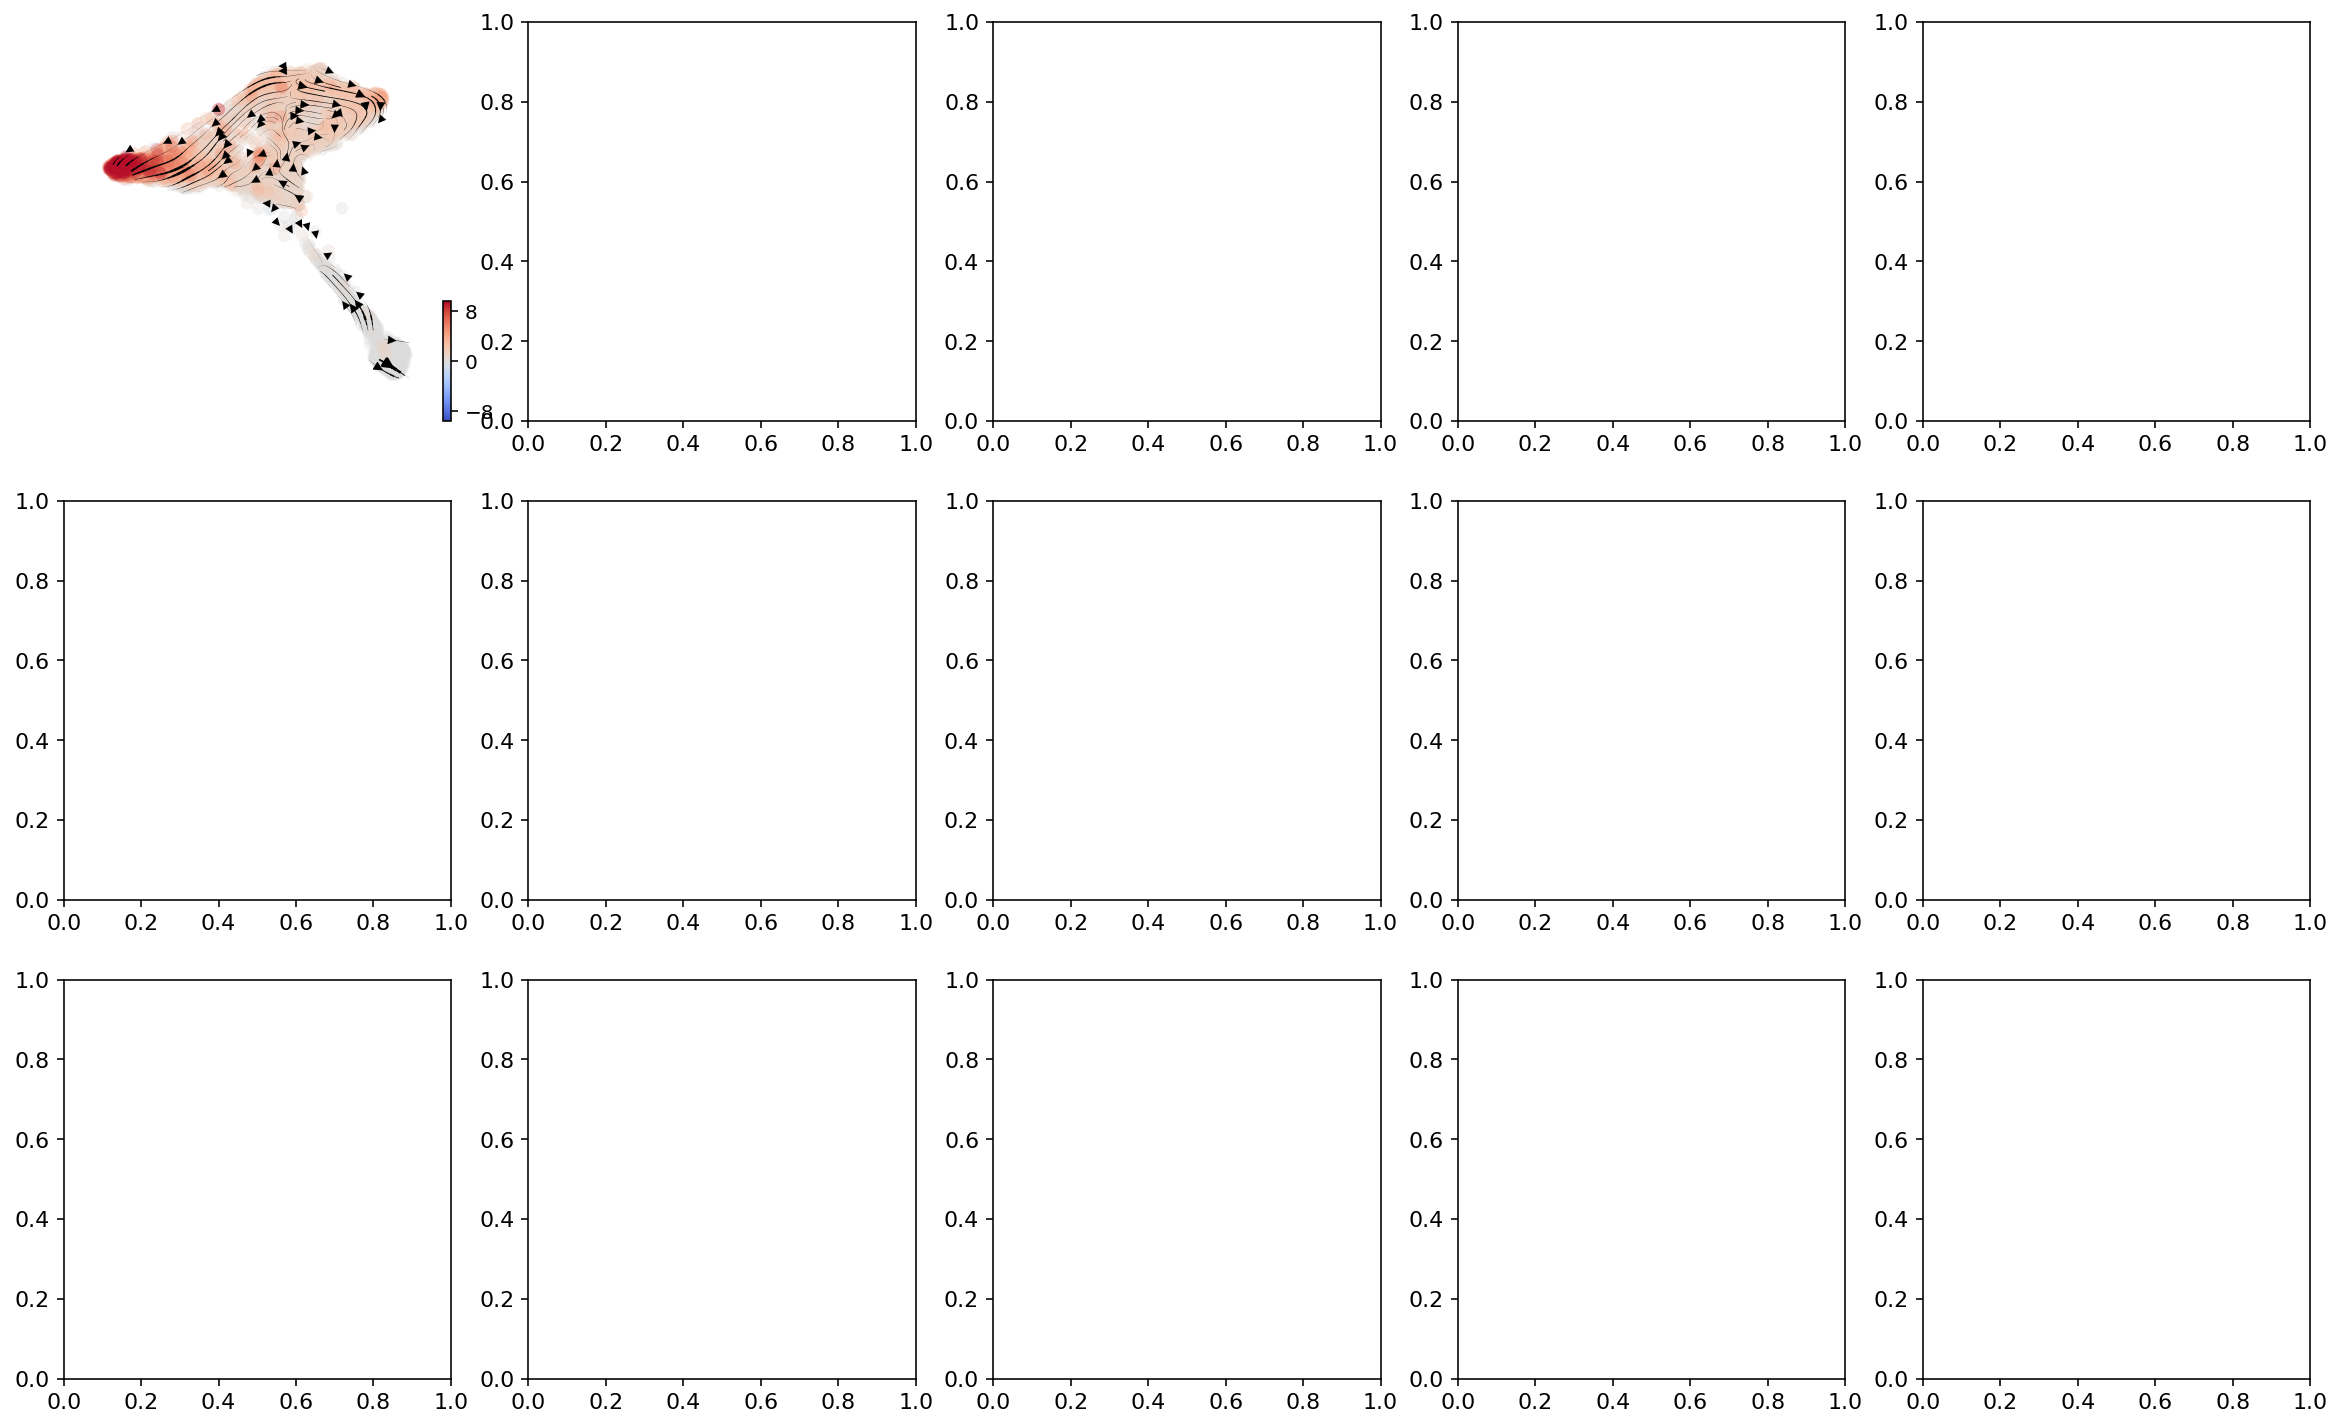

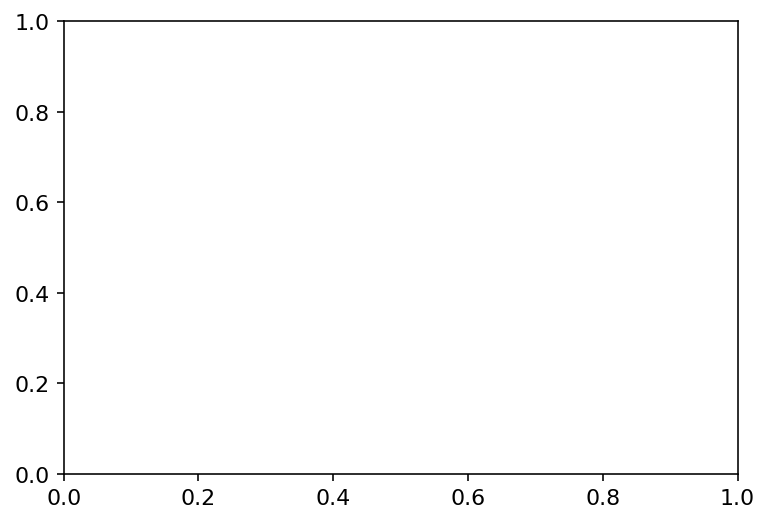

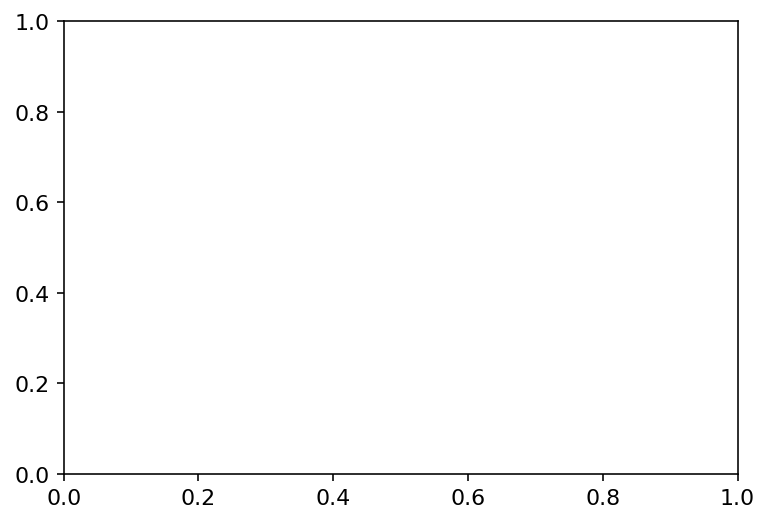

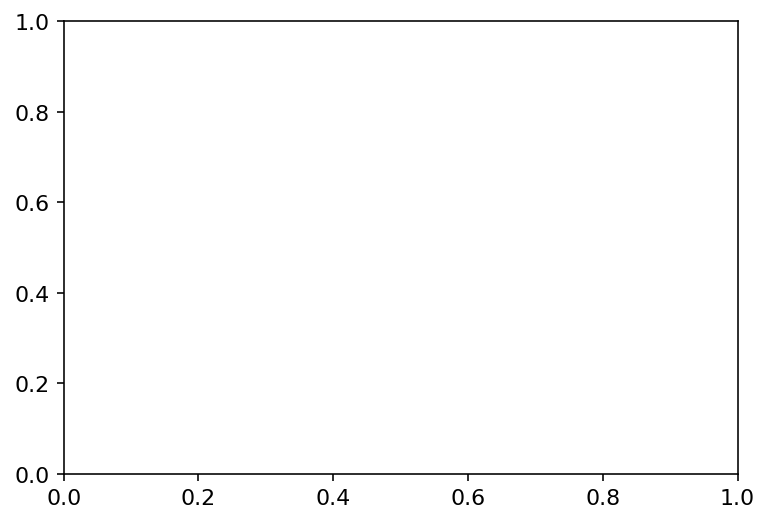

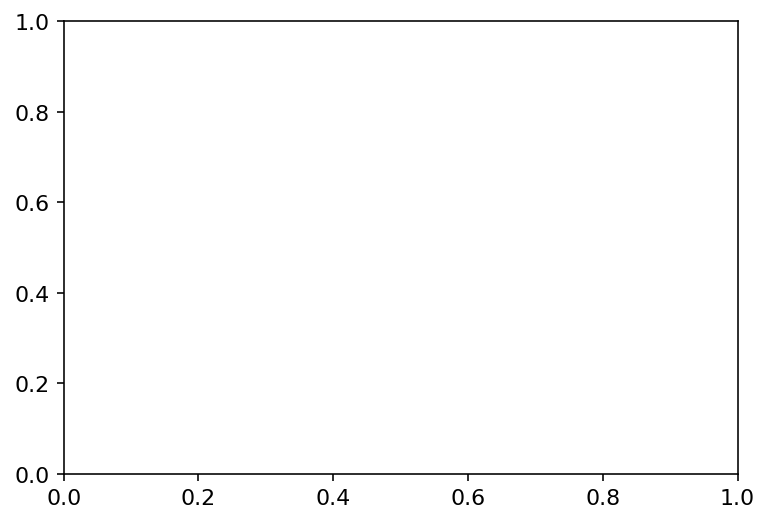

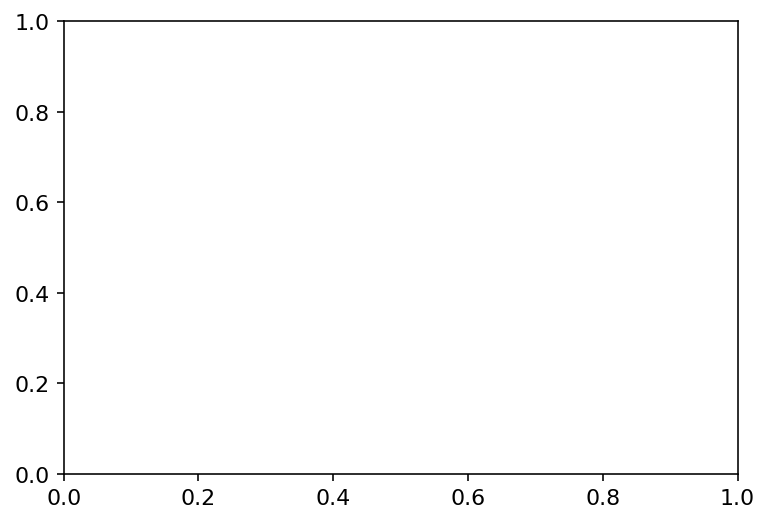

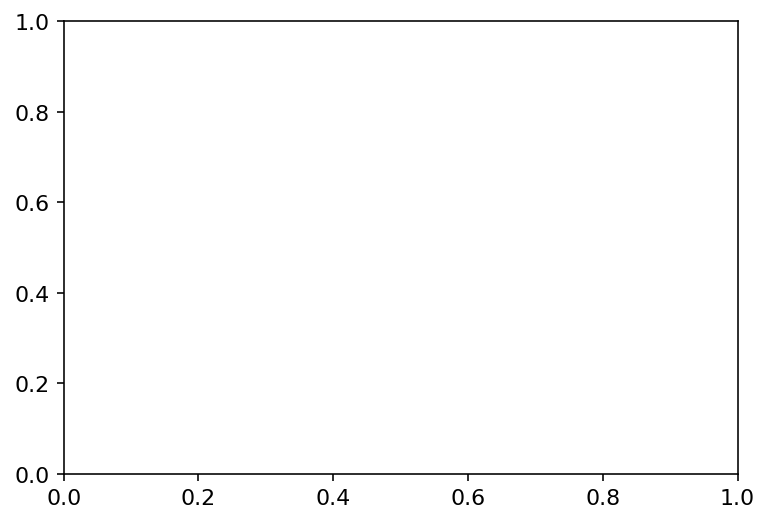

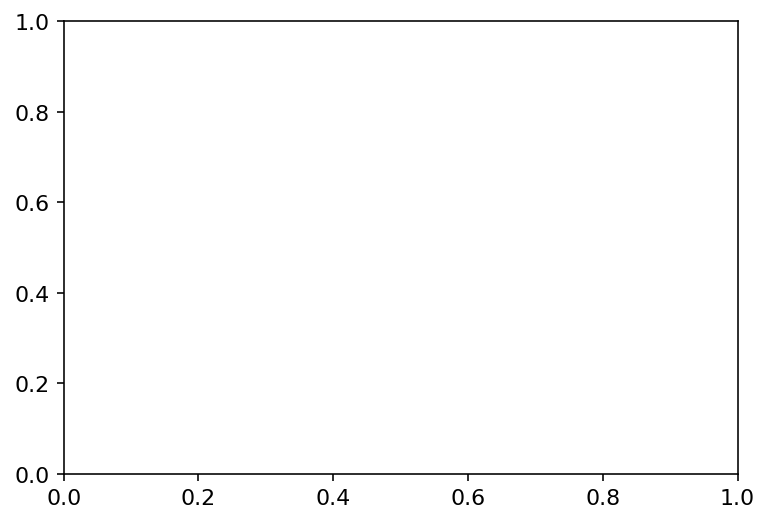

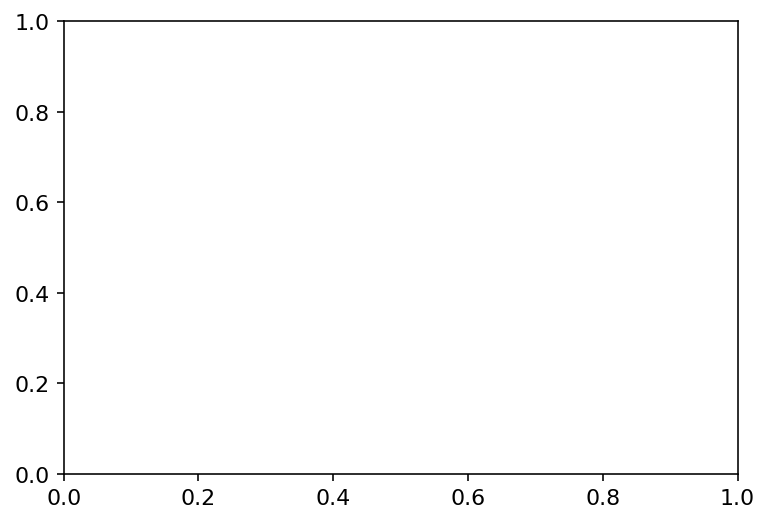

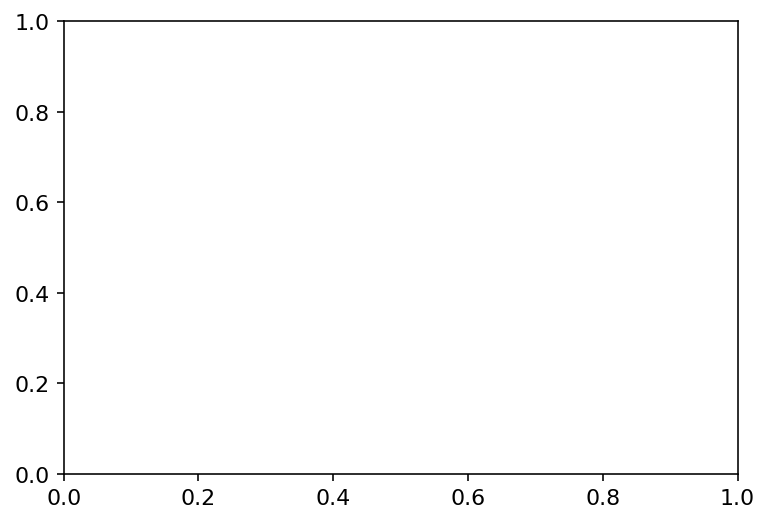

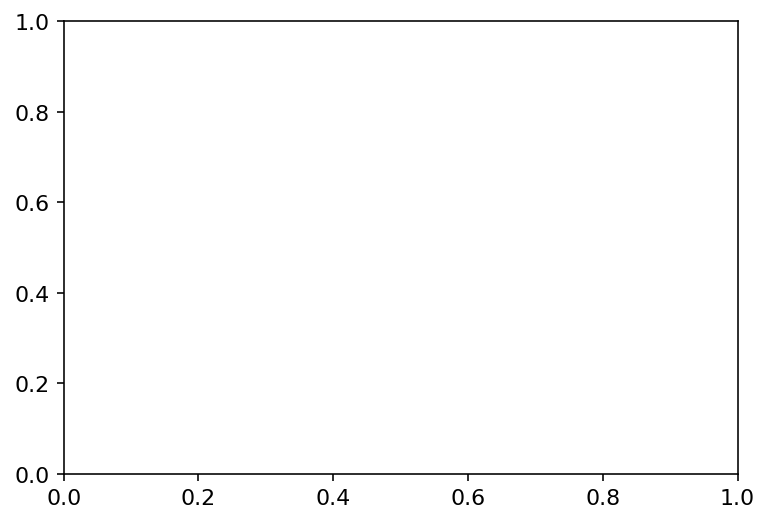

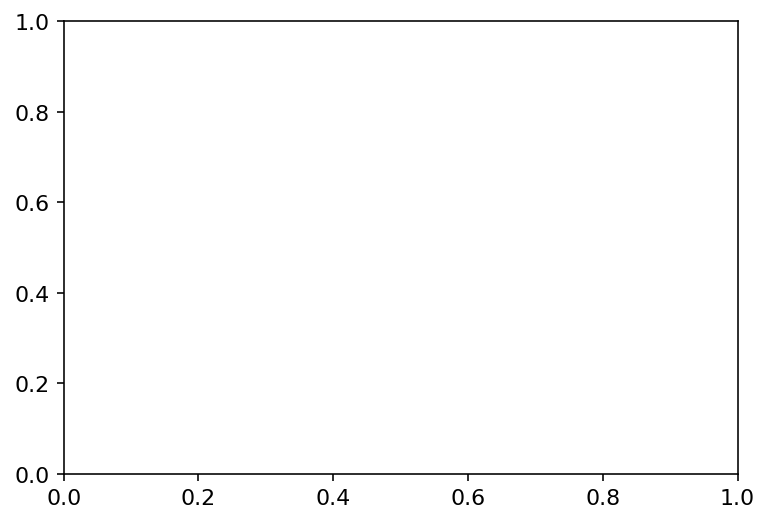

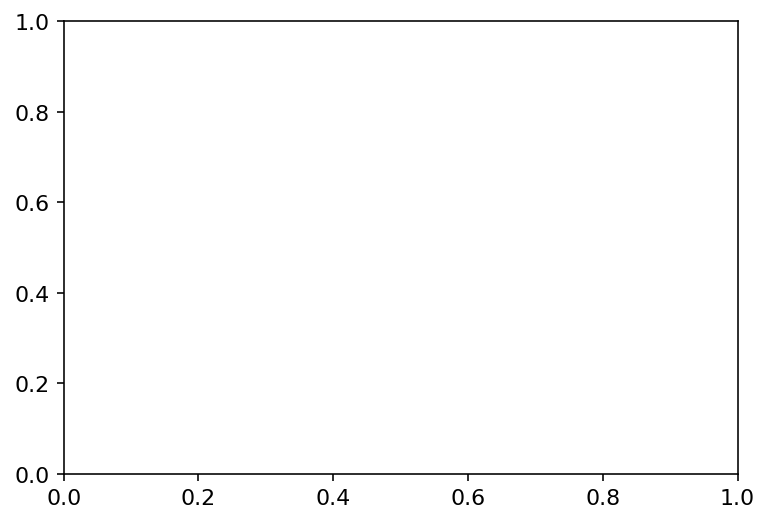

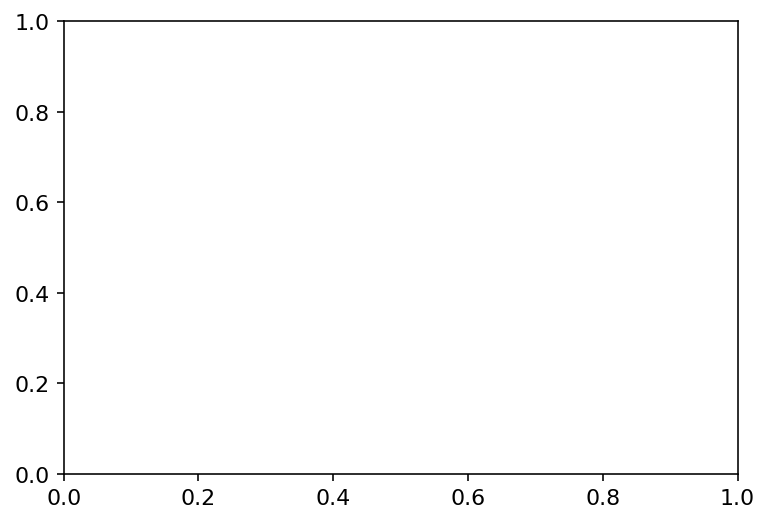

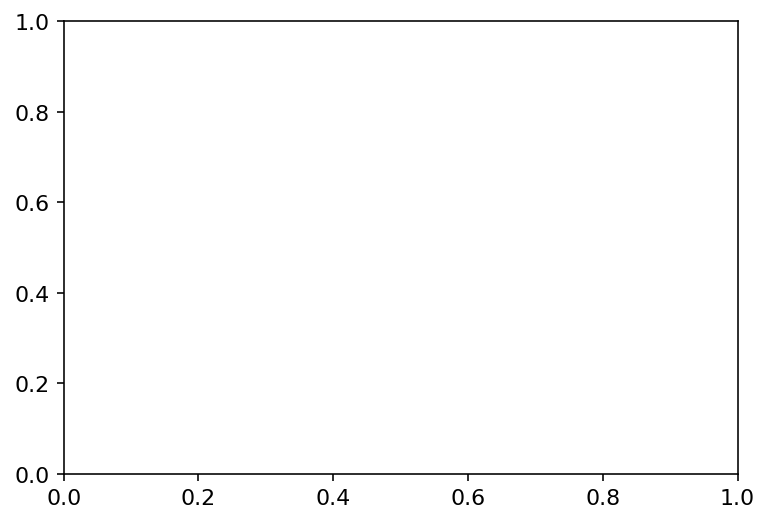

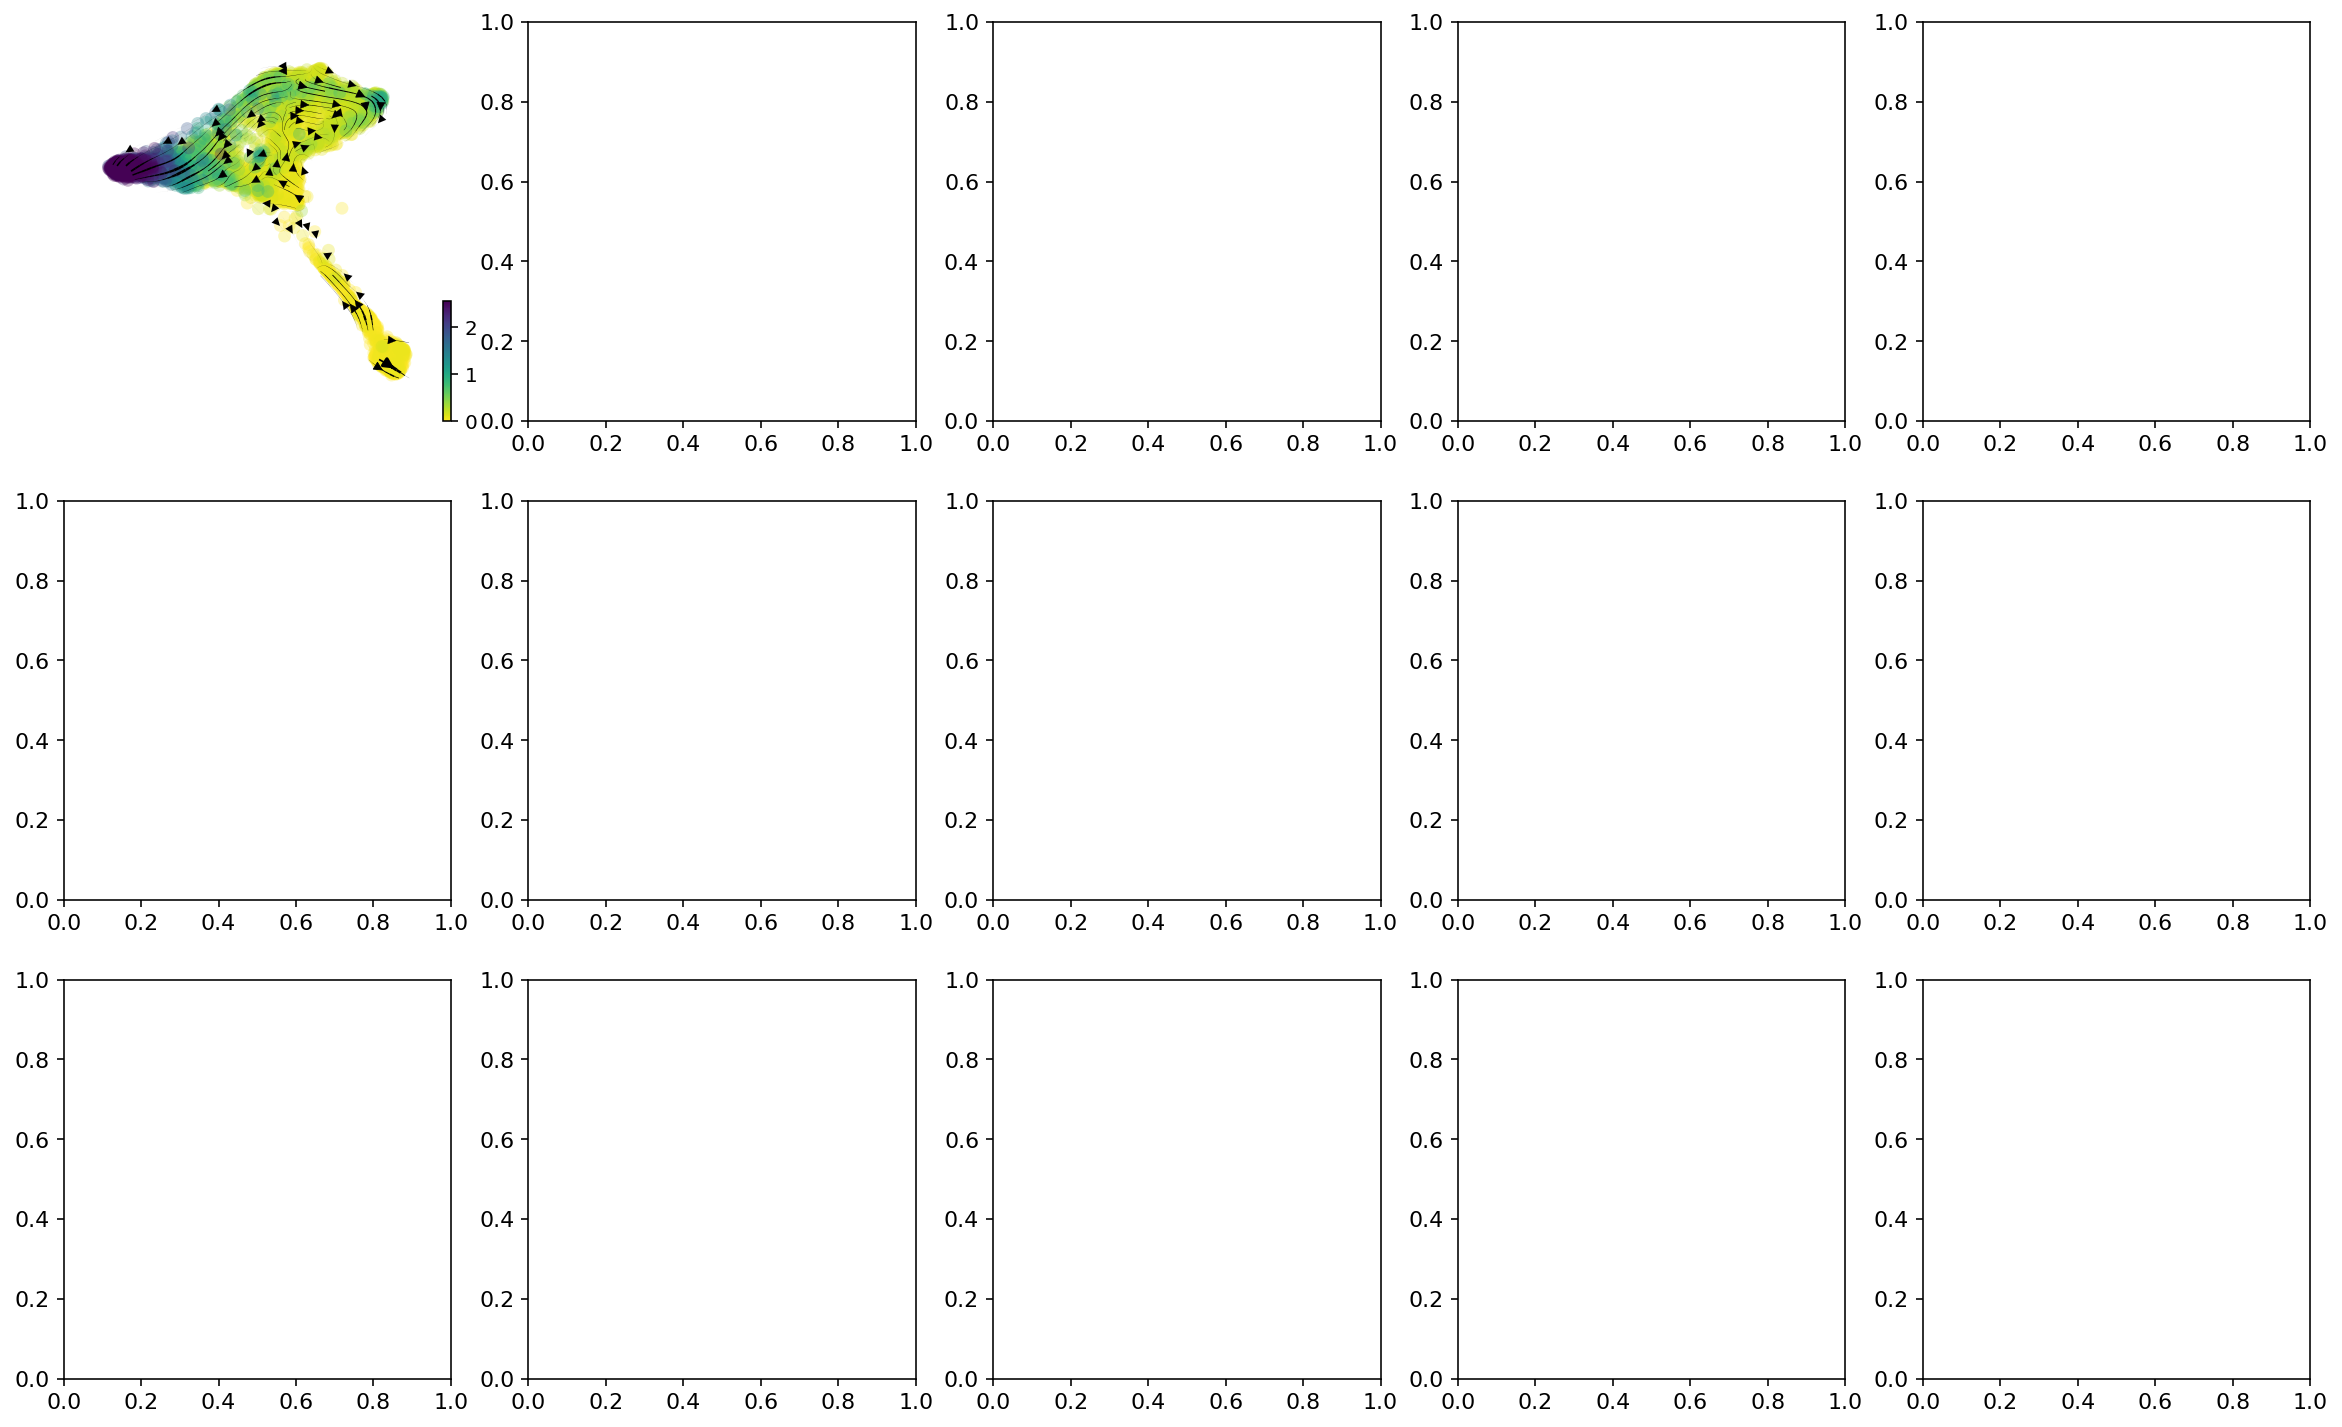

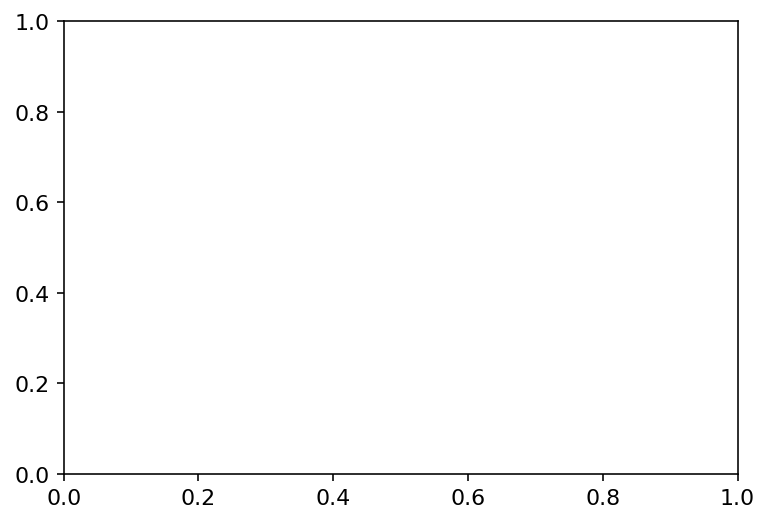

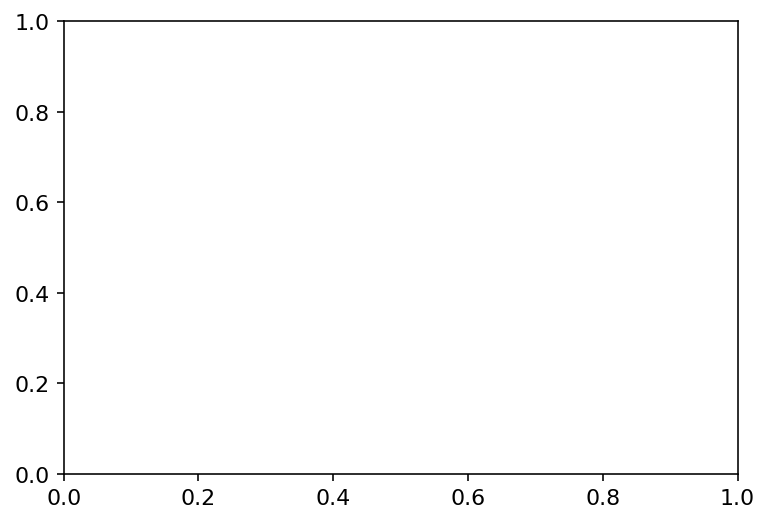

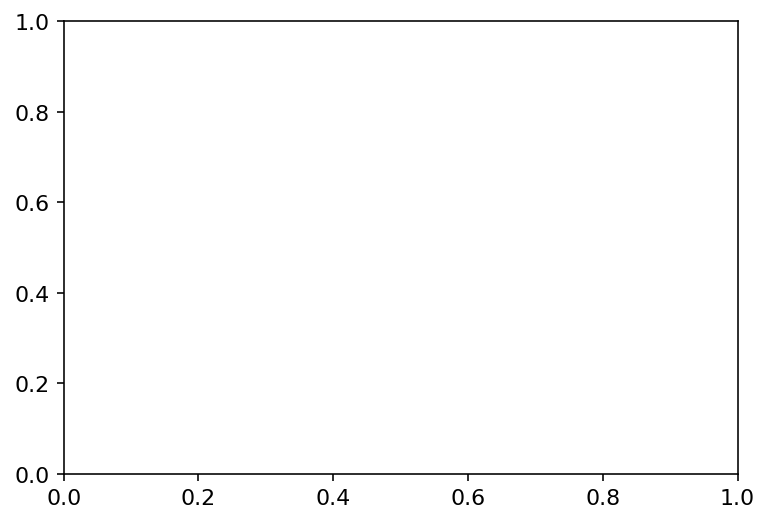

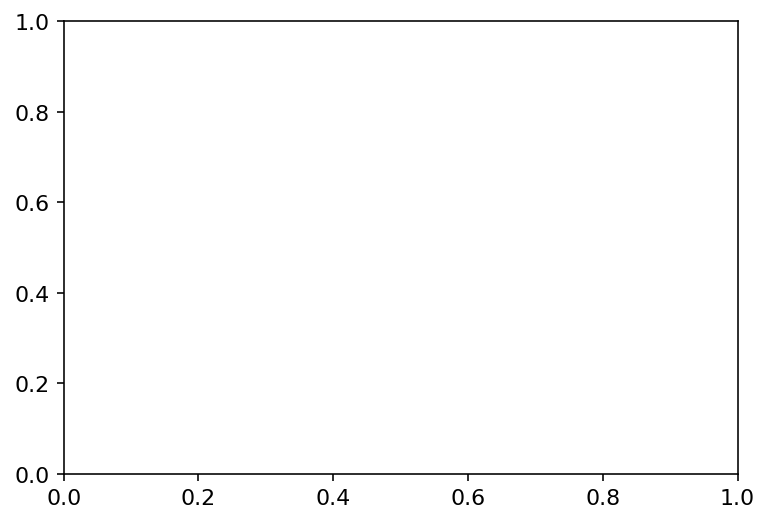

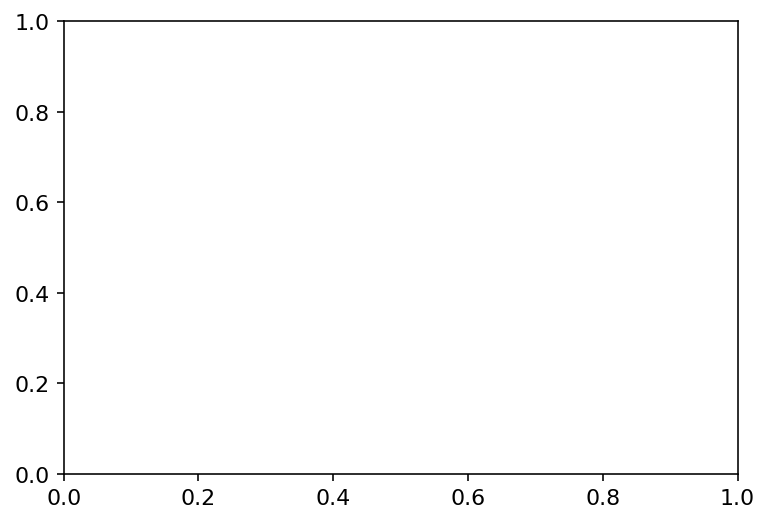

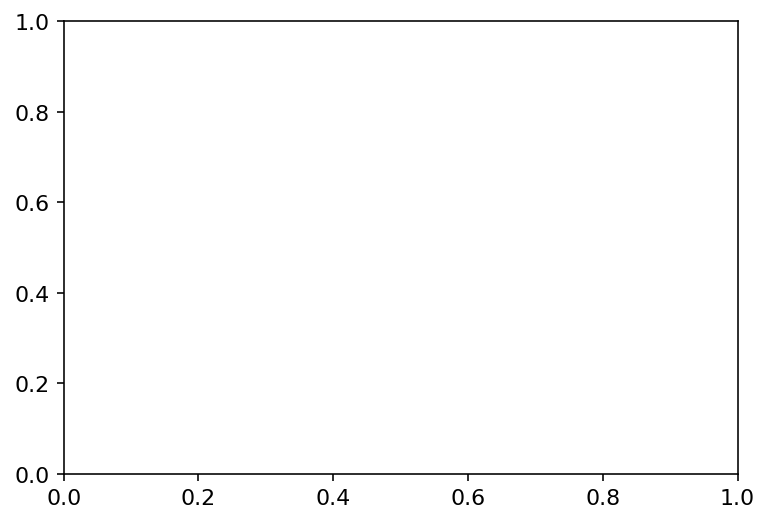

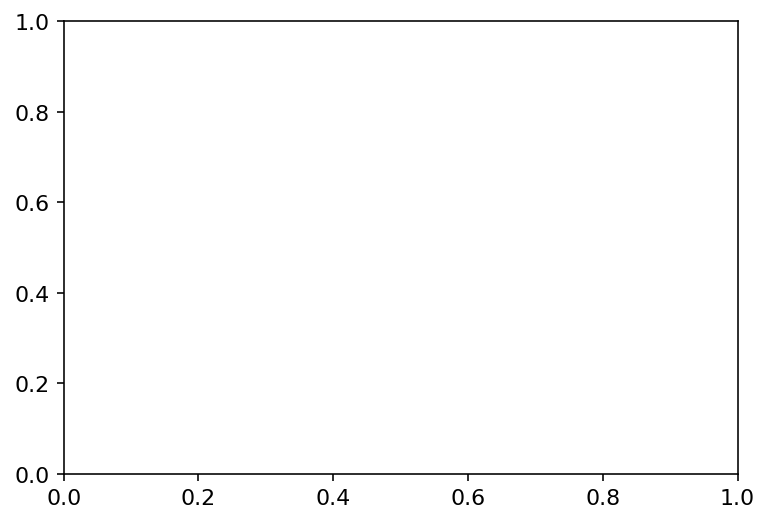

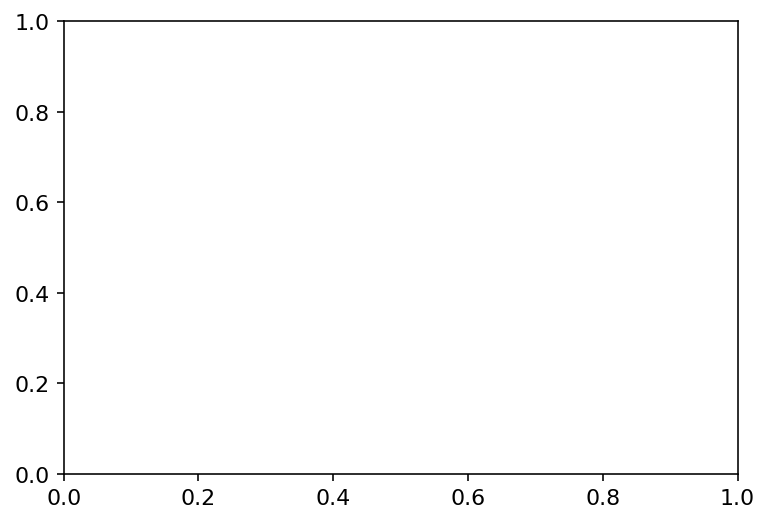

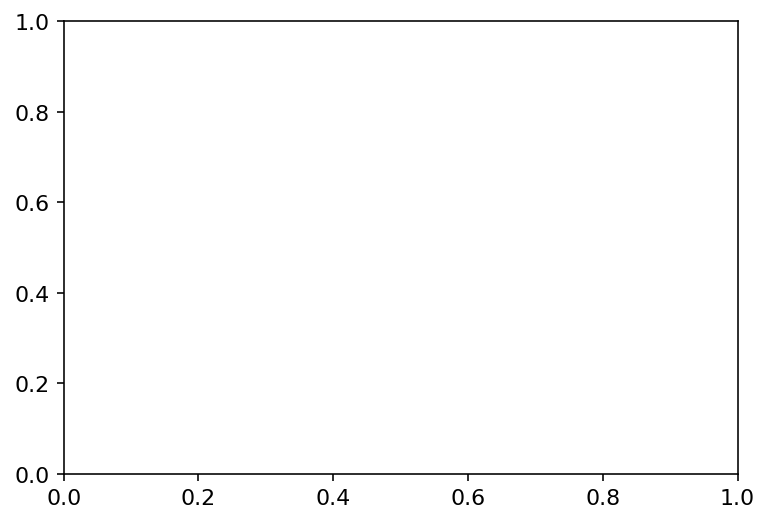

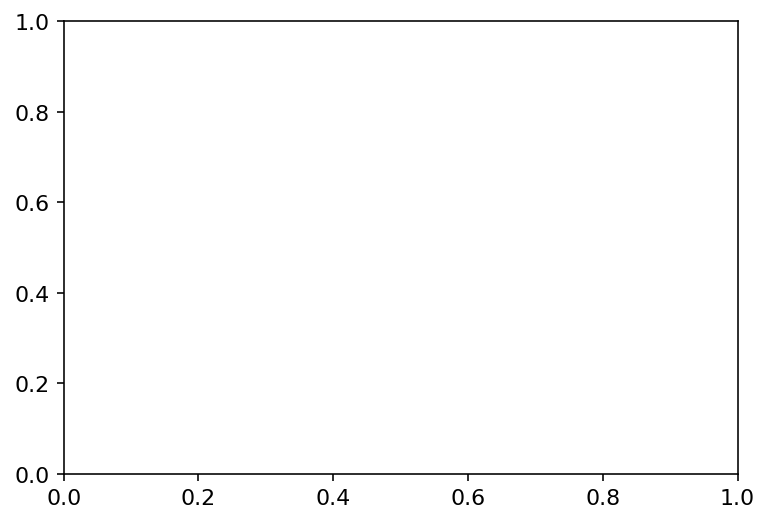

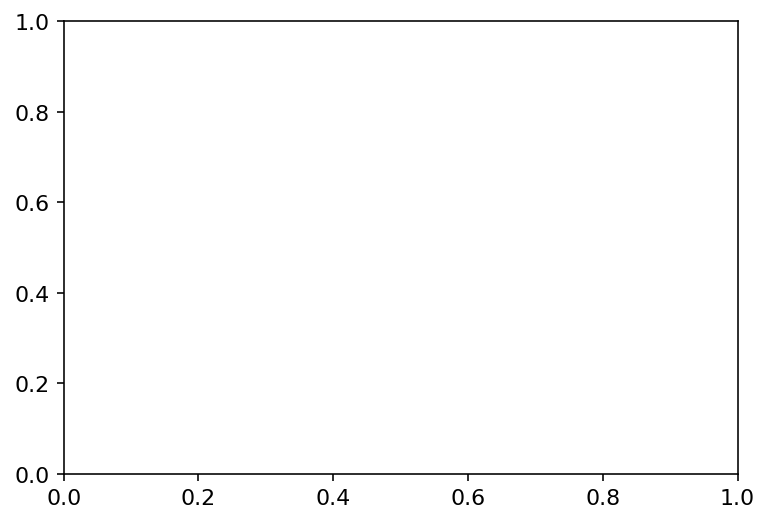

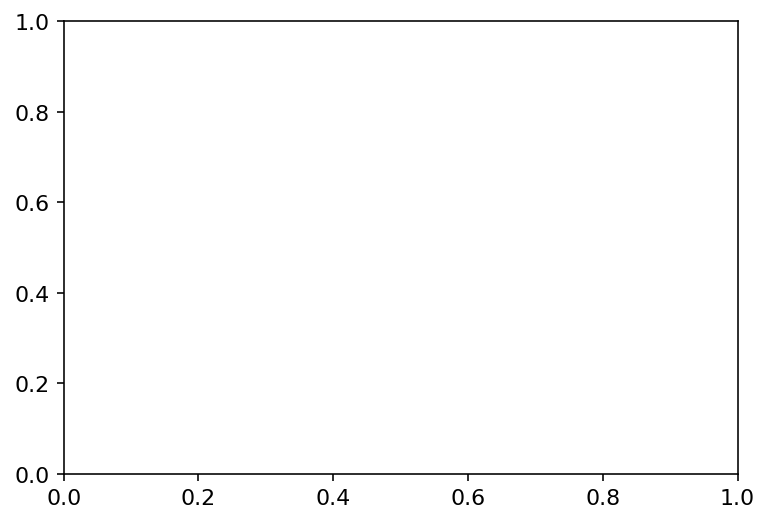

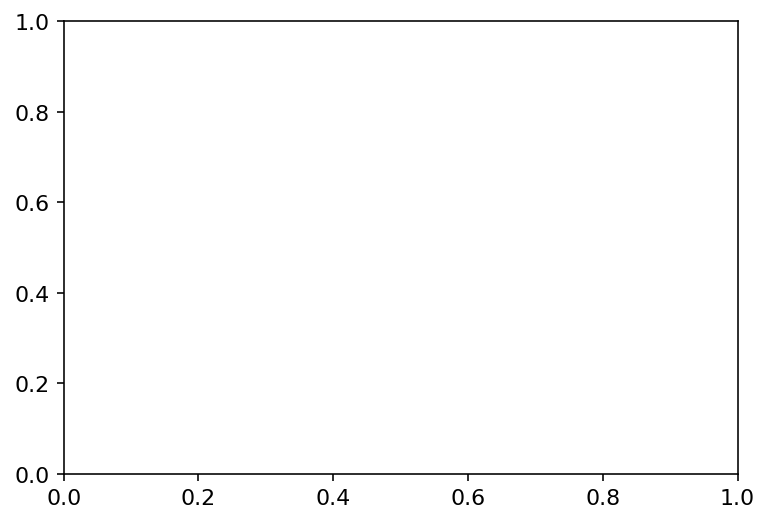

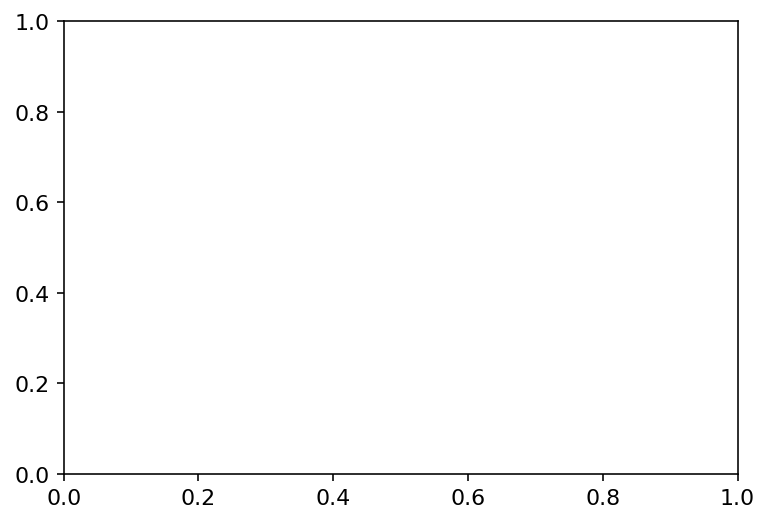

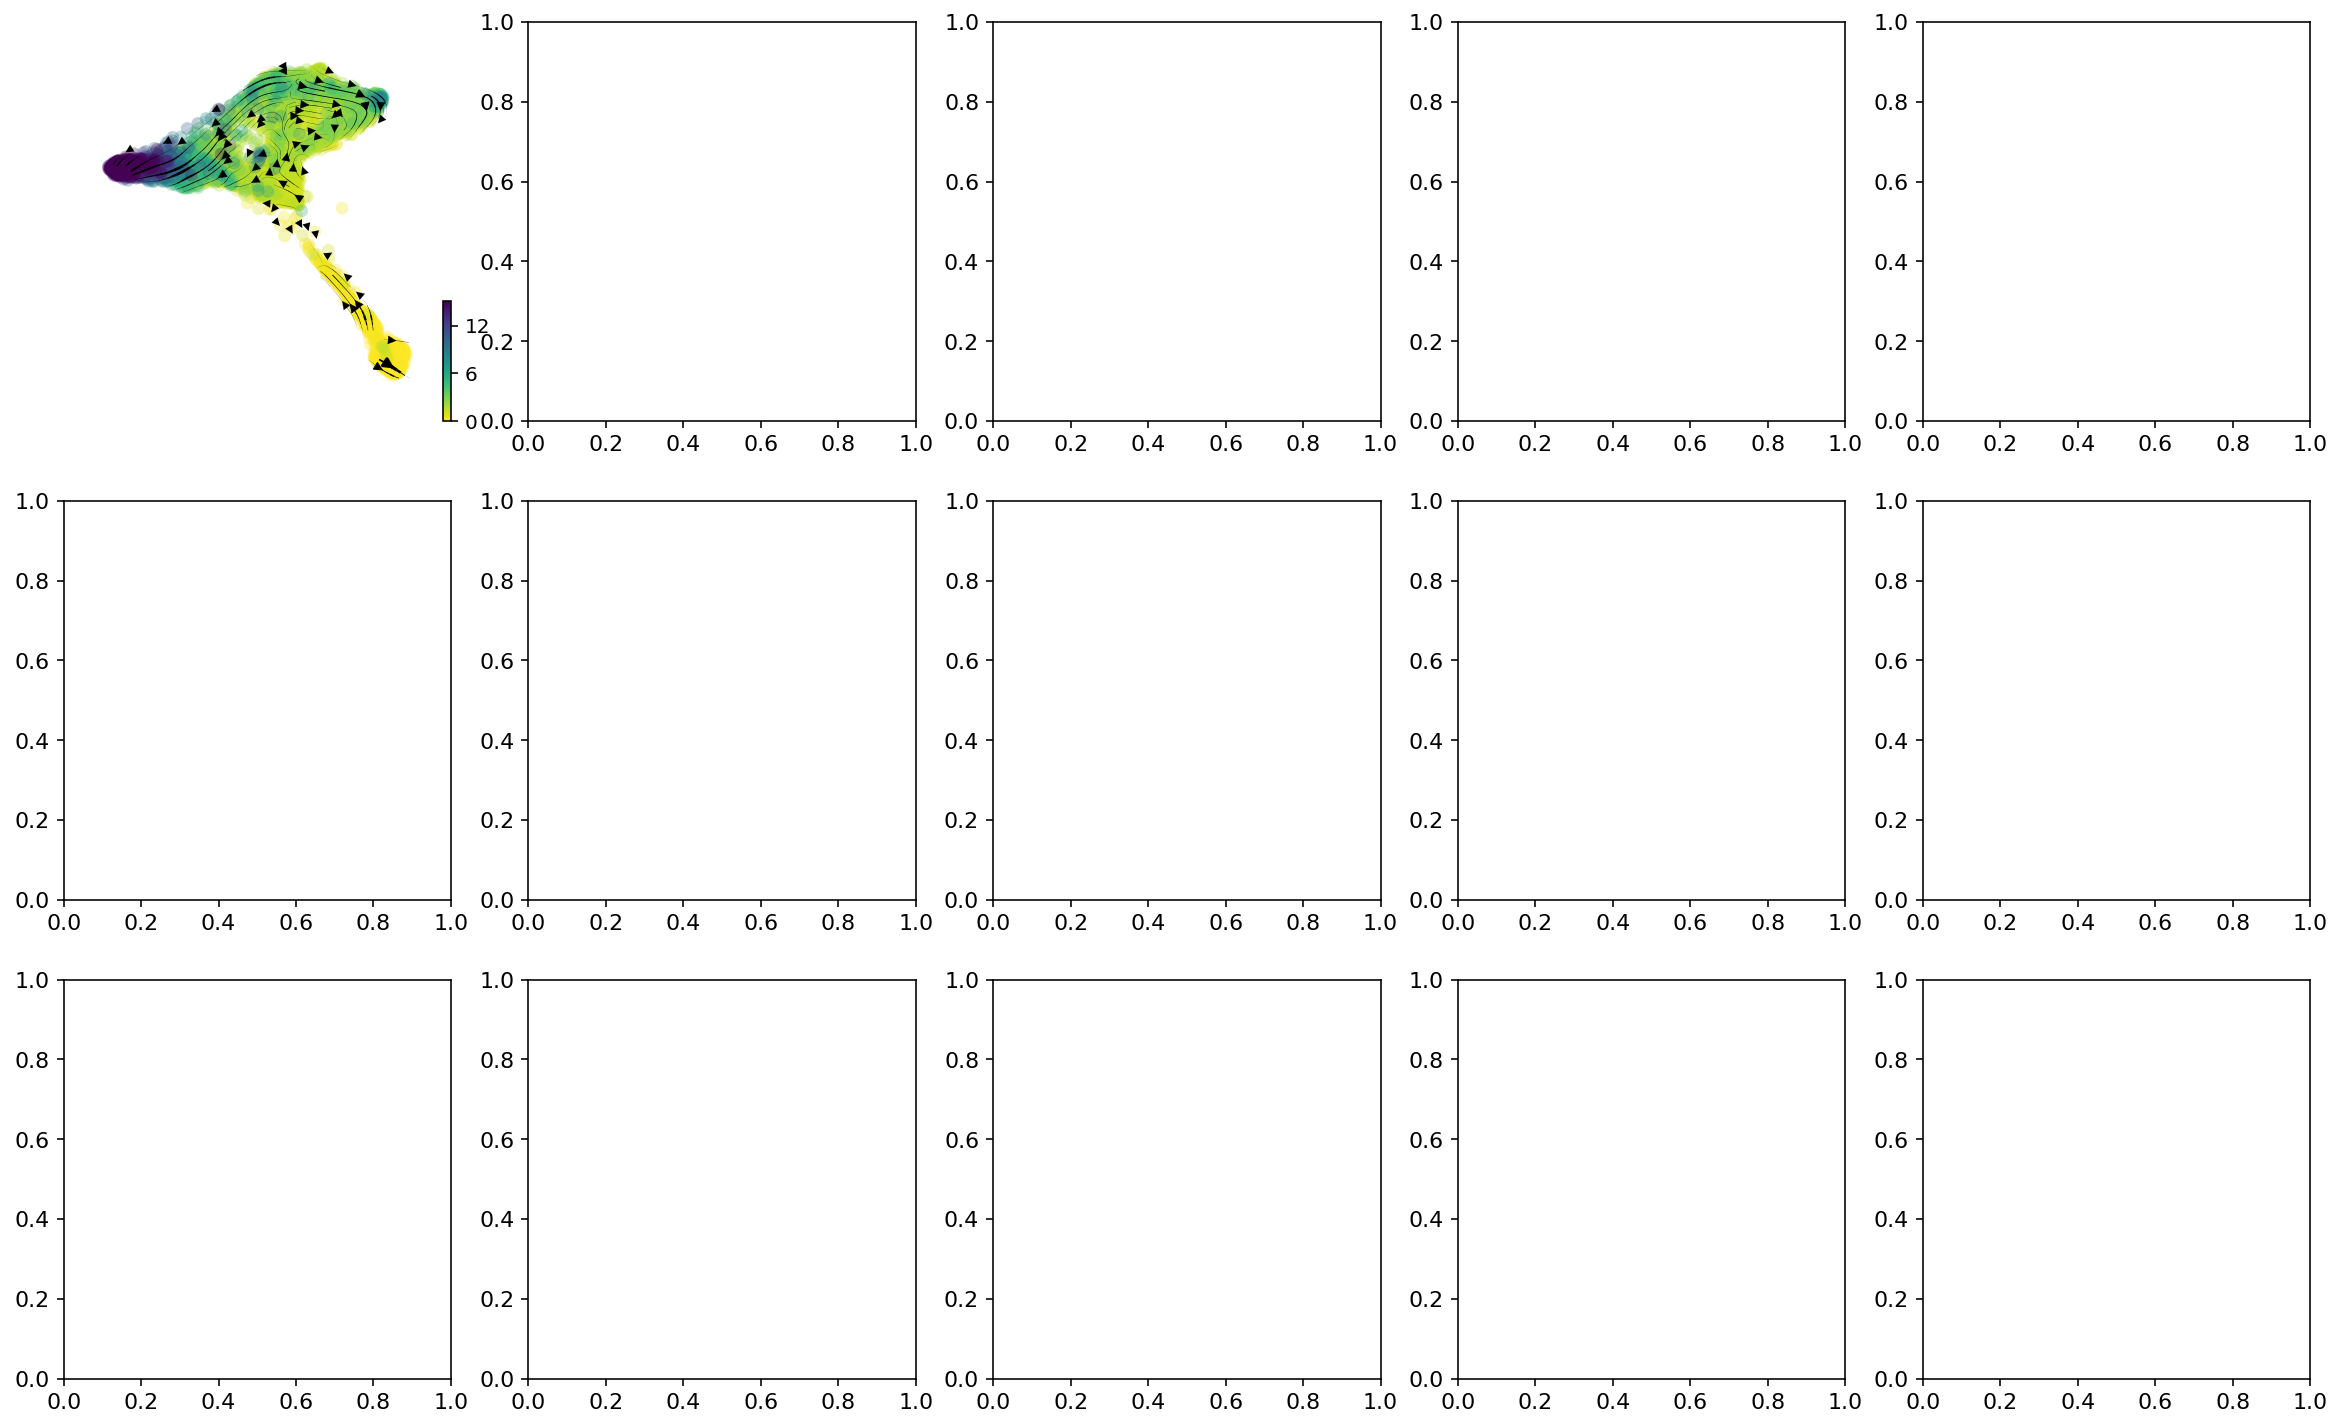

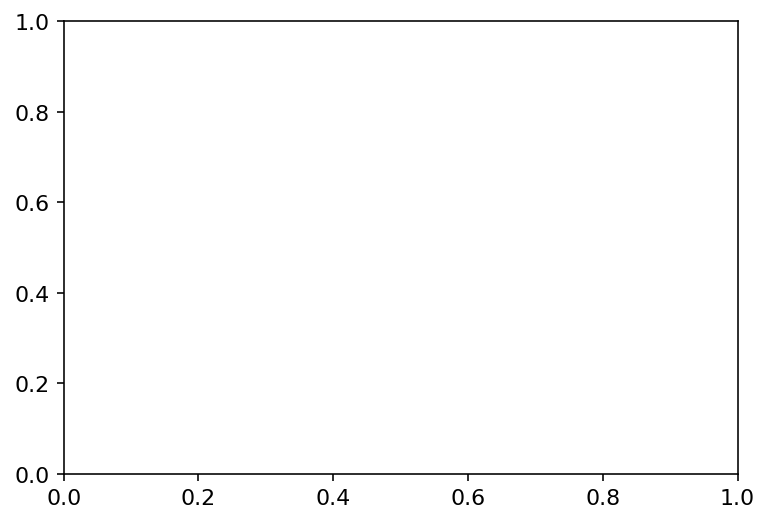

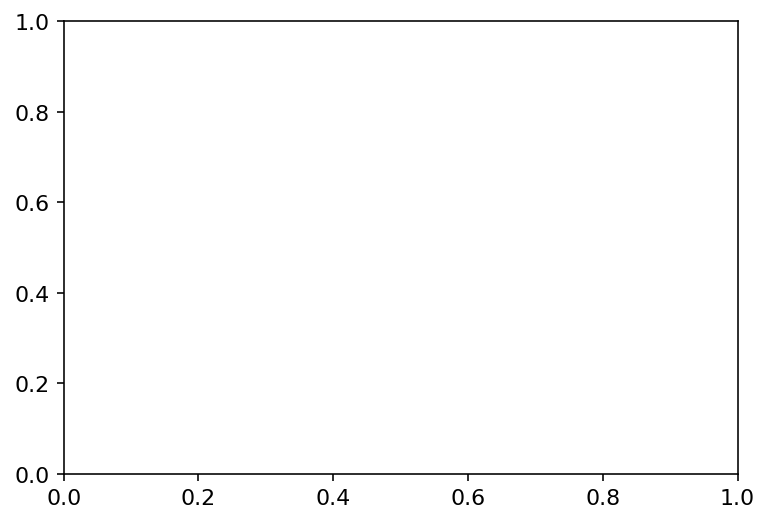

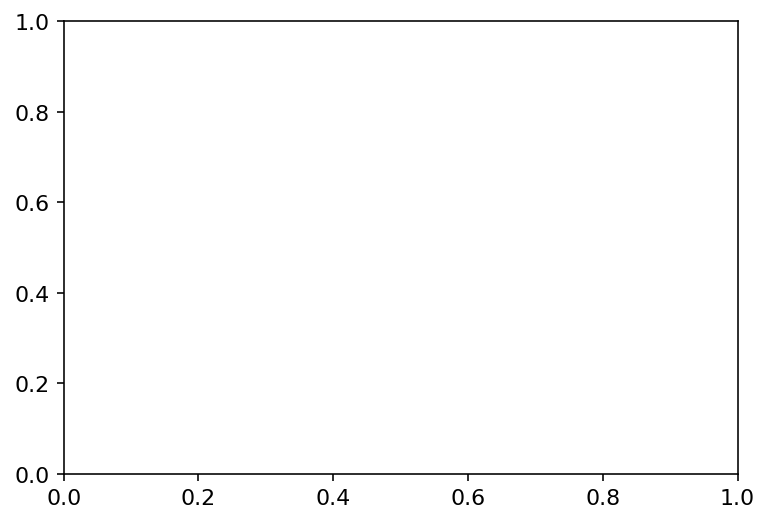

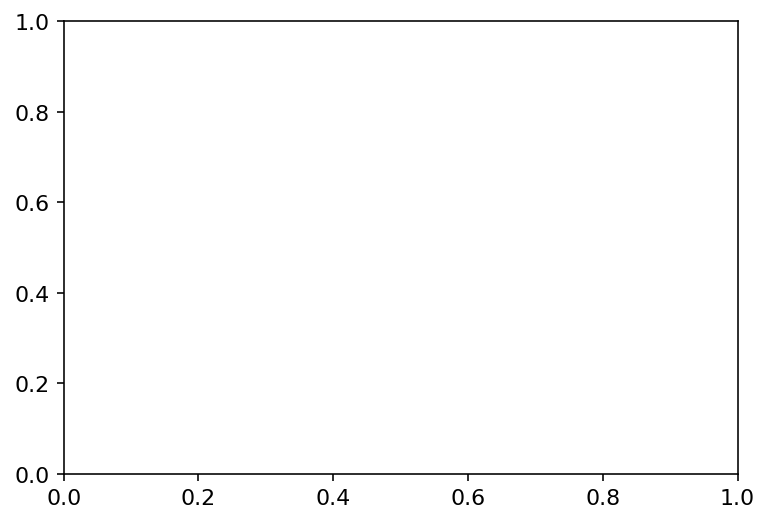

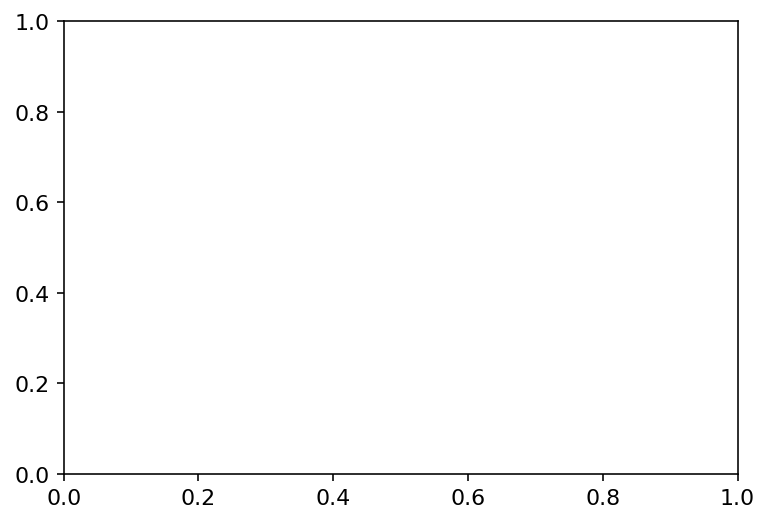

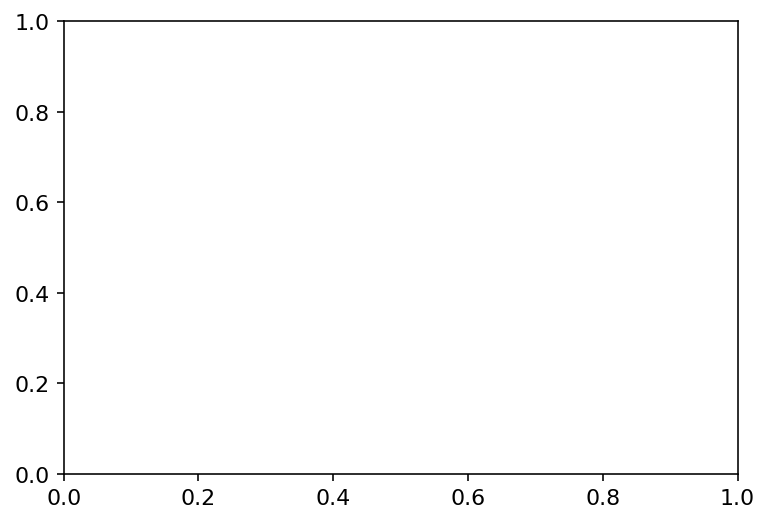

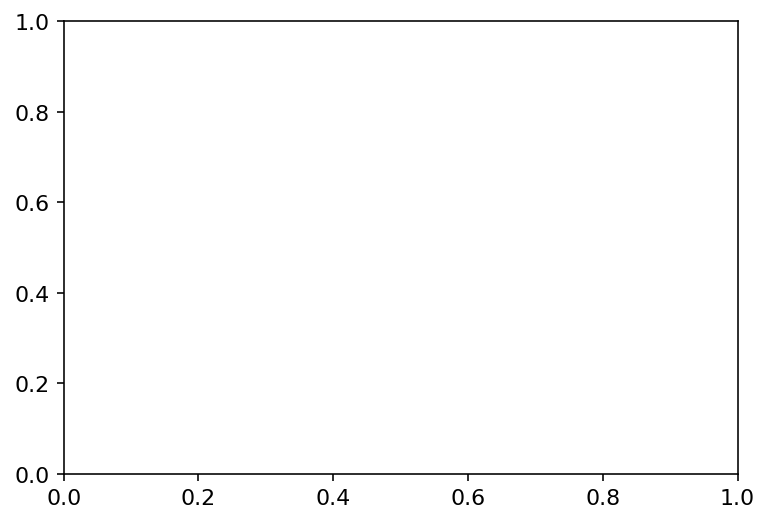

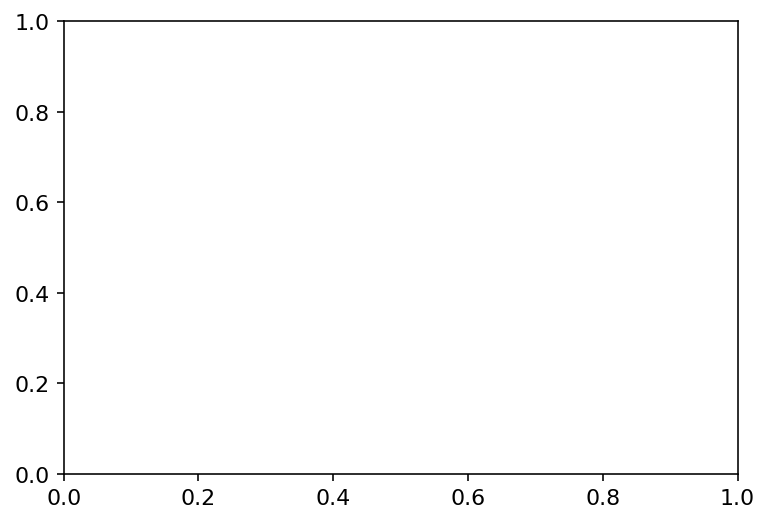

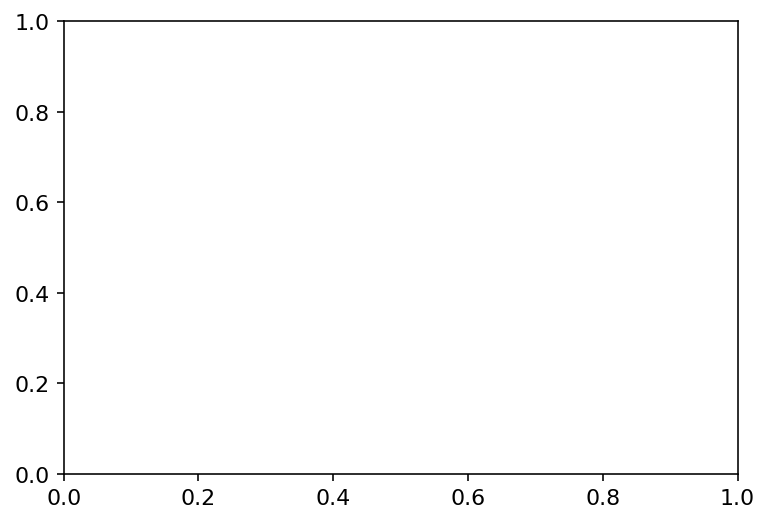

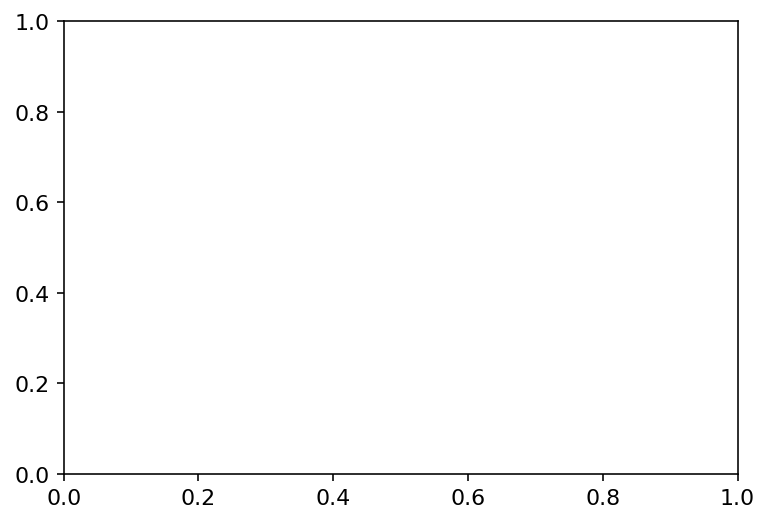

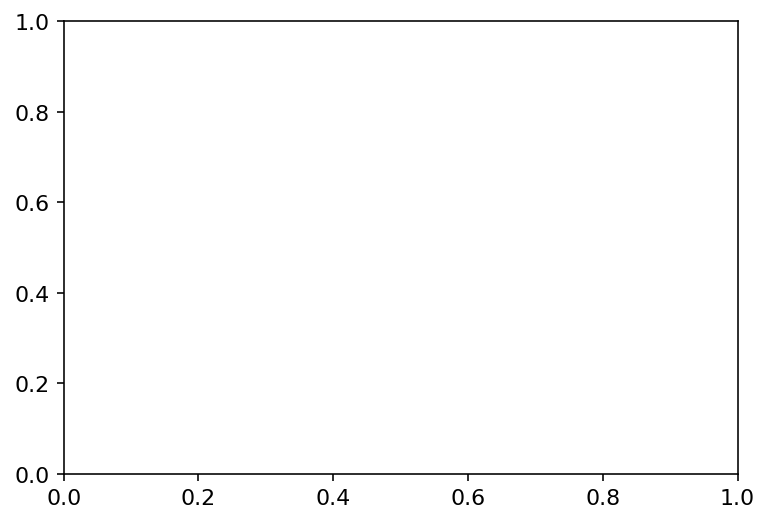

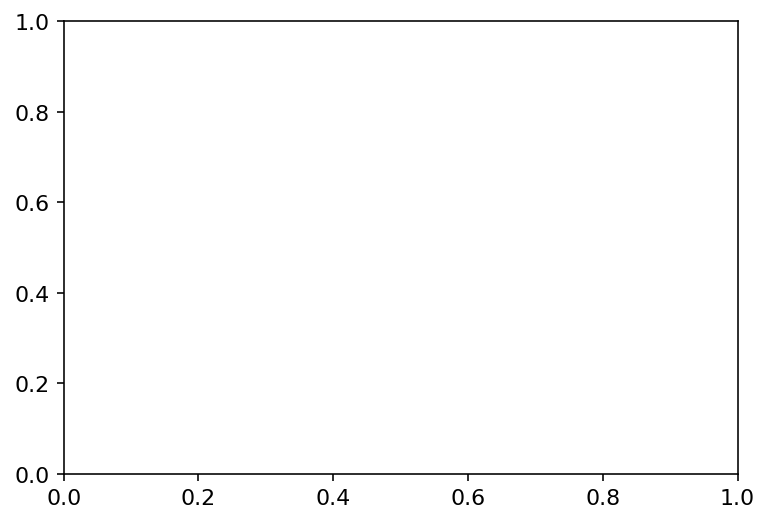

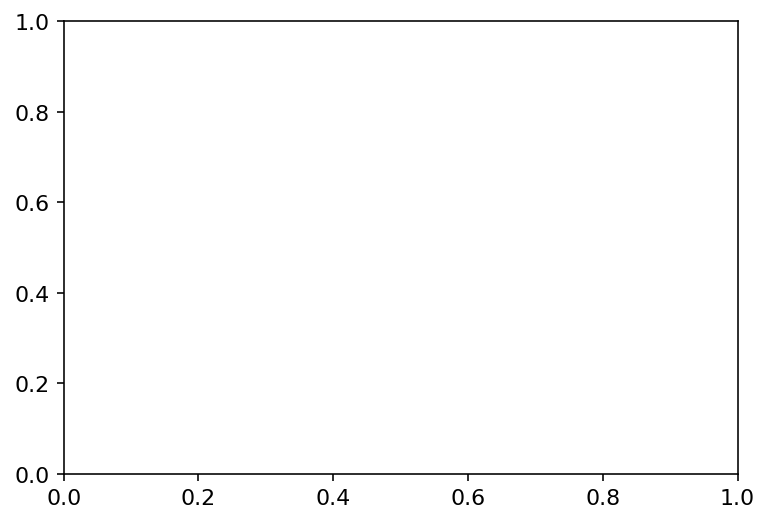

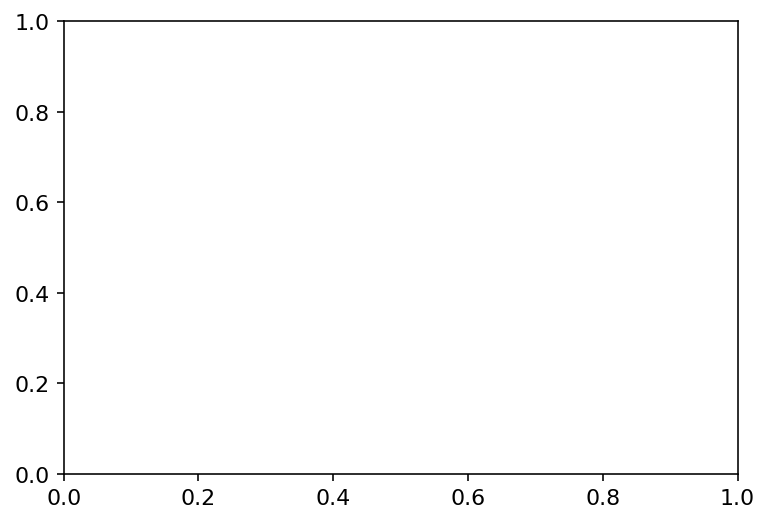

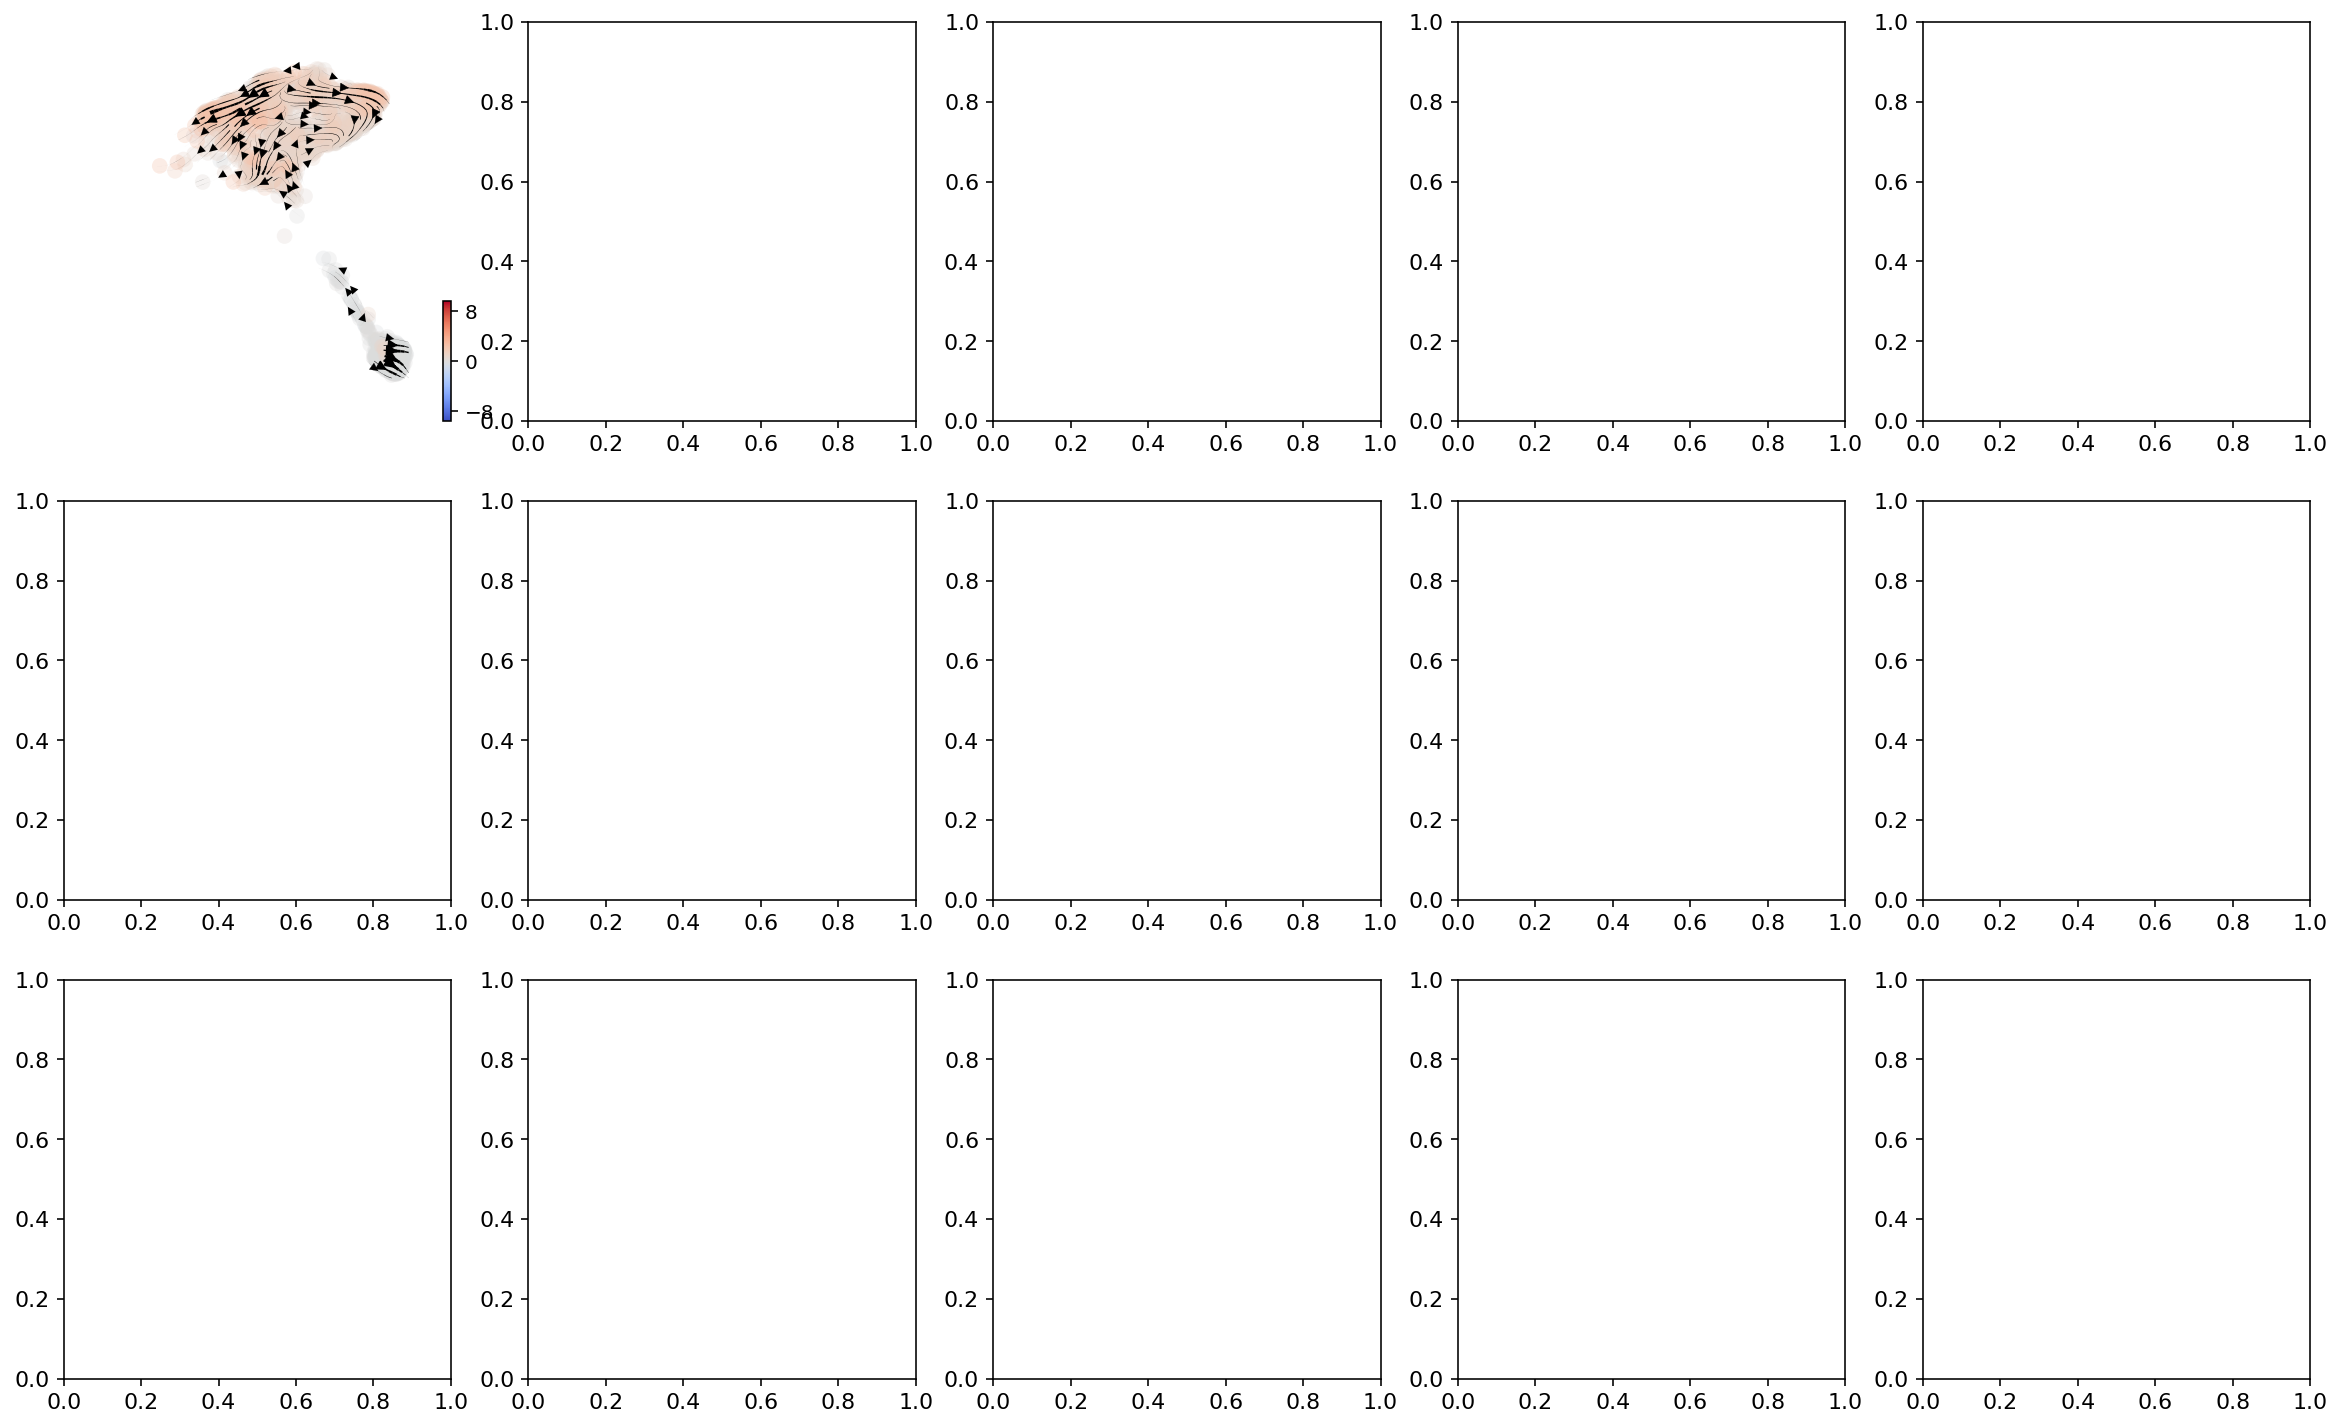

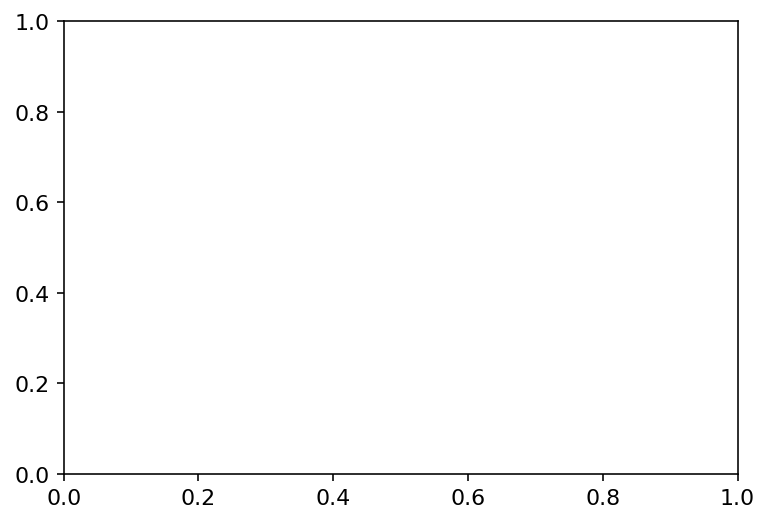

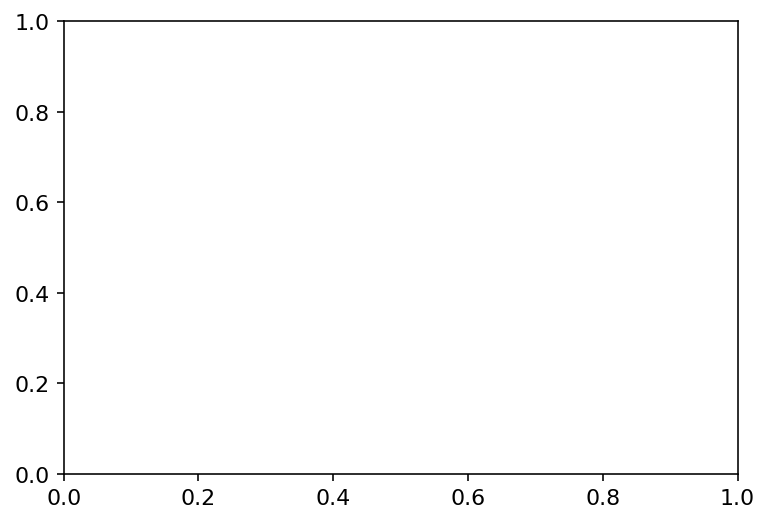

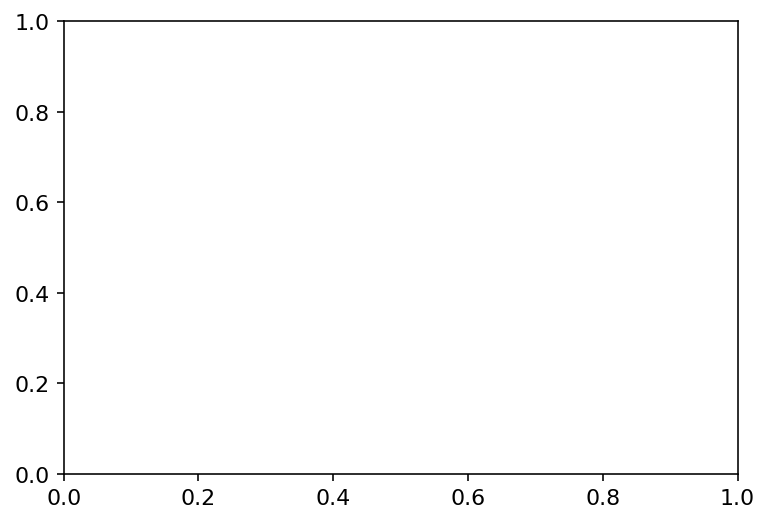

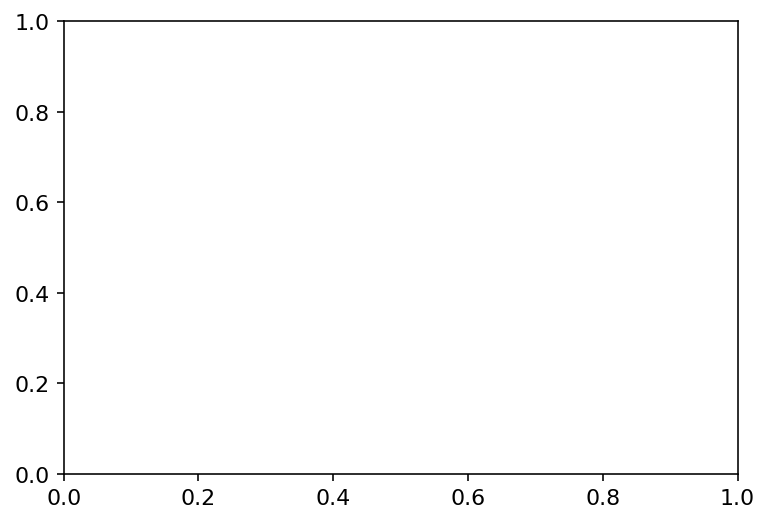

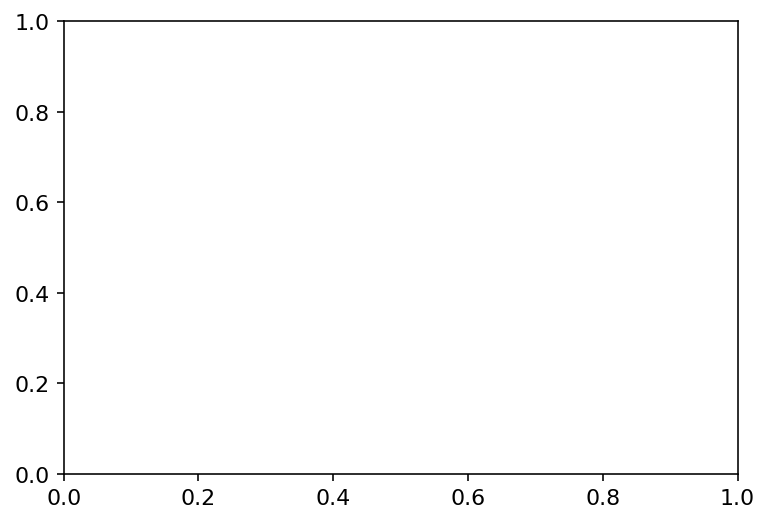

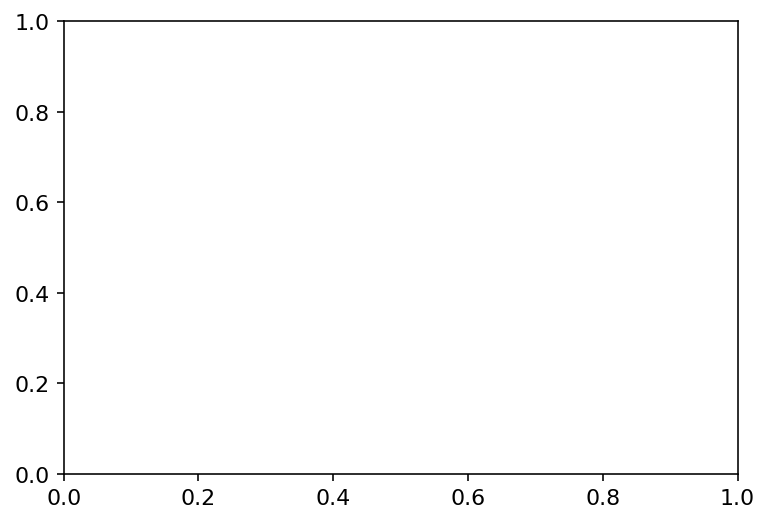

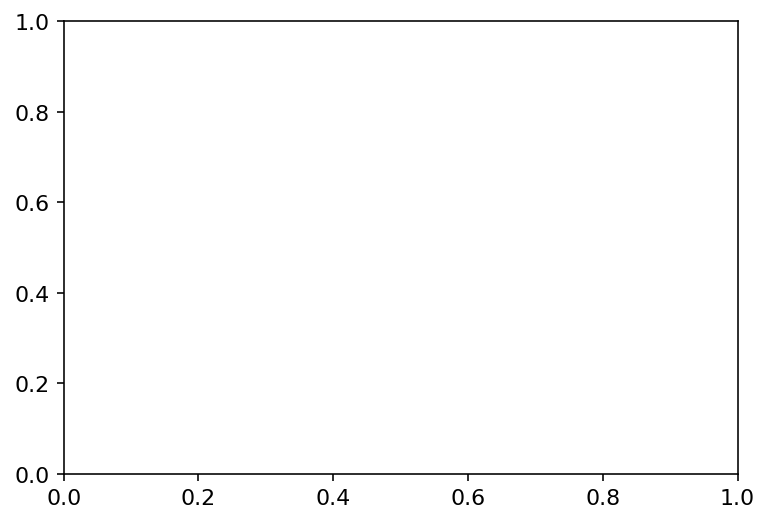

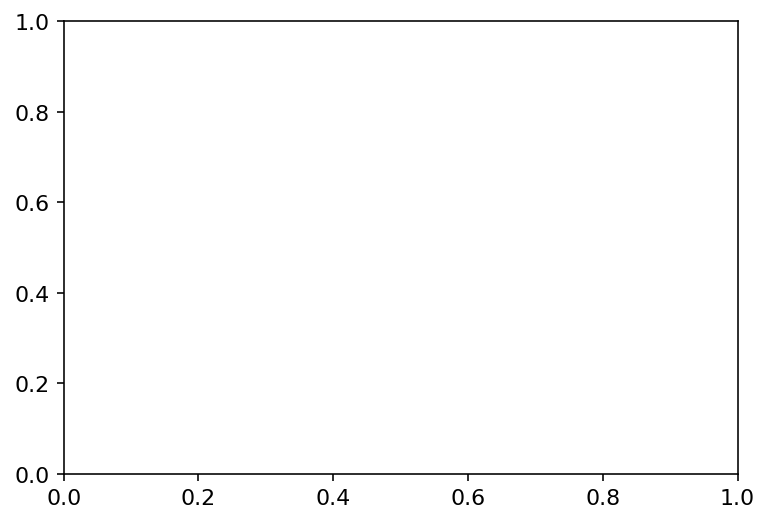

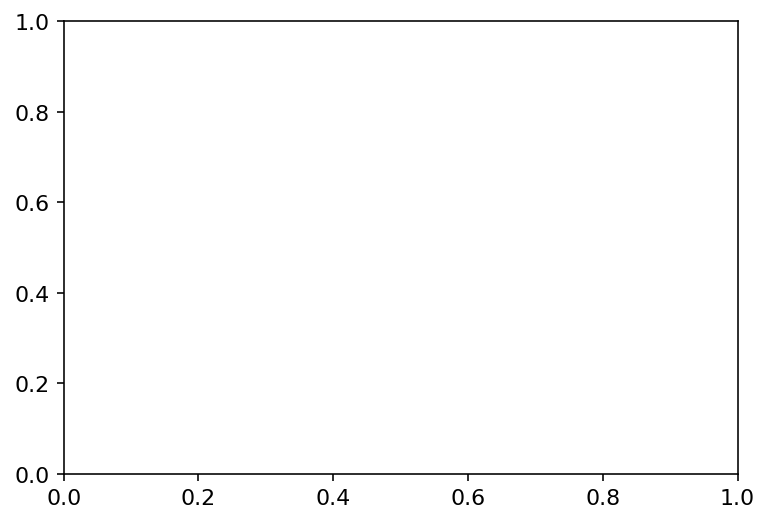

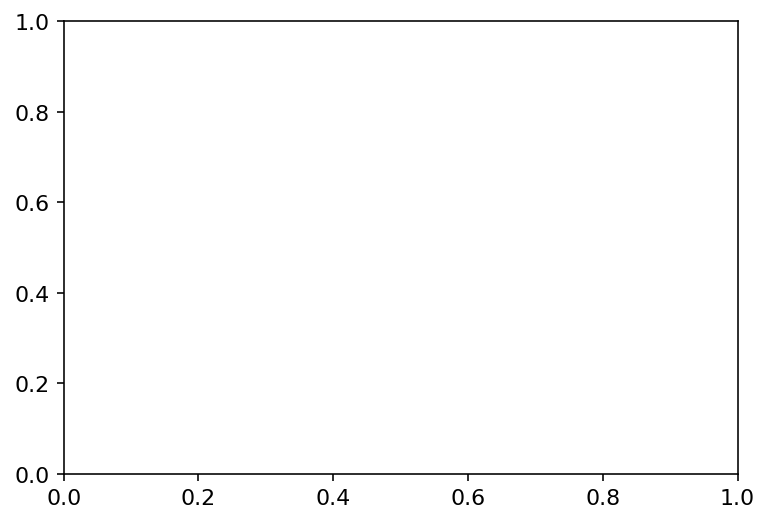

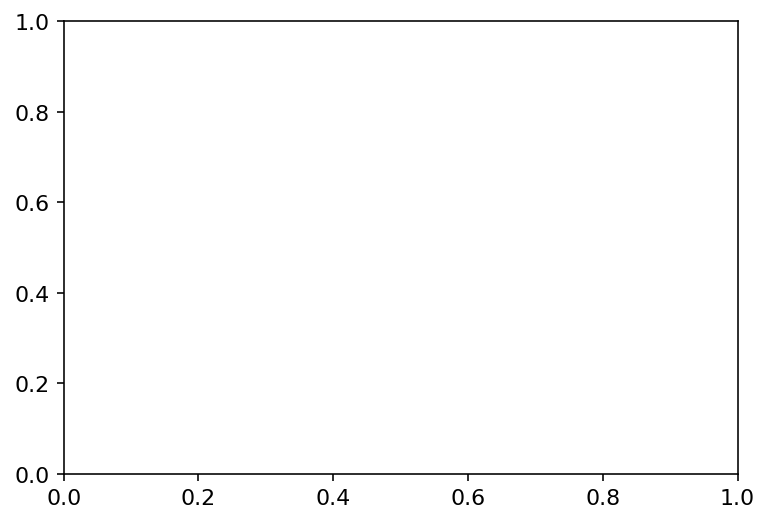

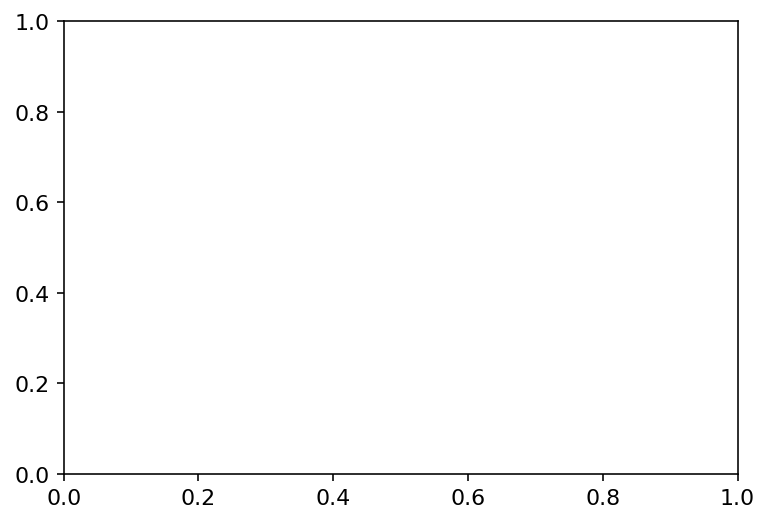

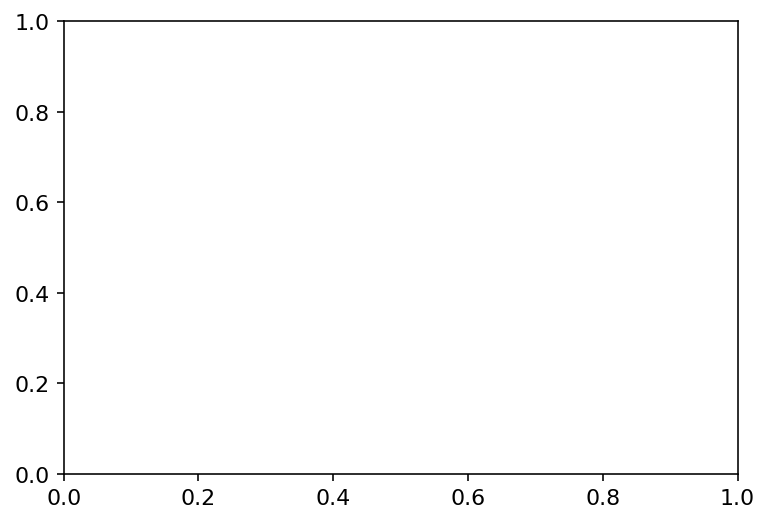

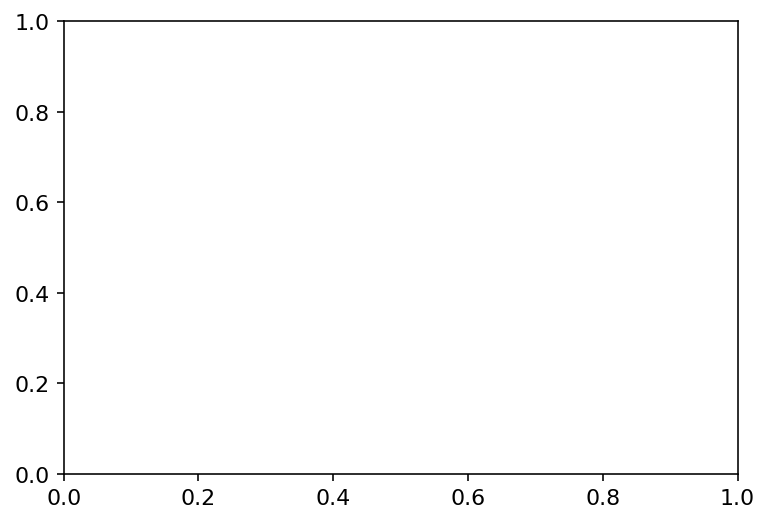

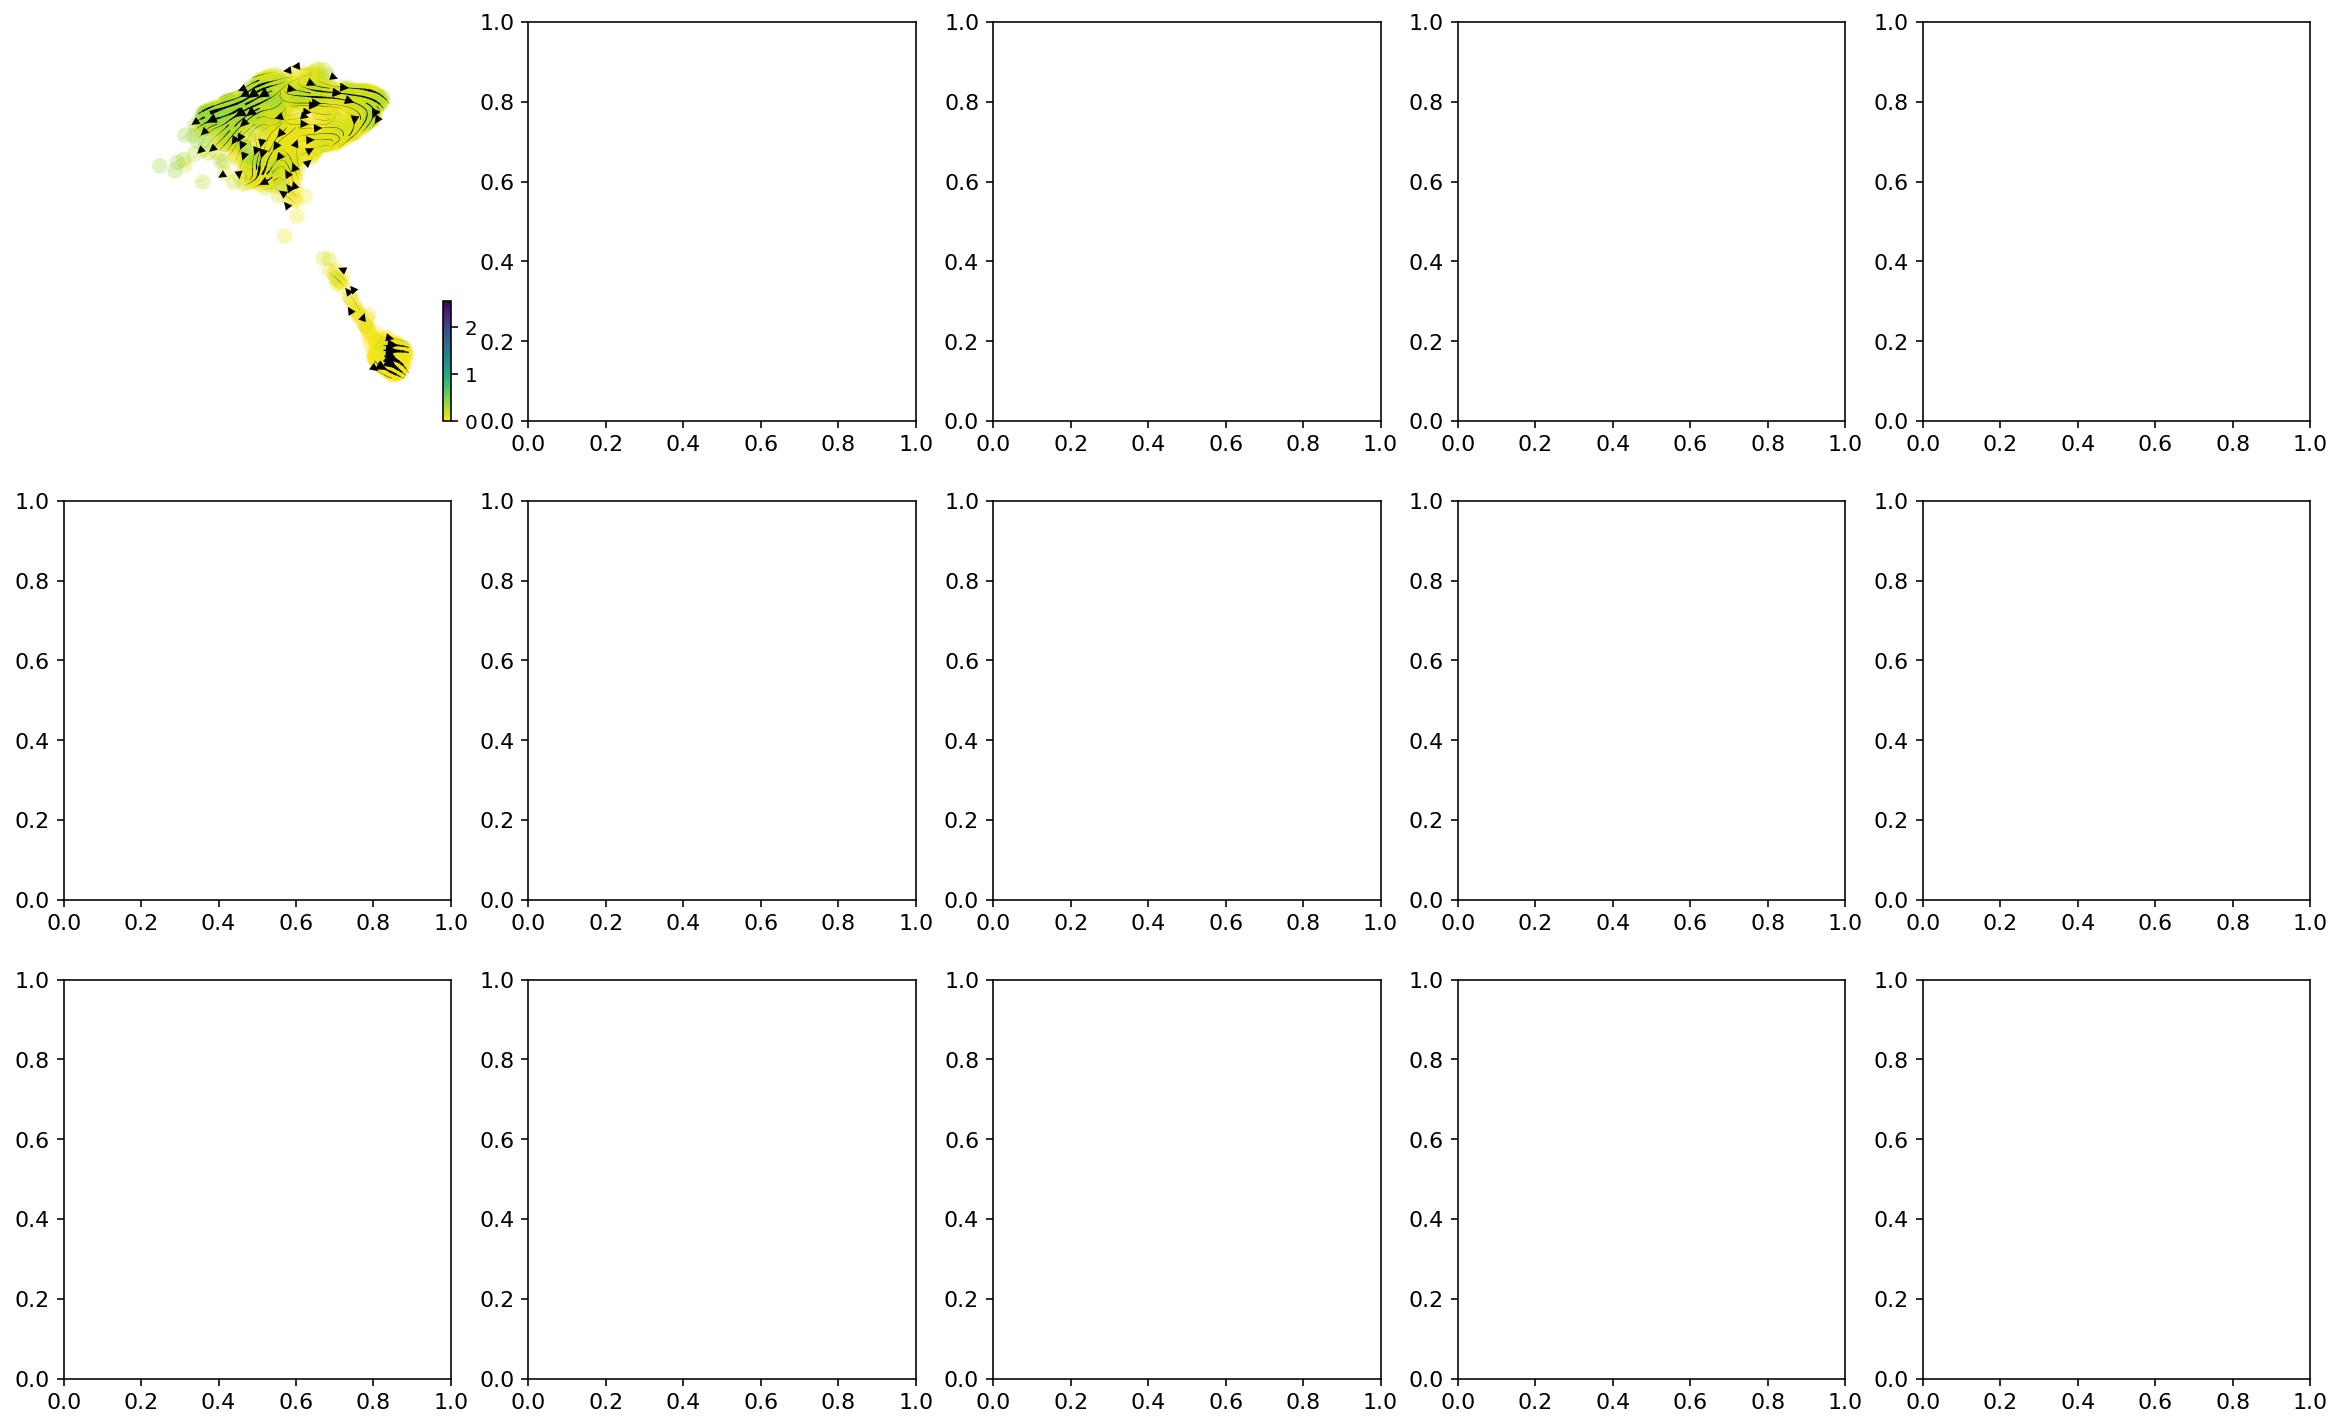

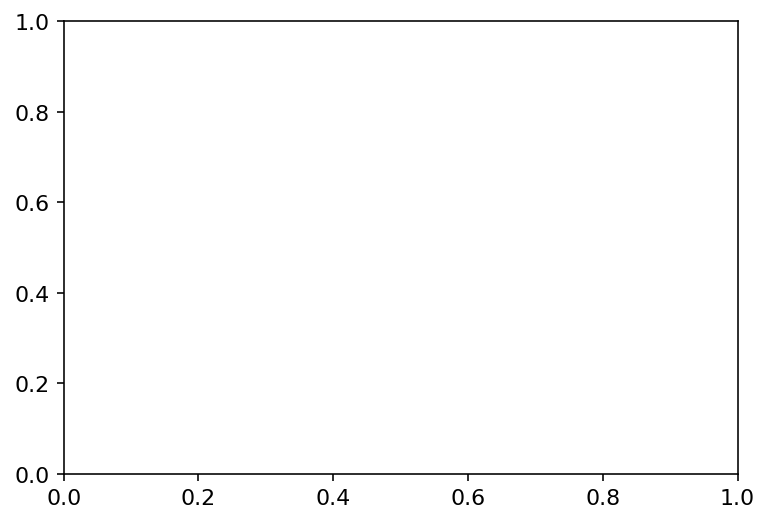

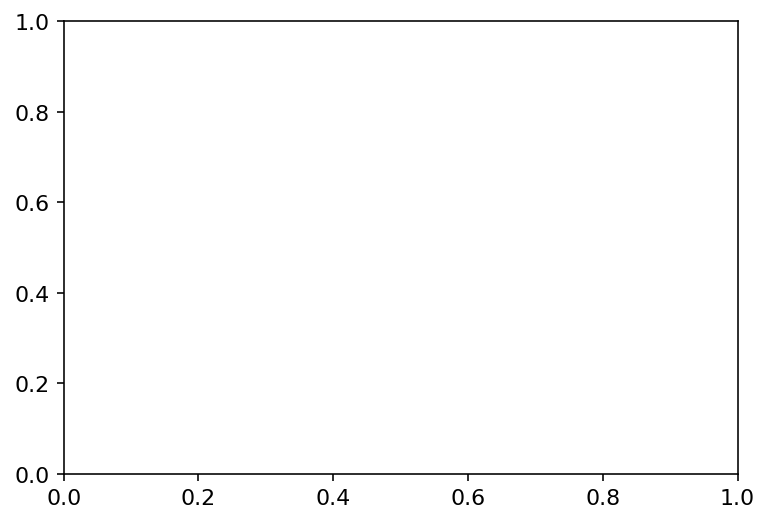

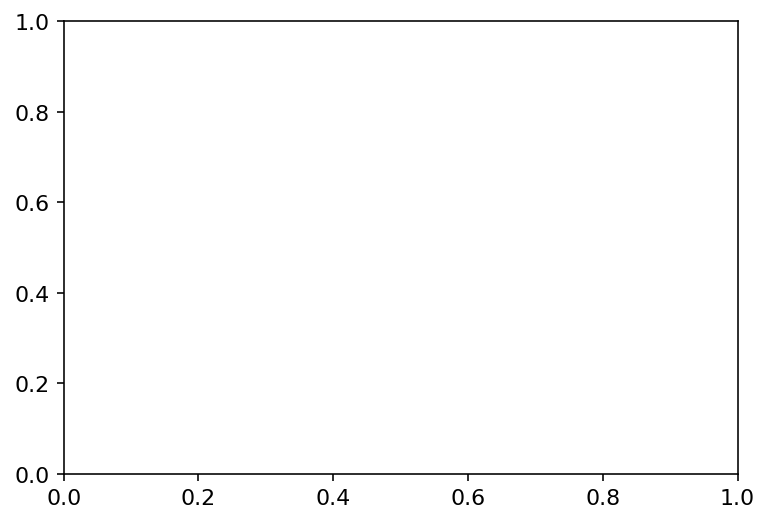

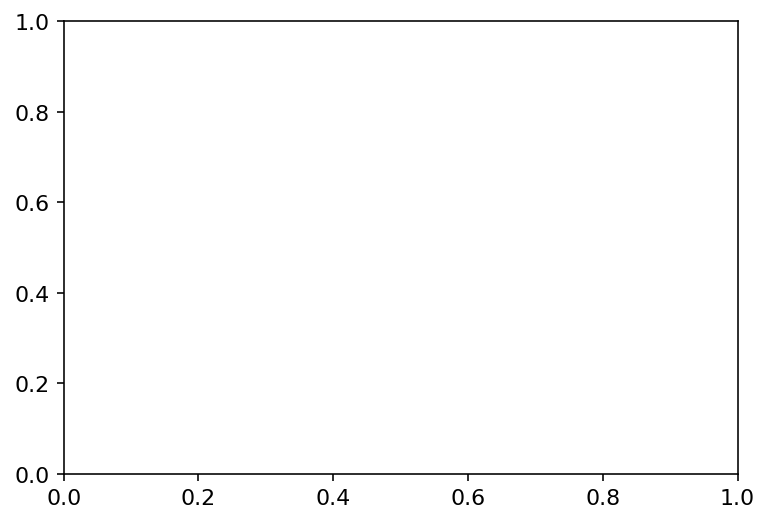

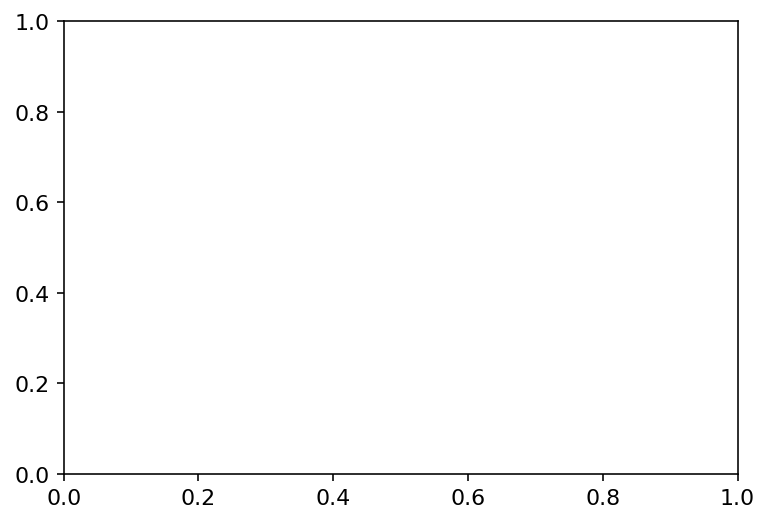

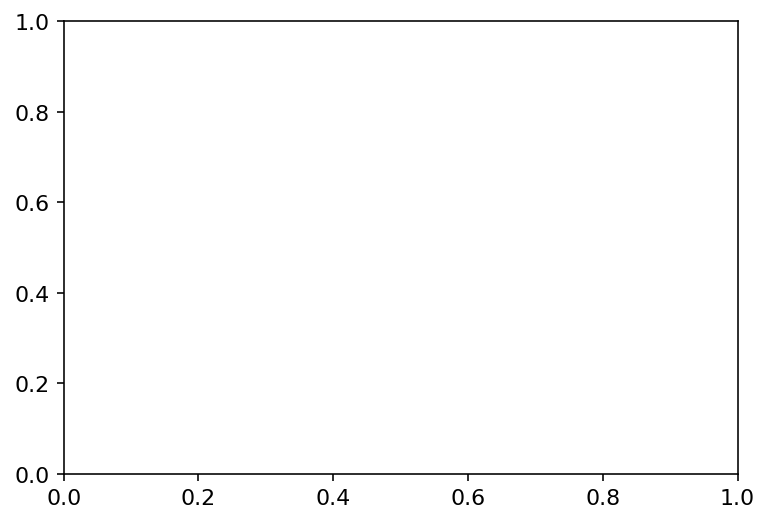

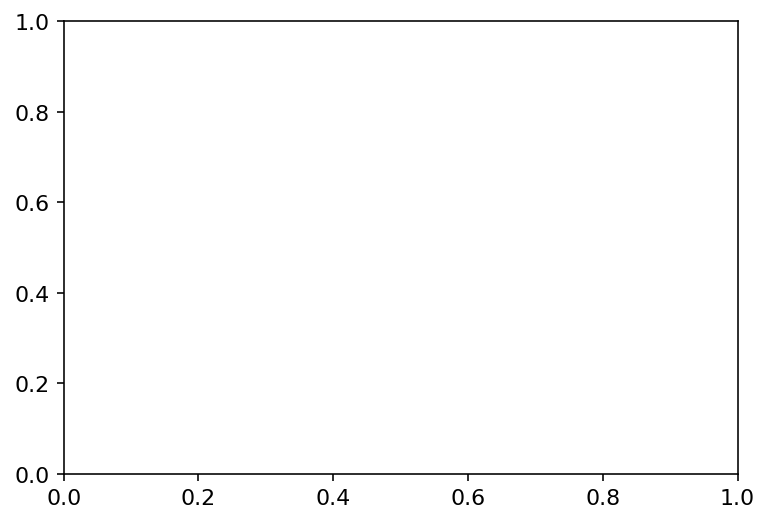

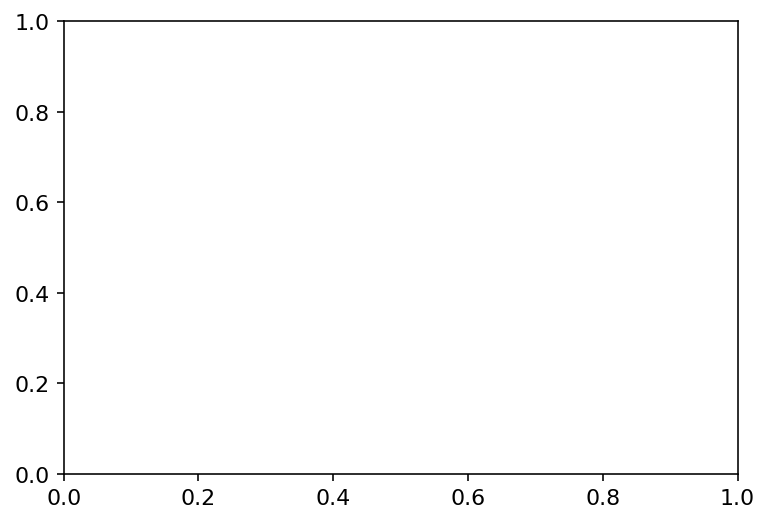

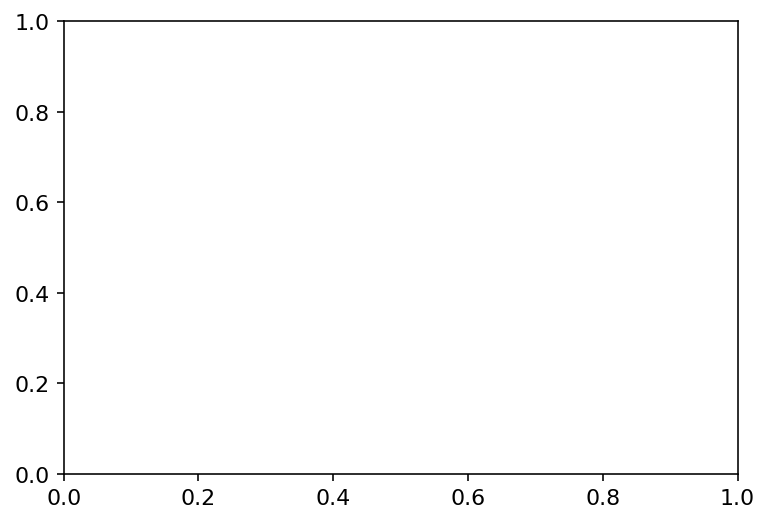

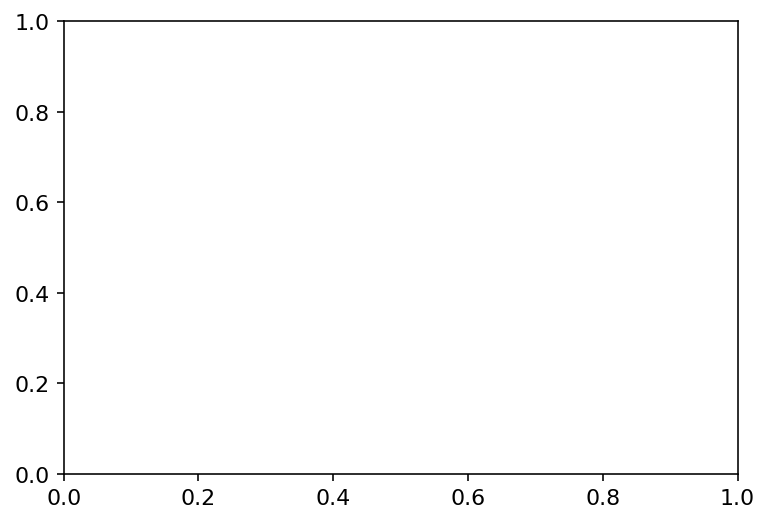

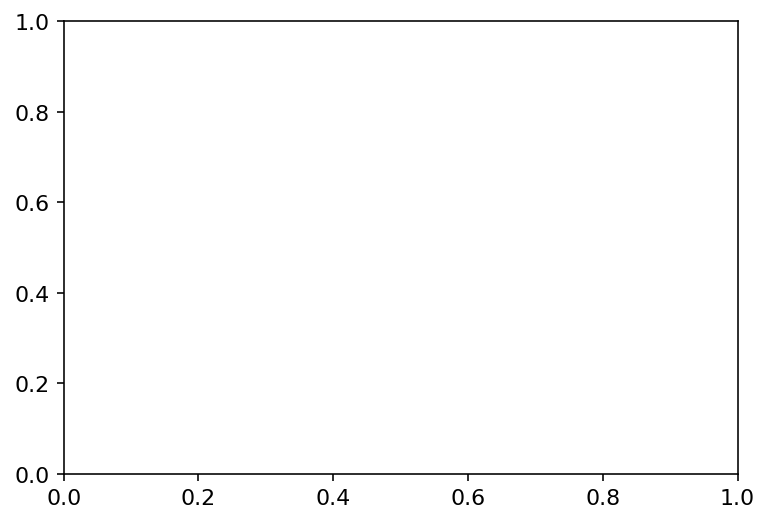

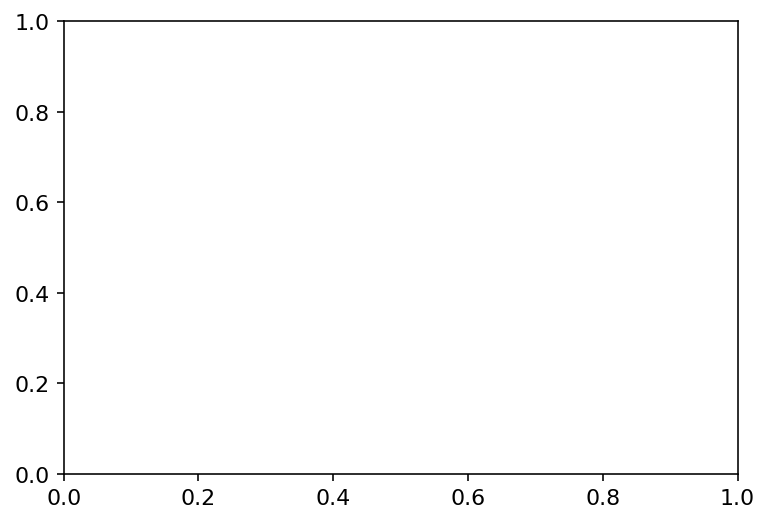

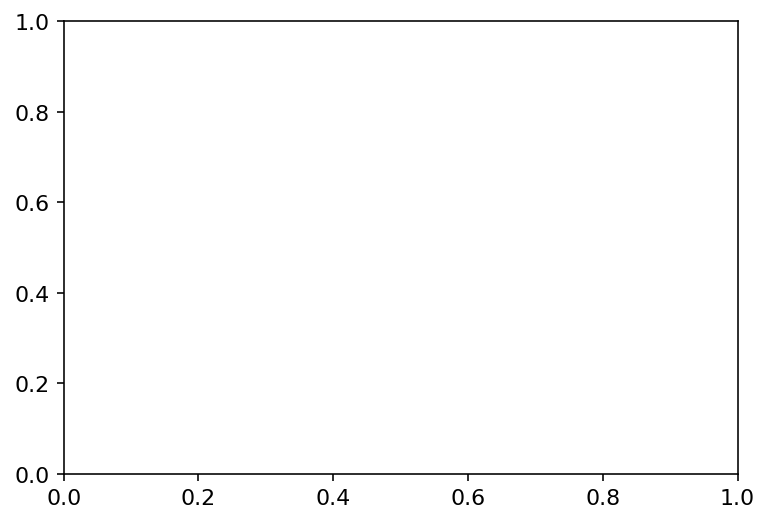

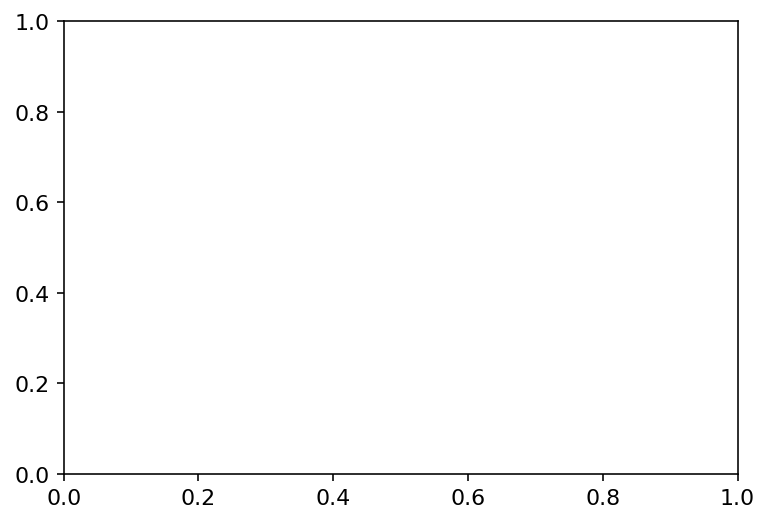

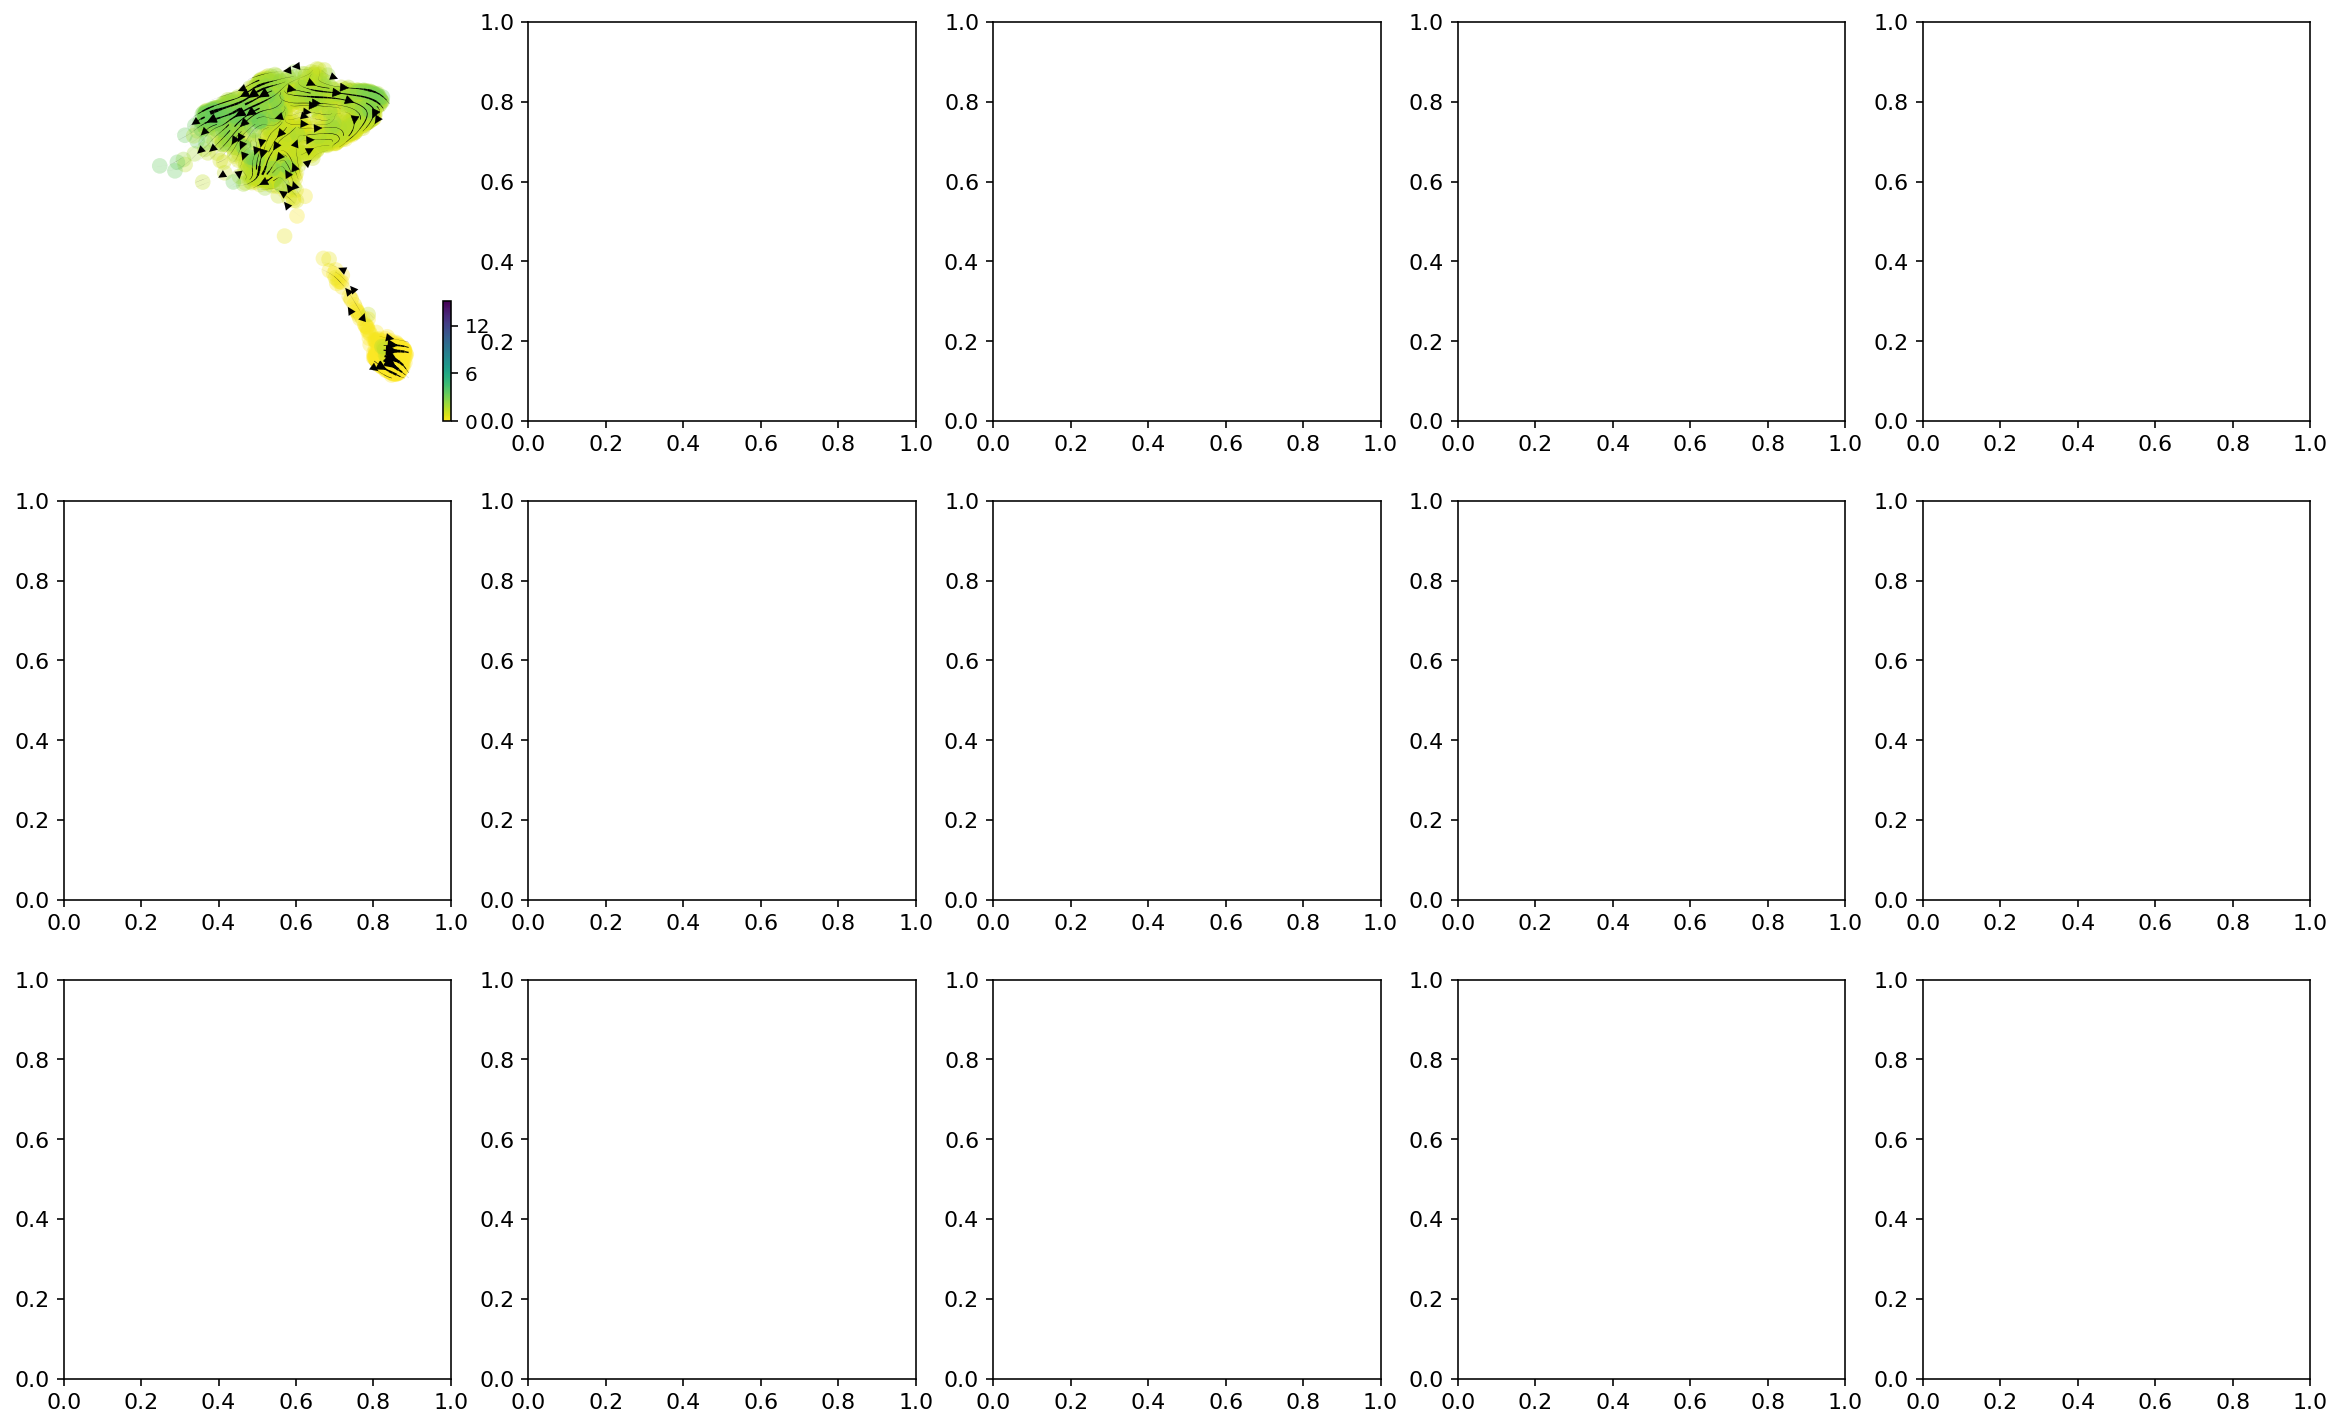

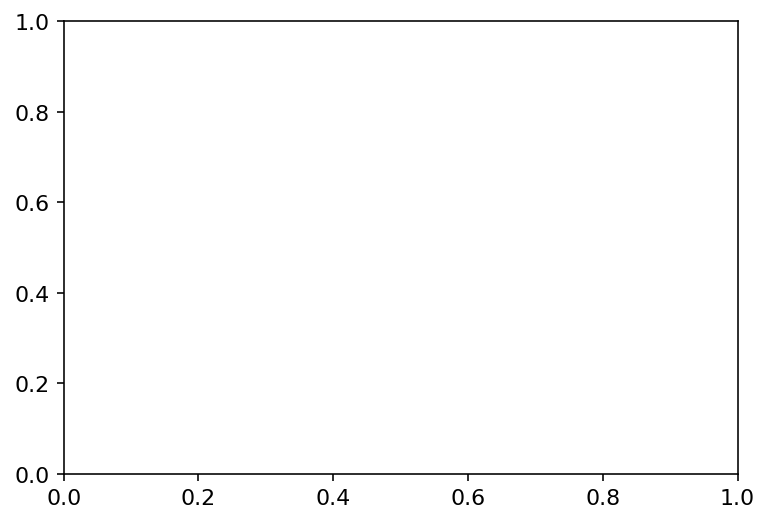

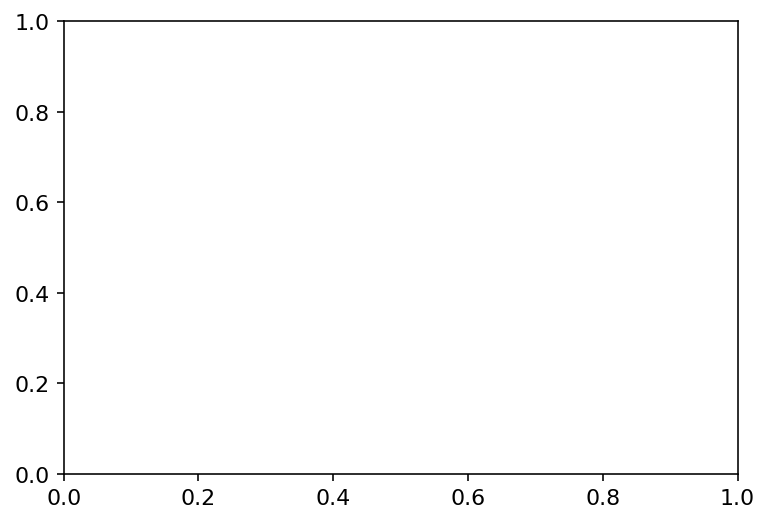

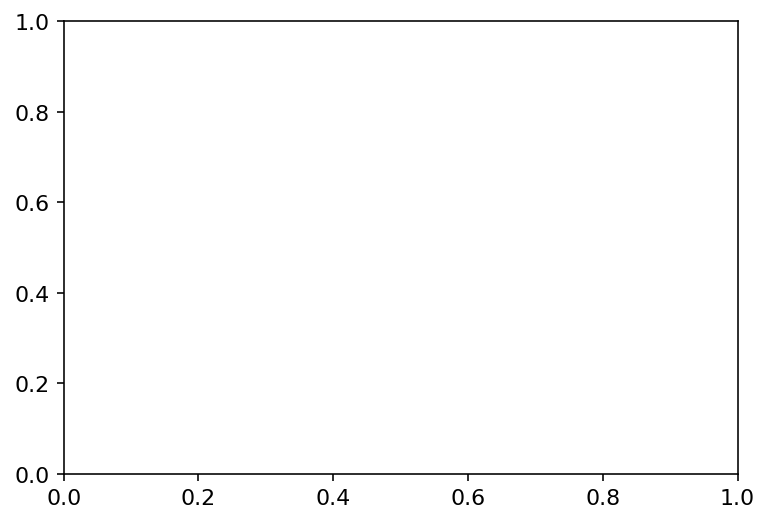

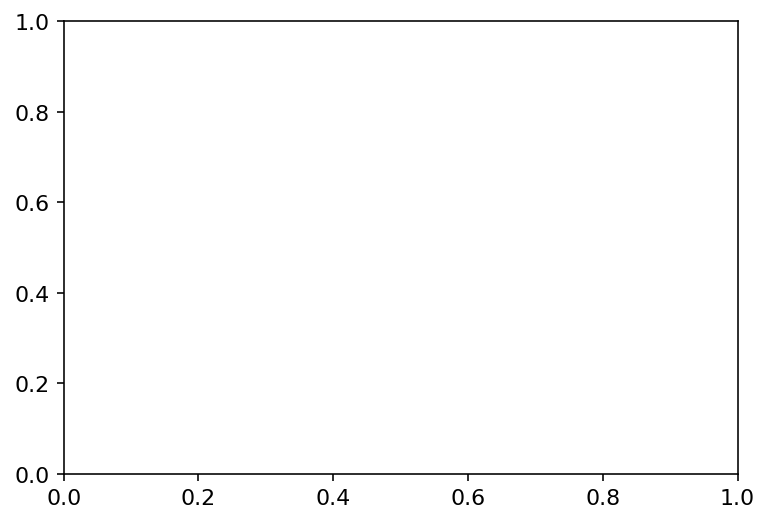

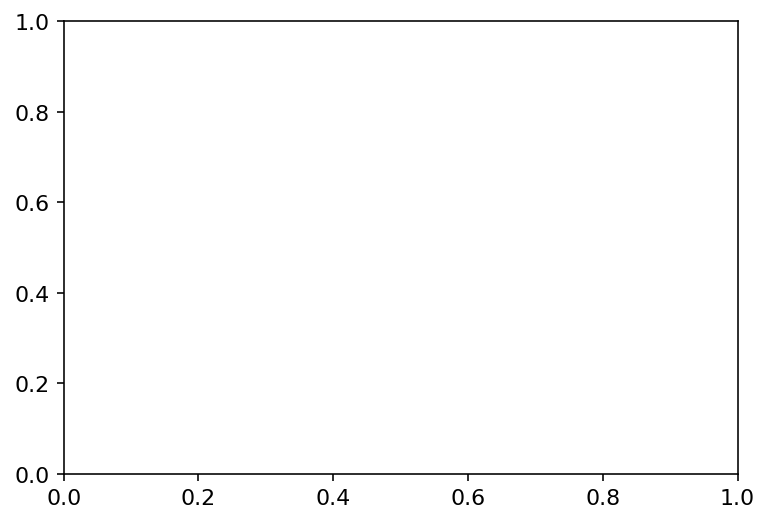

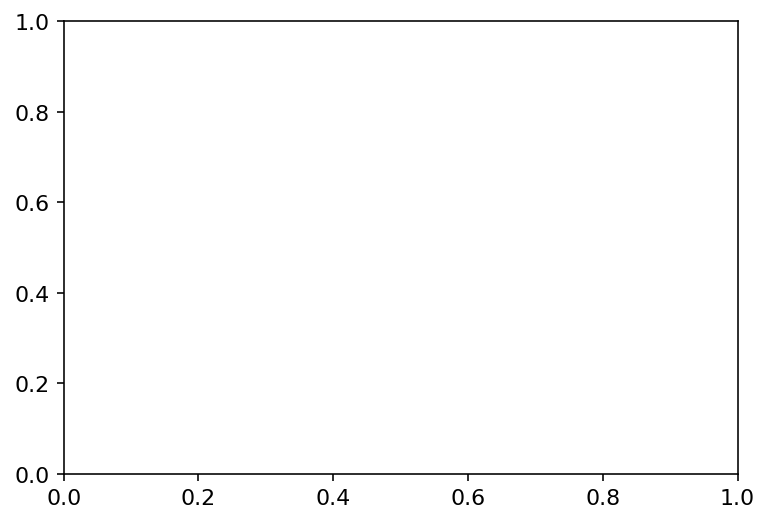

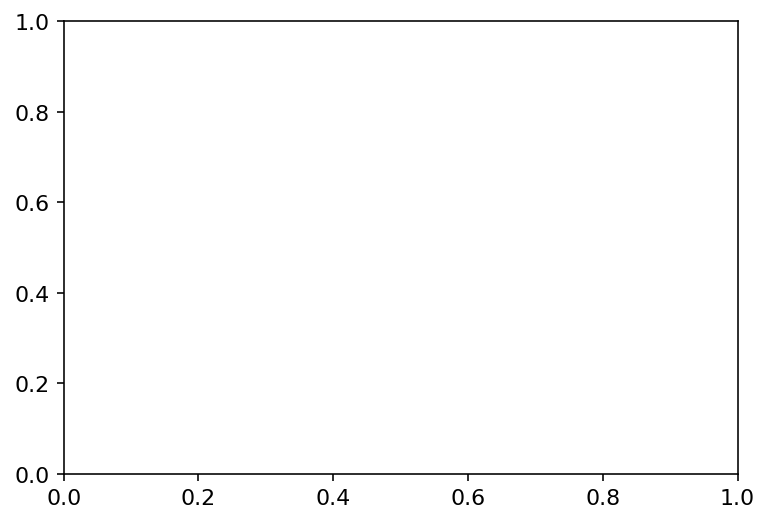

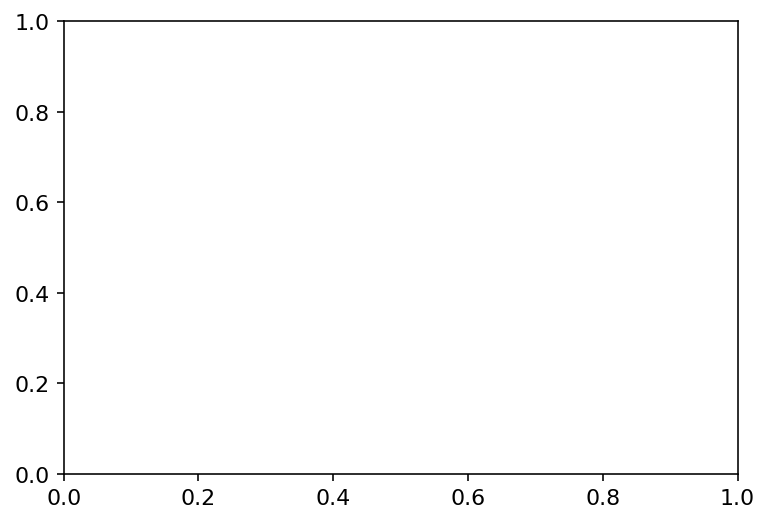

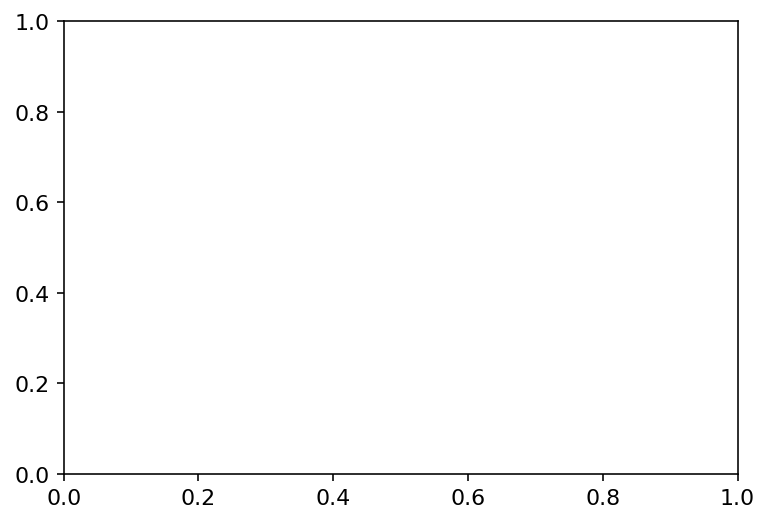

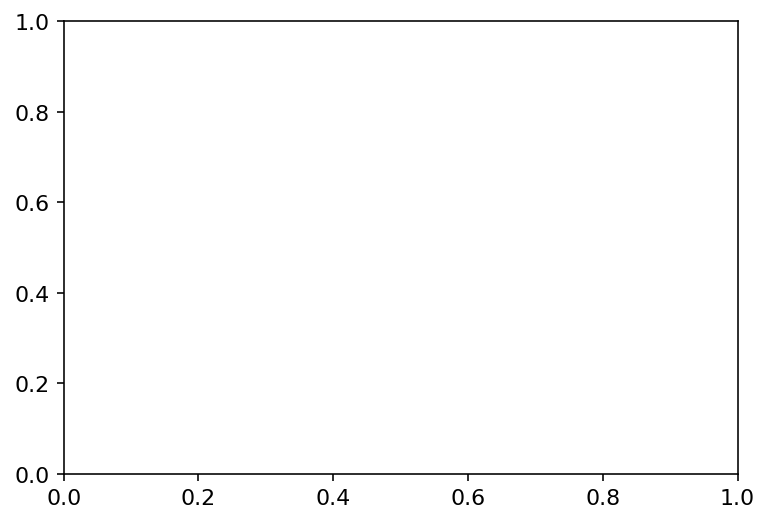

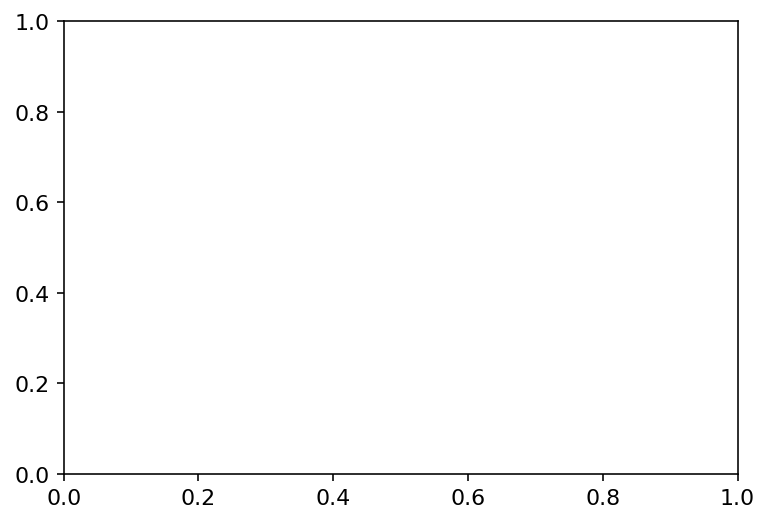

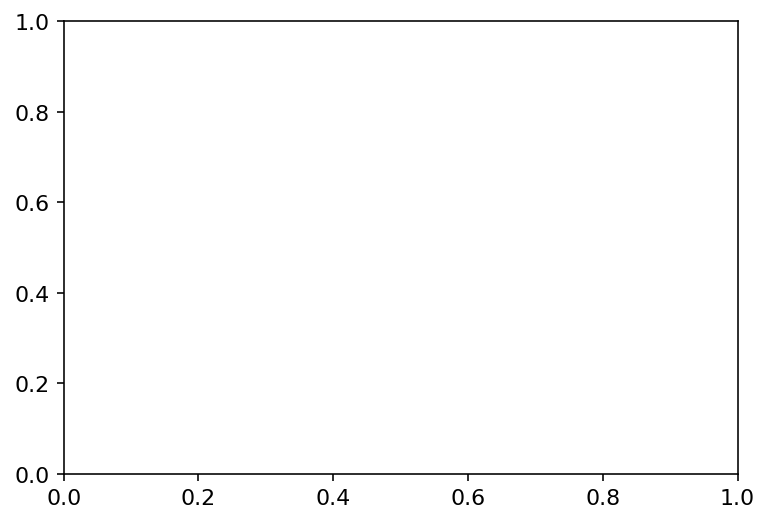

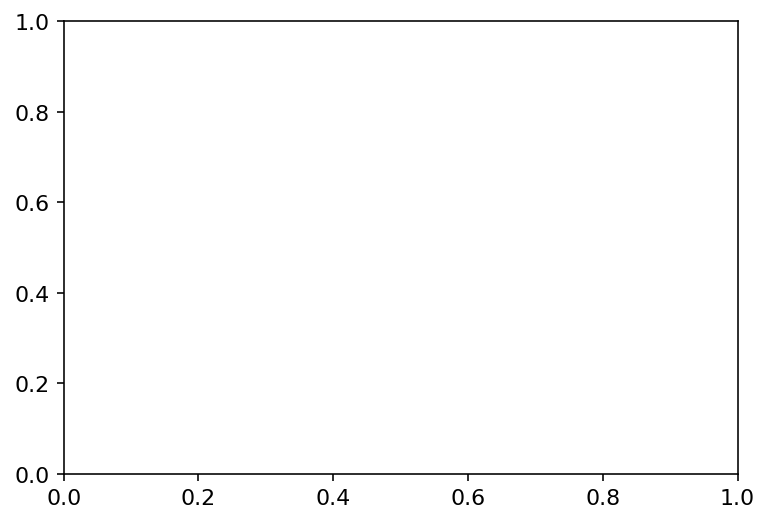

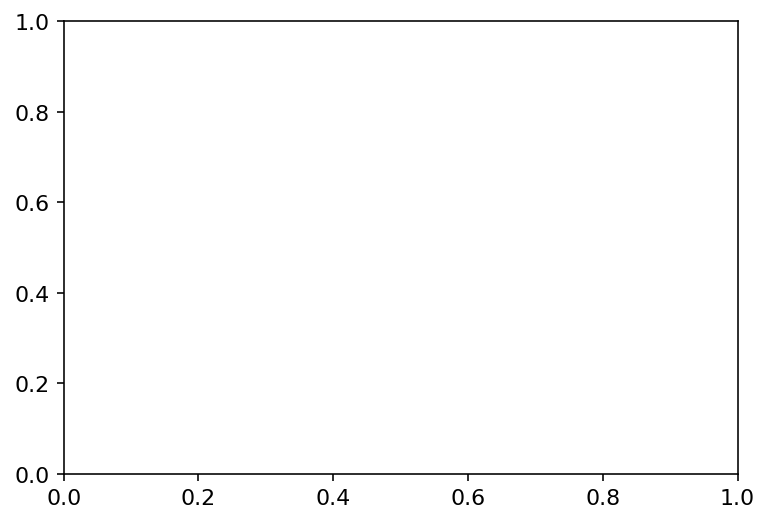

In [13]:
###----- Set key genes
genes = ['Zeb2', 'Tbx21', 'Id2', 'Prdm1', 'Batf3',
         'Sell', 'Slamf6', 'Id3', 'Tcf7', 'Tox',
         'Cd69', 'Itgae', 'Ccr9', 'Runx3', 'Stat3']

# Calculate uniform limits (upper and lower) for each gene
gene_limits_dict = {}
for gene_i in genes:
    gene_limits_dict[gene_i] = {}
    for layer_use in ['velocity','Ms', 'Mu']:
        gene_limits_dict[gene_i][layer_use] = {}
        gene_i_idx = adata.var.index.get_loc(gene_i)
        gene_i_max = adata.layers[layer_use][:,gene_i_idx].max()
        if layer_use == 'velocity':
            gene_i_min = adata.layers[layer_use][:,gene_i_idx].min()
            gene_i_max = max(abs(gene_i_min), gene_i_max) * 0.6
            gene_i_min = - gene_i_max
        else:
            gene_i_max = gene_i_max * 0.6
            gene_i_min = 0
            
        gene_limits_dict[gene_i][layer_use]['min'] = gene_i_min
        gene_limits_dict[gene_i][layer_use]['max'] = gene_i_max

###----- Plot key genes for Arm or Cl13
if True:
    adata_dict = {'Arm': adata_subset_arm, 'Cl13': adata_subset_cl13}
    layers = ['velocity','Ms', 'Mu']
    layer_color_dict = {'Ms': 'viridis_r', 'Mu':'viridis_r', 'velocity': 'coolwarm'}

    for adata_key, adata_val in adata_dict.items():
        for layer_use in layers:
            fig, axes = plt.subplots(3,5, figsize=(20,12))
            out_name = adata_key + "-" + layer_use + "_key-genes_stream.png"
            for idx_i, gene_i in enumerate(genes):
                row = math.floor(idx_i/5)
                col = idx_i % 5
                scv.pl.velocity_embedding_stream(adata_val, basis='paga', frameon=False, title="", 
                                                 color=gene_i, cmap=layer_color_dict[layer_use], layer=layer_use,
                                                 vmin = gene_limits_dict[gene_i][layer_use]['min'], vmax = gene_limits_dict[gene_i][layer_use]['max'], 
                                                 xlim=(paga_xmin, paga_xmax), ylim=(paga_ymin, paga_ymax), ax=axes[row,col])
            fig.savefig(out_name)

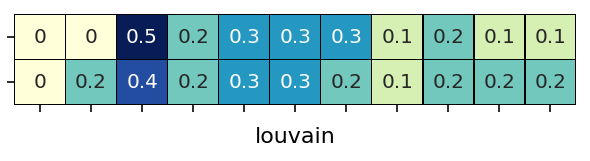

In [29]:
save_name = 'Il2ra_Ms_heatmap'

### Plot
gene_use = 'Il2ra'
gene_idx = adata.var.index.tolist().index(gene_use)


rcParams['figure.figsize'] = 5,0.8
cl13_root_df = adata_subset_cl13.obs[['louvain']]
cl13_root_df[gene_use] = adata_subset_cl13.layers['Ms'][:,gene_idx]
cl13_root_df_sum = cl13_root_df.groupby(['louvain']).mean().reset_index()

arm_root_df = adata_subset_arm.obs[['louvain']]
arm_root_df[gene_use] = adata_subset_arm.layers['Ms'][:,gene_idx]
arm_root_df_sum = arm_root_df.groupby(['louvain']).mean().reset_index()

cl13_root_df_sum.columns = ['louvain', 'cl13']
arm_root_df_sum.columns = ['louvain', 'arm']
arm_cl13_root_df = arm_root_df_sum.merge(cl13_root_df_sum, how='outer').set_index('louvain')
arm_cl13_root_df = arm_cl13_root_df.loc[[x for x in louvain_new_ordered if x in arm_cl13_root_df.index.tolist()]]
arm_cl13_root_df = arm_cl13_root_df.round(1)

heatmap = sns.heatmap(arm_cl13_root_df.T, cmap="YlGnBu", vmin=0, vmax=0.5, linecolor='black', linewidth=0.2, annot=True, cbar=False)
plt.savefig(save_name + ".png")
heatmap.set(xticklabels=[])
heatmap.set(yticklabels=[])
plt.savefig(save_name + "_nolabels.png")
plt.show()
plt.close()

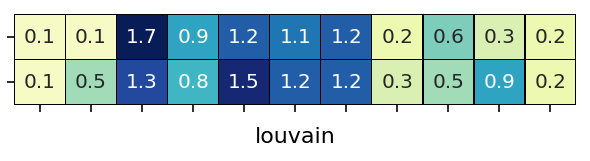

In [31]:
save_name = 'Il2ra_Mu_heatmap'

### Plot
gene_use = 'Il2ra'
gene_idx = adata.var.index.tolist().index(gene_use)


rcParams['figure.figsize'] = 5,0.8
cl13_root_df = adata_subset_cl13.obs[['louvain']]
cl13_root_df[gene_use] = adata_subset_cl13.layers['Mu'][:,gene_idx]
cl13_root_df_sum = cl13_root_df.groupby(['louvain']).mean().reset_index()

arm_root_df = adata_subset_arm.obs[['louvain']]
arm_root_df[gene_use] = adata_subset_arm.layers['Mu'][:,gene_idx]
arm_root_df_sum = arm_root_df.groupby(['louvain']).mean().reset_index()

cl13_root_df_sum.columns = ['louvain', 'cl13']
arm_root_df_sum.columns = ['louvain', 'arm']
arm_cl13_root_df = arm_root_df_sum.merge(cl13_root_df_sum, how='outer').set_index('louvain')
arm_cl13_root_df = arm_cl13_root_df.loc[[x for x in louvain_new_ordered if x in arm_cl13_root_df.index.tolist()]]
arm_cl13_root_df = arm_cl13_root_df.round(1)

heatmap = sns.heatmap(arm_cl13_root_df.T, cmap="YlGnBu", vmin=0, vmax=1.6, linecolor='black', linewidth=0.2, annot=True, cbar=False)
plt.savefig(save_name + ".png")
heatmap.set(xticklabels=[])
heatmap.set(yticklabels=[])
plt.savefig(save_name + "_nolabels.png")
plt.show()
plt.close()

## Velocity embedding stream -- Trejcetories

In [11]:
trajectory_streams_dir = wk_dir + '/trajectory_streams'
Path(trajectory_streams_dir).mkdir(parents=True, exist_ok=True)
print(trajectory_streams_dir)

/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/scVelo/trajectory_streams


In [12]:
gene_dict = {'Tbx21': 2, 'Hmmr':5, 'Tox': 3, 'Tcf7':7}

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_louvain.png


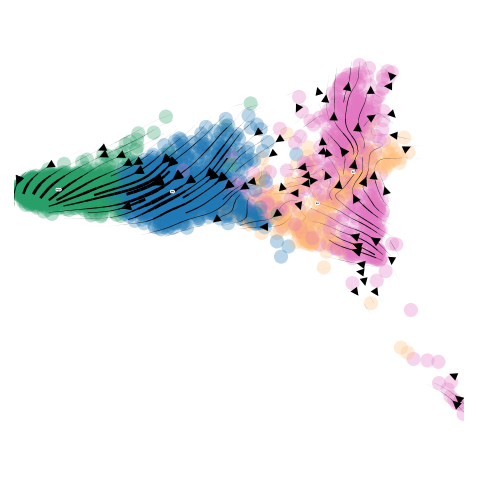

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Tbx21_Ms.png


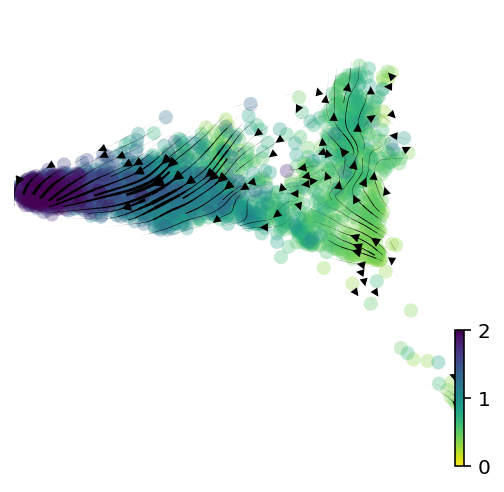

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Tbx21_Mu.png


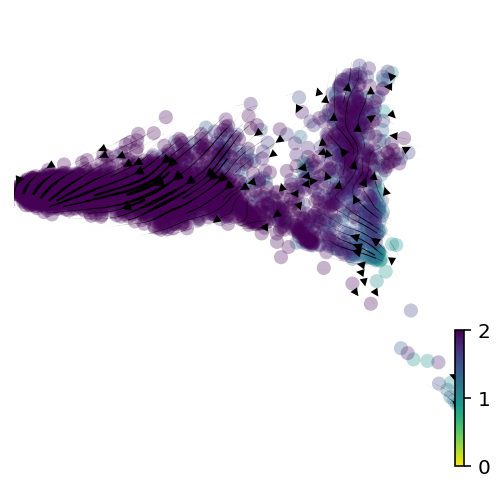

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Hmmr_Ms.png


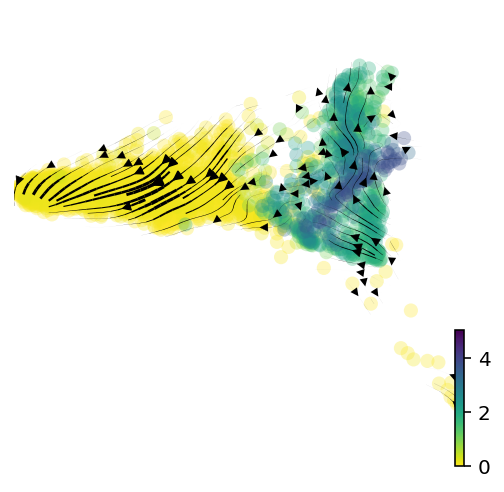

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Hmmr_Mu.png


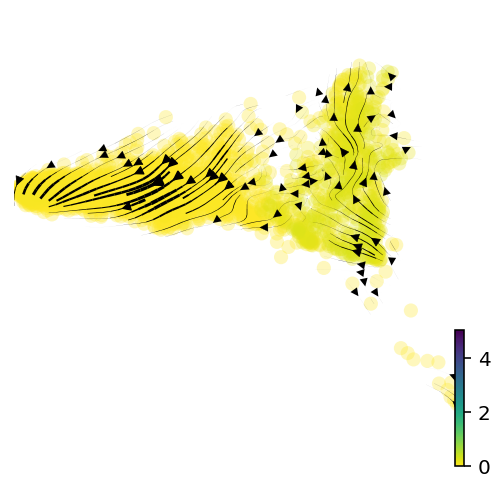

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Tox_Ms.png


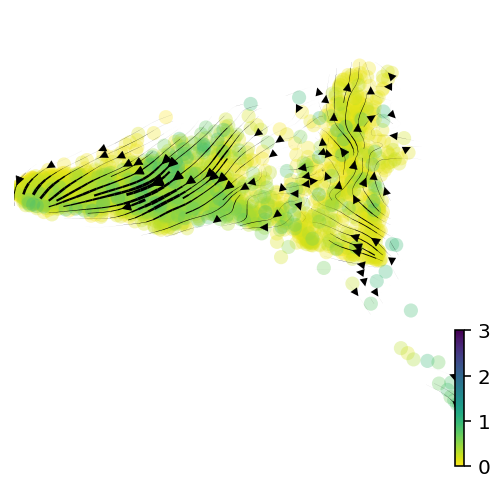

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Tox_Mu.png


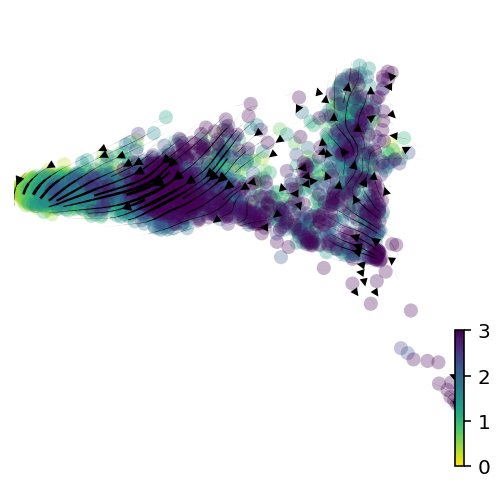

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Tcf7_Ms.png


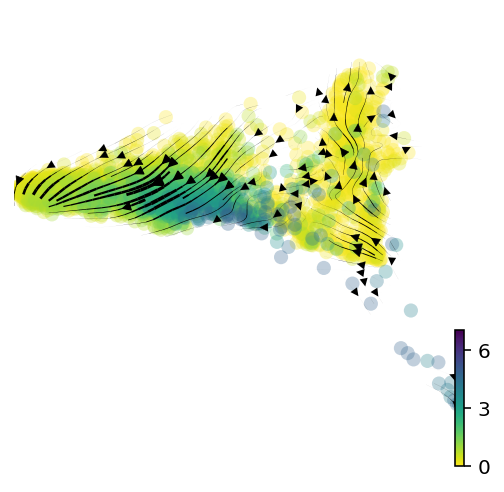

saving figure to file ./figures/scvelo_Act-Arm_t1_velocity-stream_Tcf7_Mu.png


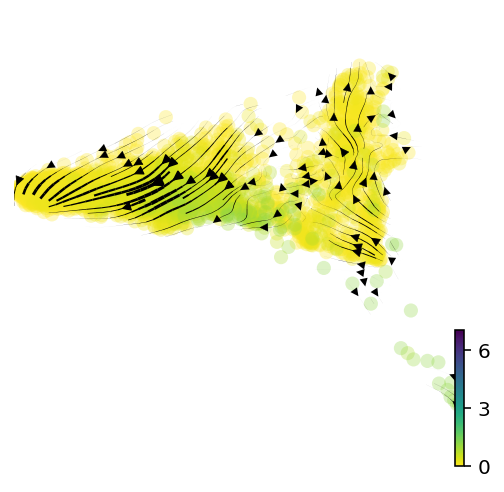

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_louvain.png


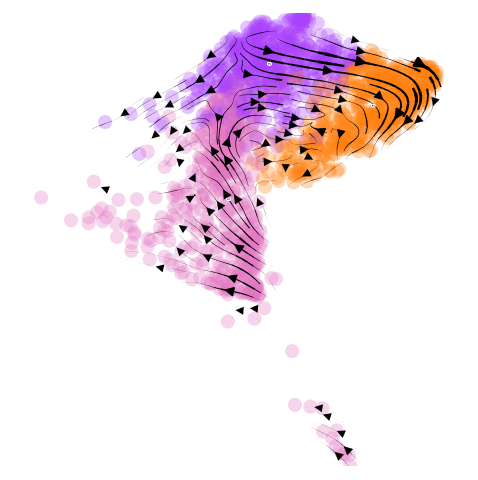

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Tbx21_Ms.png


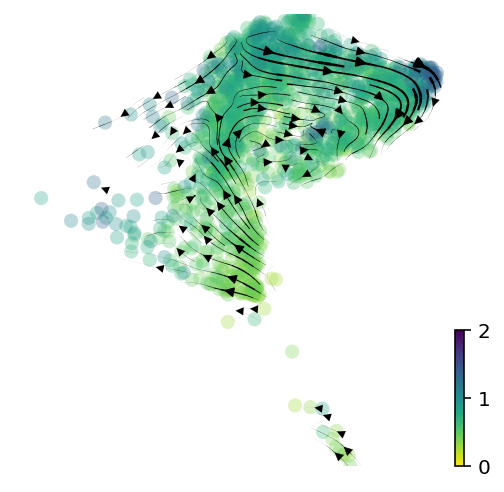

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Tbx21_Mu.png


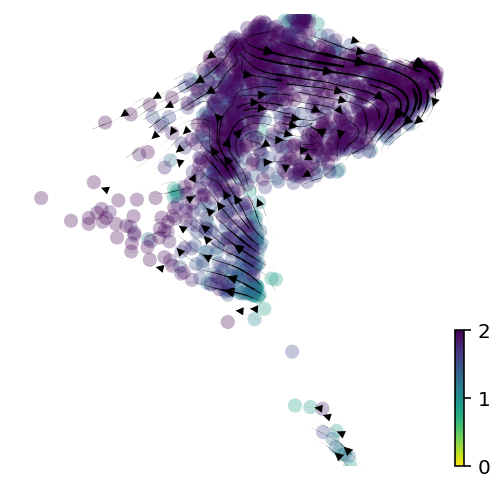

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Hmmr_Ms.png


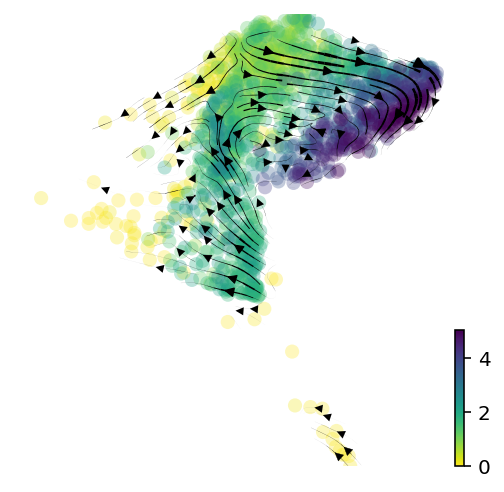

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Hmmr_Mu.png


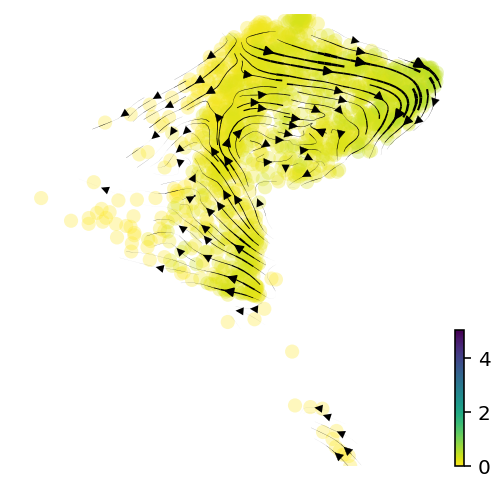

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Tox_Ms.png


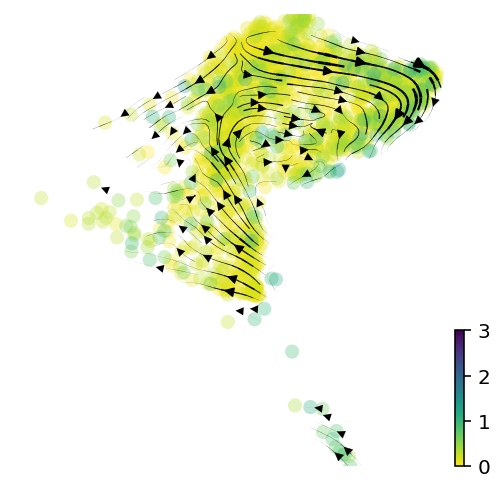

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Tox_Mu.png


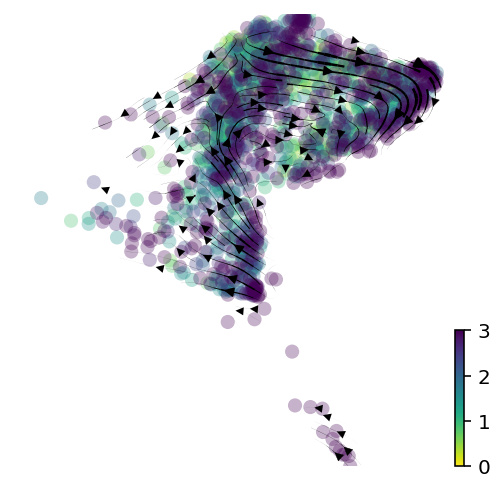

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Tcf7_Ms.png


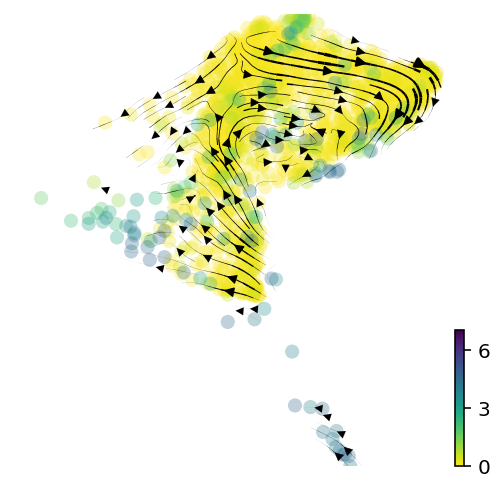

saving figure to file ./figures/scvelo_Act-Arm_t2_velocity-stream_Tcf7_Mu.png


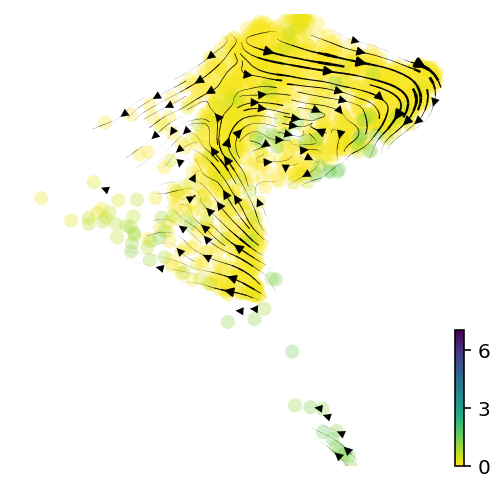

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_louvain.png


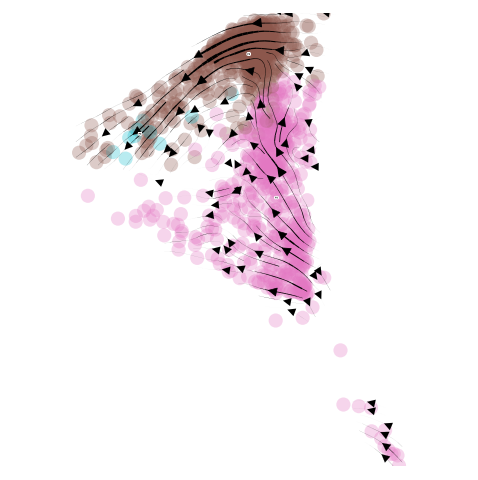

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Tbx21_Ms.png


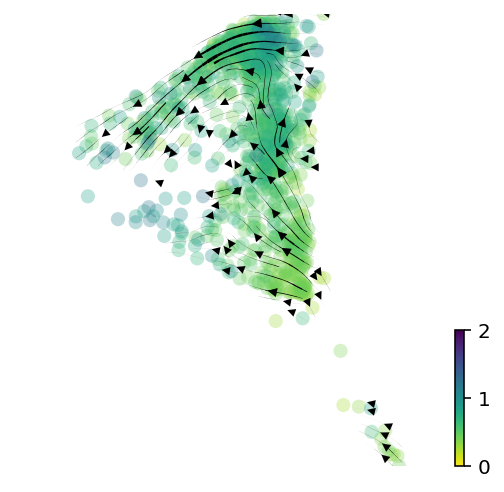

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Tbx21_Mu.png


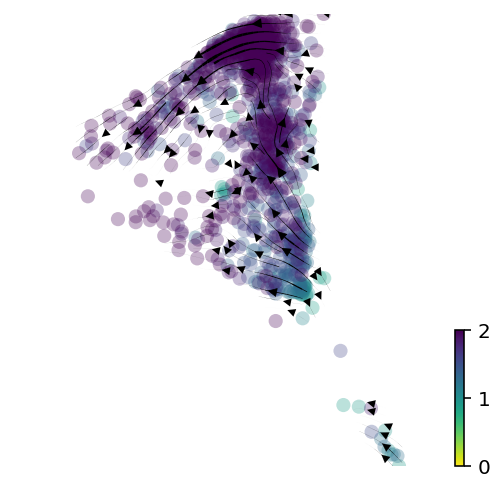

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Hmmr_Ms.png


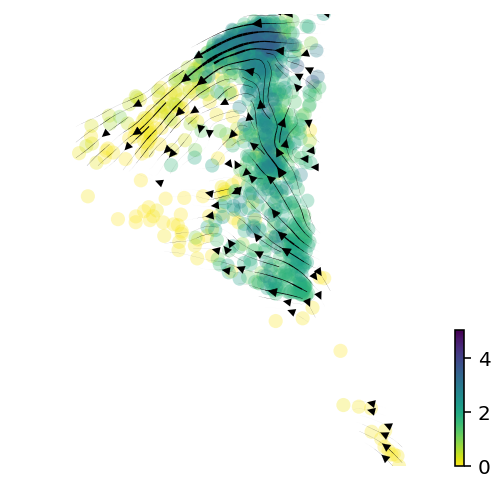

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Hmmr_Mu.png


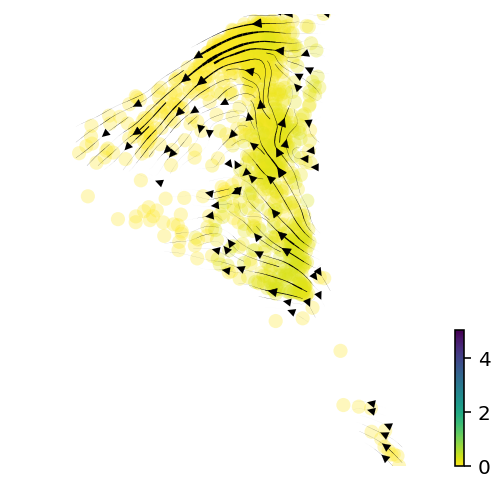

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Tox_Ms.png


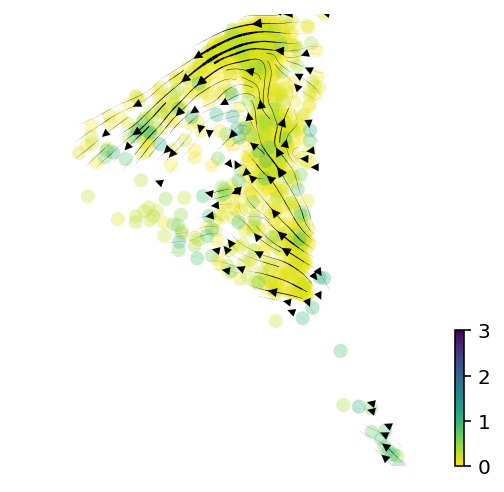

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Tox_Mu.png


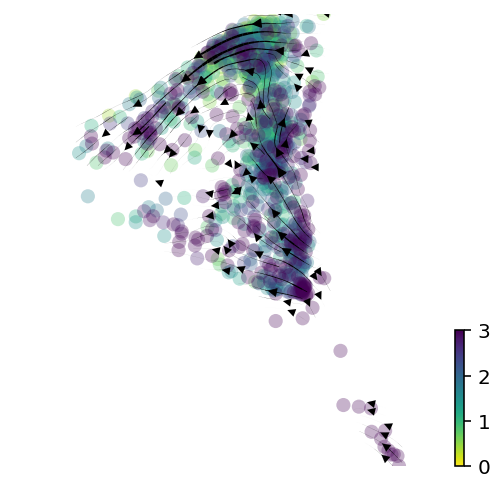

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Tcf7_Ms.png


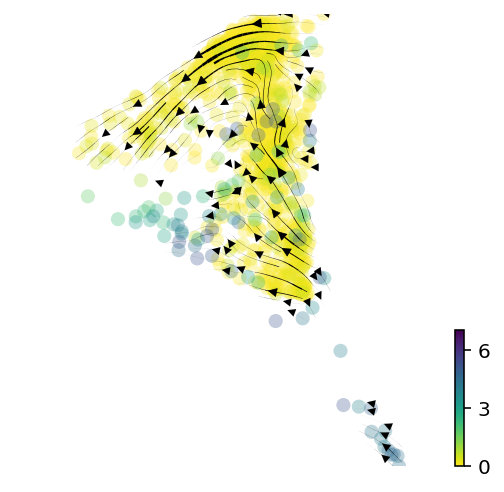

saving figure to file ./figures/scvelo_Act-Arm_t3_velocity-stream_Tcf7_Mu.png


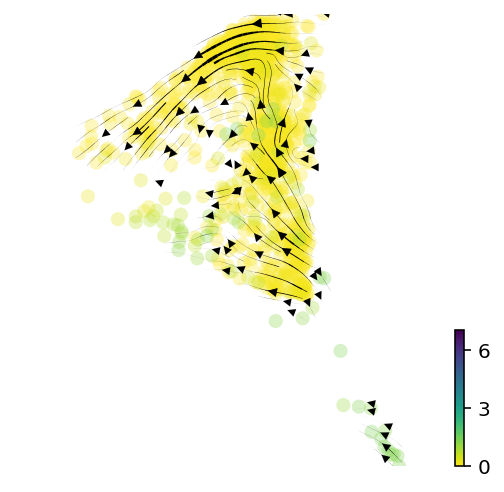

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_louvain.png


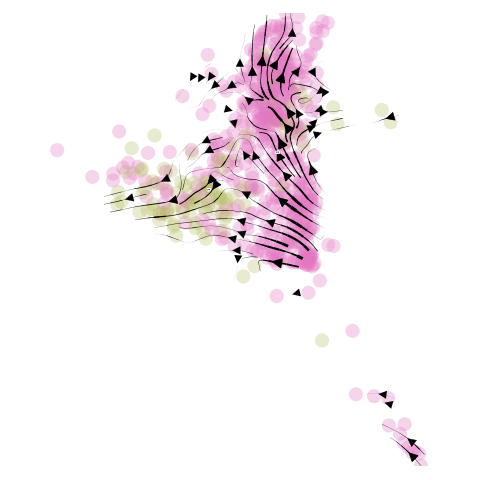

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Tbx21_Ms.png


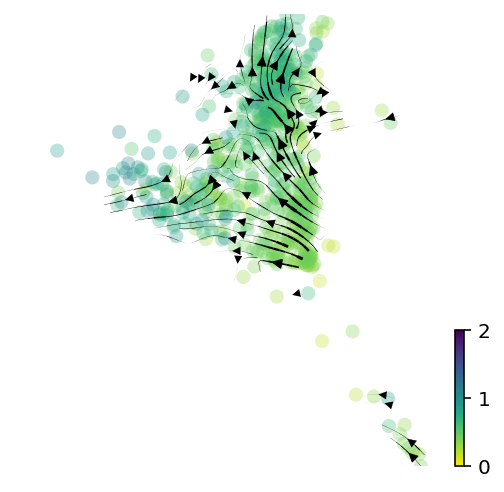

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Tbx21_Mu.png


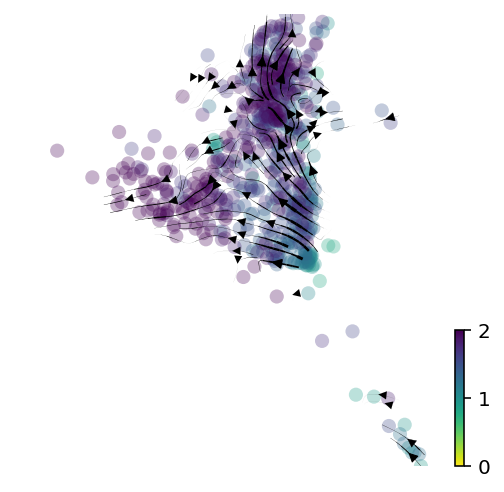

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Hmmr_Ms.png


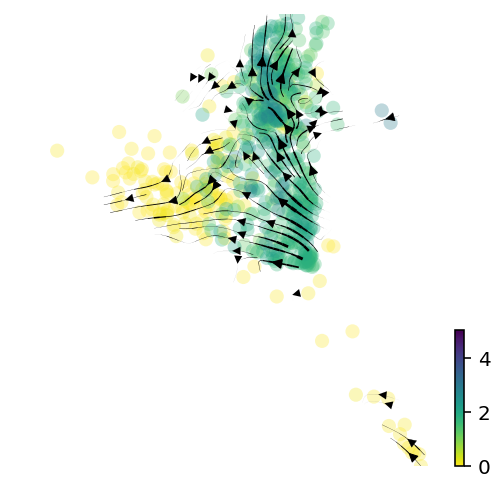

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Hmmr_Mu.png


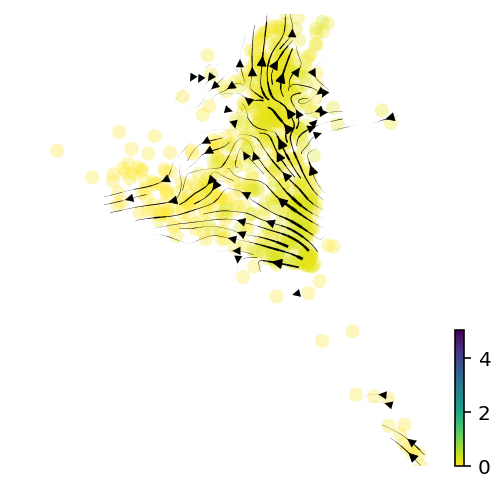

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Tox_Ms.png


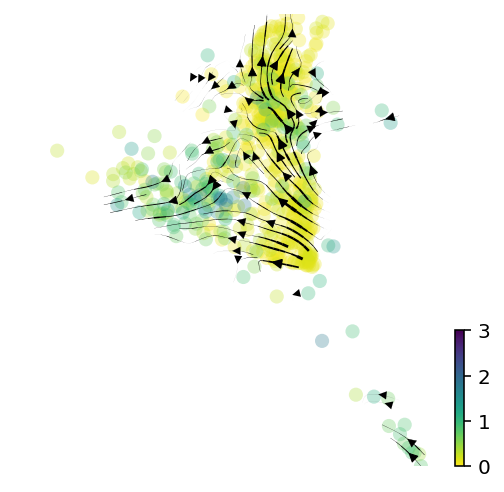

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Tox_Mu.png


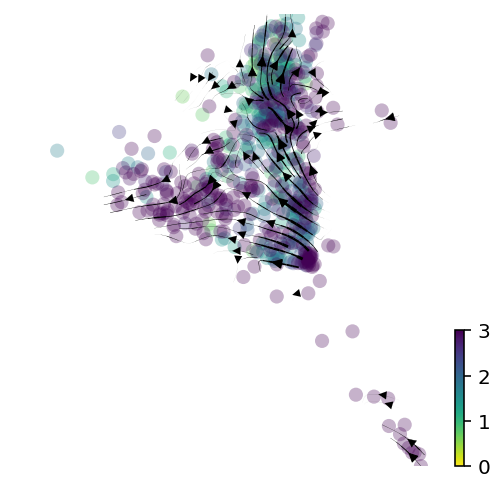

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Tcf7_Ms.png


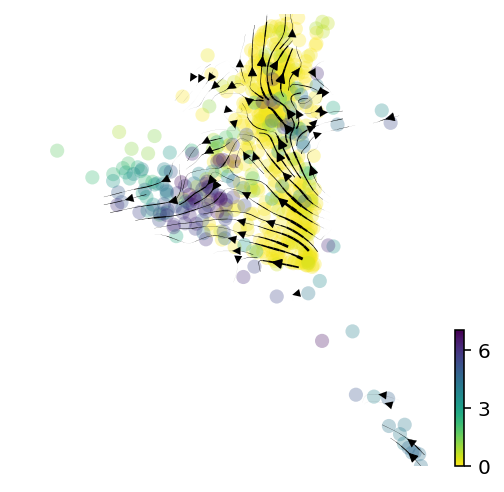

saving figure to file ./figures/scvelo_Act-Arm_t4_velocity-stream_Tcf7_Mu.png


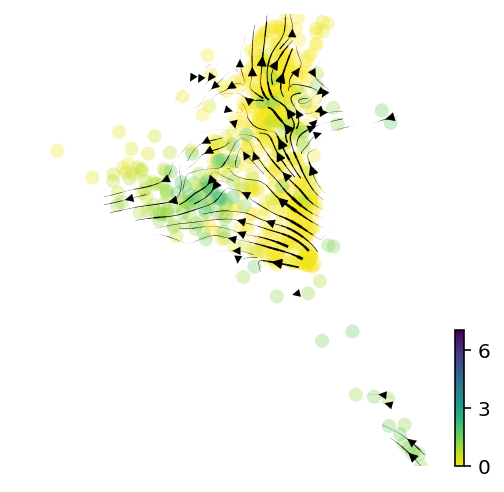

In [13]:
t1 = ["P2", "P4", "P9", "P10"]
t2 = ["P2", "P5", "P3"]
t3 = ["P2", "P6", "P8"]
t4 = ["P2", "P7"]

t_dict = {"t1":t1,"t2":t2, "t3":t3, "t4":t4}

adata_use = adata_subset_arm
outname_base = "Act-Arm"
plot_stream = True

out_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/scVelo/trajectory_streams/Act-Arm'

use_dir = trajectory_streams_dir + "/" + outname_base
Path(use_dir).mkdir(parents=True, exist_ok=True)
os.chdir(use_dir)

for t, t_clusters in t_dict.items():
    # Subset trajectory adata
    adata_t = adata_use.copy()
    adata_t = adata_t[[True if x in t_clusters else False for x in adata_t.obs['louvain']]]
    # Calculate plotting range
    x_min_use, x_max_use, y_min_use, y_max_use = subplot_lims(adata_t)
    # Outname for plots
    out_name = "%s_%s_velocity-stream"%(outname_base, t)
    # louvain colored plot
    if plot_stream:
        plt.close()
        rcParams['figure.figsize'] = 4,4
        scv.pl.velocity_embedding_stream(adata_t, basis='paga', legend_fontsize=0, title="",
                                    xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), s=200, 
                                         save = "%s_louvain.png"%out_name)
    
    ###----- Gene plots
    for gene in gene_dict.keys():
        ###----- Velocity embedding stream with gene expr
        if plot_stream:
            rcParams['figure.figsize'] = 4,4
            plt.close()
            scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Ms",
                                     xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), color_map='viridis_r',
                                     vmin=0, vmax=gene_dict[gene],
                                     save = "%s_%s_Ms.png"%(out_name, gene), s=200)
            plt.close()
            scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Mu",
                             xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), color_map='viridis_r',
                             vmin=0, vmax=gene_dict[gene],
                             save = "%s_%s_Mu.png"%(out_name, gene), s=200)
        
        ###----- Violin plots
        ms_df = pd.DataFrame(adata_t.layers['Ms'])
        mu_df = pd.DataFrame(adata_t.layers['Mu'])
        ms_df.index = adata_t.obs.index
        mu_df.index = adata_t.obs.index
        ms_df.columns = adata_t.var.index
        mu_df.columns = adata_t.var.index

        subset_louvain_cat = adata_t.obs['louvain'].cat.categories.tolist()
        subset_louvain_col = adata_t.uns['louvain_colors'].tolist()
        subset_louvain_cat_neworder = t_clusters
        subset_louvain_col_neworder = [subset_louvain_col[subset_louvain_cat.index(x)] for x in subset_louvain_cat_neworder]
        
        ms_df['louvain'] = pd.Categorical(adata_t.obs['louvain'].tolist(), subset_louvain_cat_neworder)
        mu_df['louvain'] = pd.Categorical(adata_t.obs['louvain'].tolist(), subset_louvain_cat_neworder)

        # Plot
        rcParams['figure.figsize'] = 8,4
        plt.close()
        violin_plot = sns.violinplot(x="louvain", y=gene, data=mu_df, palette=subset_louvain_col_neworder)
        plt.savefig("%s/%s_%s_Mu_violin.png"%(out_dir, out_name, gene))
        violin_plot.set(xticklabels=[], xlabel=None, yticklabels=[],ylabel=None)
        plt.savefig("%s/%s_%s_Mu_violin_nolabels.png"%(out_dir, out_name, gene))
        plt.close()
        violin_plot = sns.violinplot(x="louvain", y=gene, data=ms_df, palette=subset_louvain_col_neworder)
        plt.savefig("%s/%s_%s_Ms_violin.png"%(out_dir, out_name, gene))
        violin_plot.set(xticklabels=[], xlabel=None, yticklabels=[],ylabel=None)
        plt.savefig("%s/%s_%s_Ms_violin_nolabels.png"%(out_dir, out_name, gene))
        plt.close()

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_louvain.png


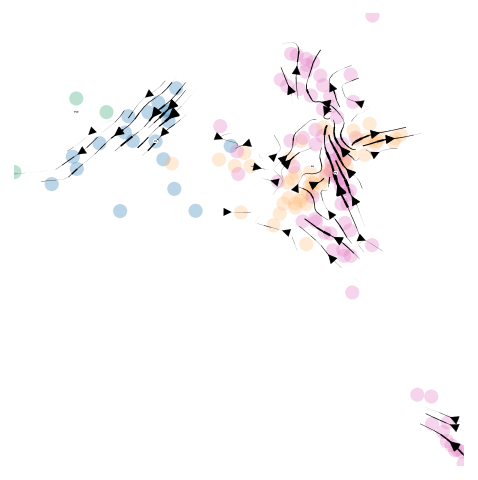

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tbx21_Ms.png


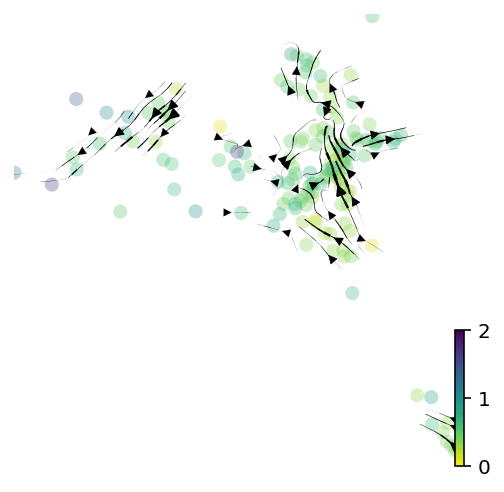

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tbx21_Mu.png


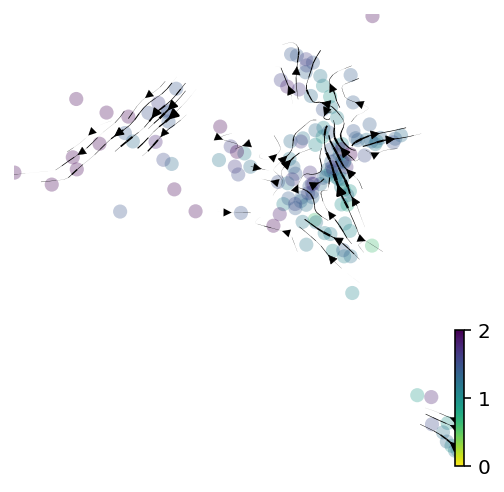

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Hmmr_Ms.png


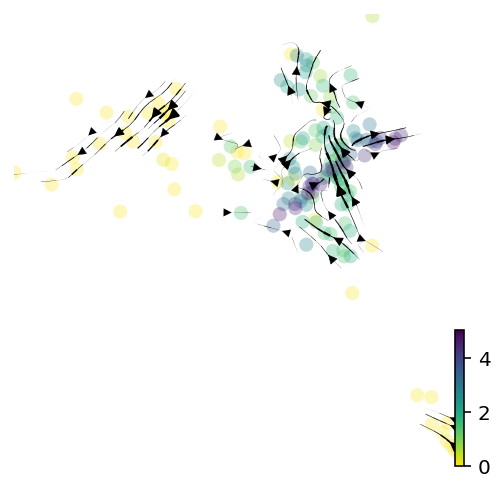

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Hmmr_Mu.png


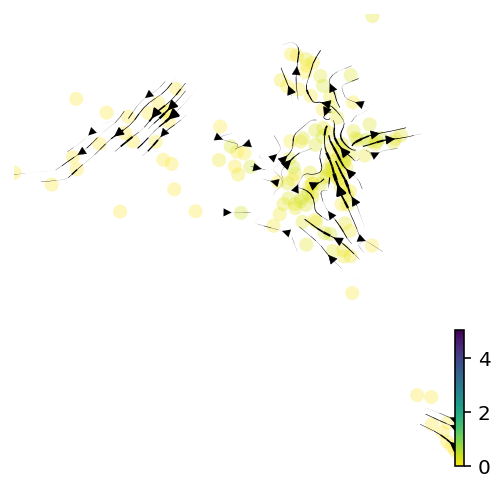

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tox_Ms.png


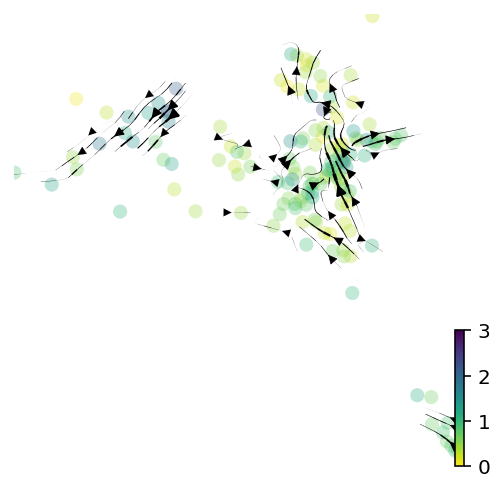

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tox_Mu.png


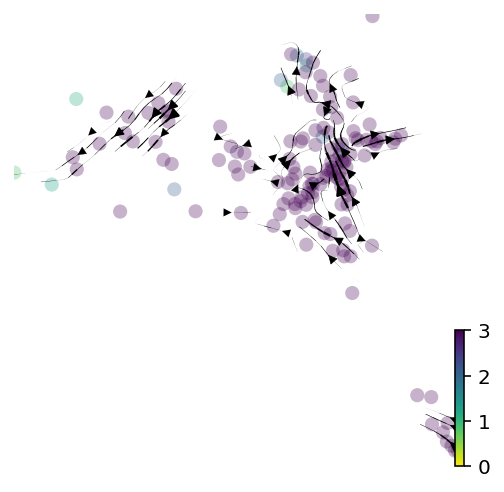

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tcf7_Ms.png


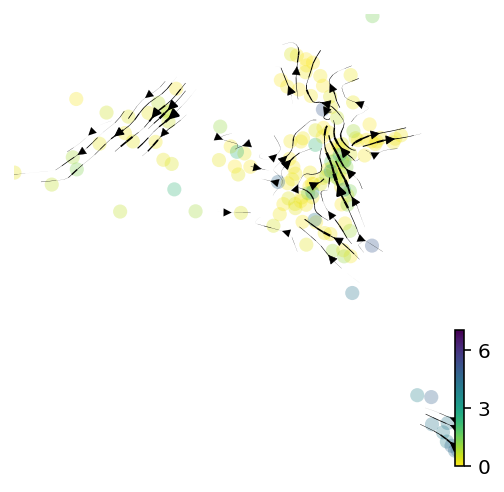

saving figure to file ./figures/scvelo_Act-Cl13_t1_velocity-stream_Tcf7_Mu.png


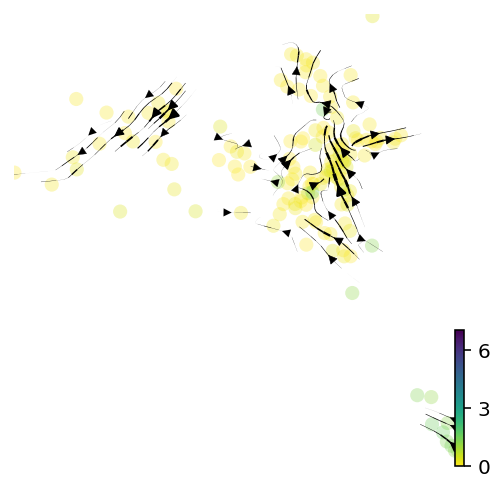

In [ ]:
t1 = ["P2", "P4", "P9", "P10"]
t2 = ["P2", "P5", "P3"]
t3 = ["P2", "P6", "P8"]
t4 = ["P2", "P7"]

t_dict = {"t1":t1,"t2":t2, "t3":t3, "t4":t4}

adata_use = adata_subset_cl13
outname_base = "Act-Cl13"
plot_stream = True

out_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/scVelo/trajectory_streams/Act-Cl13'

use_dir = trajectory_streams_dir + "/" + outname_base
Path(use_dir).mkdir(parents=True, exist_ok=True)
os.chdir(use_dir)

for t, t_clusters in t_dict.items():
    # Subset trajectory adata
    adata_t = adata_use.copy()
    adata_t = adata_t[[True if x in t_clusters else False for x in adata_t.obs['louvain']]]
    # Calculate plotting range
    x_min_use, x_max_use, y_min_use, y_max_use = subplot_lims(adata_t)
    # Outname for plots
    out_name = "%s_%s_velocity-stream"%(outname_base, t)
    # louvain colored plot
    if plot_stream:
        plt.close()
        rcParams['figure.figsize'] = 4,4
        scv.pl.velocity_embedding_stream(adata_t, basis='paga', legend_fontsize=0, title="", s=200,
                                    xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), 
                                         save = "%s_louvain.png"%out_name)
    
    ###----- Gene plots
    for gene in gene_dict.keys():
        ###----- Velocity embedding stream with gene expr
        if plot_stream:
            rcParams['figure.figsize'] = 4,4
            plt.close()
            scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Ms",
                                     xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), color_map='viridis_r',
                                     vmin=0, vmax=gene_dict[gene],
                                     save = "%s_%s_Ms.png"%(out_name, gene), s=200)
            plt.close()
            scv.pl.velocity_embedding_stream(adata_t, basis='paga', frameon=False, title="", color=gene, layer="Mu",
                             xlim=(x_min_use, x_max_use), ylim=(y_min_use, y_max_use), color_map='viridis_r',
                             vmin=0, vmax=gene_dict[gene],
                             save = "%s_%s_Mu.png"%(out_name, gene), s=200)
        
        ###----- Violin plots
        ms_df = pd.DataFrame(adata_t.layers['Ms'])
        mu_df = pd.DataFrame(adata_t.layers['Mu'])
        ms_df.index = adata_t.obs.index
        mu_df.index = adata_t.obs.index
        ms_df.columns = adata_t.var.index
        mu_df.columns = adata_t.var.index

        subset_louvain_cat = adata_t.obs['louvain'].cat.categories.tolist()
        subset_louvain_col = adata_t.uns['louvain_colors'].tolist()
        subset_louvain_cat_neworder = t_clusters
        subset_louvain_col_neworder = [subset_louvain_col[subset_louvain_cat.index(x)] for x in subset_louvain_cat_neworder]
        
        ms_df['louvain'] = pd.Categorical(adata_t.obs['louvain'].tolist(), subset_louvain_cat_neworder)
        mu_df['louvain'] = pd.Categorical(adata_t.obs['louvain'].tolist(), subset_louvain_cat_neworder)

        # Plot
        rcParams['figure.figsize'] = 8,4
        plt.close()
        violin_plot = sns.violinplot(x="louvain", y=gene, data=mu_df, palette=subset_louvain_col_neworder)
        plt.savefig("%s/%s_%s_Mu_violin.png"%(out_dir, out_name, gene))
        violin_plot.set(xticklabels=[], xlabel=None, yticklabels=[],ylabel=None)
        plt.savefig("%s/%s_%s_Mu_violin_nolabels.png"%(out_dir, out_name, gene))
        plt.close()
        violin_plot = sns.violinplot(x="louvain", y=gene, data=ms_df, palette=subset_louvain_col_neworder)
        plt.savefig("%s/%s_%s_Ms_violin.png"%(out_dir, out_name, gene))
        violin_plot.set(xticklabels=[], xlabel=None, yticklabels=[],ylabel=None)
        plt.savefig("%s/%s_%s_Ms_violin_nolabels.png"%(out_dir, out_name, gene))
        plt.close()